# Sparsity Blues

# _Michael Betancourt_  

# May 2021

As measurements become more complex they often convolve meaningful phenomena
with more extraneous phenomena.  In order to limit the impact of these
irrelevant phenomena on our inferences, and isolate the relevant phenomena, we
need models that encourage _sparse_ inferences.  In this case study I review the
basics of Bayesian inferential sparsity and some of the various strategies for
building prior models that incorporate sparsity assumptions.

# Fading into Irrelevance

Fundamentally the concept of sparsity requires some notion of a population.
Inferential sparsity in particular requires a population of individual contexts
from which data are generated.  In this case sparsity implies that most of the
individual contexts follow some default behavior with only a few exhibiting any
deviant behavior.

If the real-valued parameter $ \theta_{k}$ quantifies the variation of the data
generating process in the $k$th context then sparsity implies that most of the
$\theta_{k}$ should be fixed to some default value with only a few taking on
other values.  Without loss of generality we can take the default value to be
zero so that sparsity implies that most of the individual parameters will have a
zero value with just a few having non-zero values.

Although conceptually appealing, this notion of sparsity as a preference for
exactly zero values runs into problems in practice.  In particular the
information contained in any finite measurement is not enough to resolve the
difference between individual parameter values that are exactly zero against
those that are small enough to not strongly influence the data generating
process.

For example consider a normal observational model

$$
    \pi(y_{n} \mid \theta_{k}, \sigma)=
    \text{normal}(y_{n} \mid \theta_{k(n)}, \sigma),
$$

where $ k(n)$ maps each observation into the context from which it was generated.

Each context features

$$
    N_{k} = \sum_{n = 1}^{N} \mathbb{I}[k(n) = k]
$$

observations with the empirical averages

$$
    \tilde{\mu}_{k} =
    \frac{1}{N_{k}} \sum_{n = 1}^{N} \mathbb{I}[k(n) = k] \cdot \tilde{y}_{n}.
$$

The individual likelihood function informing each context is then given by

$$
    l(\theta_{k} ; \tilde{y}) \propto
    \text{normal} \left( \tilde{\mu}_{k} ; \theta_{k}, \frac{\sigma}{\sqrt{N_{k}}} \right).
$$

These individual likelihood function are relatively uniform within the interval

$$
    | \theta_{k} - \tilde{\mu}_{k} | \lessapprox \frac{\sigma}{\sqrt{N_{k}}};
$$

even if this interval contains $ \theta_{k} = 0$ we can't just discard all of the
other neighboring values that are also consistent with the observed data.

Consequently even if $\theta_{k} = 0$ is consistent with the observed data there
will always be an infinite number of small but _not-quite-zero_ values
$\theta_{k} \ne 0$ that we will not be able to strongly distinguish from that
zero value.  If the prior model is specified by a continuous probability density
function then the resulting posterior distribution will allocate vanishing
probability to $\theta_{k} = 0$ no matter the shape of the realized likelihood
function.  The only way for the hypothesis $\theta_{k} = 0$ to compete against
these small values is to engineer a prior model that _inflates_ zero by
allocating the point a non-zero probability.  Unfortunately such inflated prior
models introduce a wealth of computational problems.

These problems can be avoided, however, by abandoning the strict binary
classification between zero and non-zero.  Because of the finite resolution
afforded by any practical measurement the more pertinent task is not whether the
individual parameters are exactly zero or not but rather whether they are too
small to be _relevant_ to our inferences or not.

For one-dimensional parameters relevance can be defined in terms of a _relevance
threshold_ below which the parameters influence realized likelihood functions
only negligibly.  This threshold can sometimes be motivated by the limitations
of the observational model; for example in the normal observational model
considered above the relevance threshold could be taken as
$\sigma/ \sqrt{N_{k}}$.  Alternatively a relevance threshold can be informed by
prior knowledge of the underlying data generating process.  In either case
enforcing sparsity from this perspective becomes a matter of containing most of
the individual parameters below this relevance threshold.

If the relevance threshold is not known exactly then sparsity takes on yet
another form.  In this case the critical manifestation of a sparse inference is
that most of the parameters cluster around zero, and only a few are able to
extend to larger values.  Because the scale of that clustering may or may not
identify a meaningful relevance threshold I will generally refer to the
individual parameters that cluster around zero as the _inner core_ and the
exceptions as the _outer expanse_.

</center>
<div><center><table class="image">
<caption align="top"><h2>Inner - Outer</h2></caption>
<tr><td><img src="figures/inner_outer/inner_outer.png" width="400"></td></tr>
</table></center></div>  

Any domain expertise about the relevance threshold can always be incorporated
into the prior model for the shape of the inner core.

Regardless of its precise interpretation sparsity is a characteristic of the
entire population of parameters, not any single parameter. In particular the
assumption of sparsity does not inform _which_ parameters are irrelevant and
which are relevant.  Even if know exactly how many parameters we want to fall
into each group we still have to learn a specific _sparsity pattern_ that
assigns the individual parameters into those groups.

Because sparsity assumptions are indifferent to these possible sparsity
patterns, the domain expertise sparsity assumptions encode is invariant to
permutations of the individual contexts.  In other words a prior model that
encodes sparsity must be _exchangeable_ which, as I discuss in my
[hierarchical case study](https://betanalpha.github.io/assets/case_studies/hierarchical_modeling.html),
implies that sparsity-inducing prior models are naturally _hierarchical_.

In order to ensure sparse inferences we need to engineering a hierarchical
population model that can not only accommodate both the inner core and the outer
expanse at the same time but also encouraging most parameters towards the
former.

# Sparse Population Models

Exactly what kind of hierarchical population model can coerce wide likelihood
functions towards an inner core while allowing sufficiently narrow likelihood
functions to roam the outer expanse as needed?  In this section we'll
investigate a variety of options and their limitations.

First let's set up our `R` environment for computational experiments to guide
this investigation.

In [1]:
library(rstan)
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())
parallel:::setDefaultClusterOptions(setup_strategy = "sequential")

util <- new.env()
source('stan_utility.R', local=util)

Loading required package: StanHeaders


rstan version 2.26.11 (Stan version 2.26.1)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)


Do not specify '-march=native' in 'LOCAL_CPPFLAGS' or a Makevars file



In [2]:
c_light <- c("#DCBCBC")
c_light_highlight <- c("#C79999")
c_mid <- c("#B97C7C")
c_mid_highlight <- c("#A25050")
c_dark <- c("#8F2727")
c_dark_highlight <- c("#7C0000")

c_light_trans <- c("#DCBCBC80")
c_dark_trans <- c("#8F272780")
c_green_trans <- c("#00FF0080")

par(family="CMU Serif", las=1, bty="l", cex.axis=1, cex.lab=1, cex.main=1,
    xaxs="i", yaxs="i", mar = c(5, 5, 3, 1))

set.seed(58533858)

To compare the various population models under consideration we'll see how they
each perform on a relatively simple simulation.  Of the nine total parameters
six cluster below an inner scale of 0.1 and three venture out past 10.


In [3]:
K <- 9

theta_true <- c(-0.09604655,  0.02063505,  0.01246716,
                -0.04487767, -0.13519031,  0.09421304,
                -29.449233,  32.997172,  18.517443)


These parameters then inform the location of a normal observational model.



In [4]:
N <- K
sigma <- 0.5
context_idx <- rep(1:K, 1)

y <- rnorm(K, theta_true[context_idx], sigma)

data <- list("N" = N, "K" = K, "context_idx" = context_idx,
             "y" = y, "sigma" = sigma)


Note that with only one observation per context the width of the individual
likelihood functions is determined by the measurement variability
$\sigma = 0.5$, and we will not be able to resolve the inner scale of $0.1$ with
the information gleamed from the data alone.

## The Limitations of Normal Population Models

Let's begin with the normal population model that is so common to hierarchical
modeling.  Because we want to regularize our inferences towards $\theta_{k} = 0$
we set the population location to zero, which leaves just a population scale
$\tau$ to configure,
$$
\pi(\theta_{k} \mid \tau) = \text{normal}(\theta_{k} \mid 0, \tau).
$$

<center>
<br>


<div><center><table class="image">
<caption align="top"><h2>Normal density</h2></caption>
<tr><td><img src="figures/normal/density.png" width="400"></td></tr>
</table></center></div>   

With only a single scale can this model accommodate both the inner core and
outer expanse populations at the same time?  To build our understanding let's
compare what happens when $\tau$ is fixed to some finite value to what happens
when $\tau$ is sent off to infinity, resulting in an improper uniform prior
density function.

No matter the location of the individual likelihood function the marginal
posterior distribution is _uniformly_ regularized to the normal population
model.  In particular both the posterior mean and standard deviation are shrunk
by the same proportion regardless of whether the likelihood function
concentrates below or above $\tau$.

<div><center><table class="image">
<caption align="top"><h2>Normal cumulant shrinkage</h2></caption>
<tr><td><img src="figures/shrinkage/normal/normal_cumulant_shrinkage.png" width="800"></td></tr>
</table></center></div>   

This uniform regularization has some unfortunate consequences when trying to
model sparsity.  If an individual likelihood function is much wider than $\tau$
then the posterior distribution is strongly regularized to the population model.
When the individual likelihood function is narrow, however, the posterior
distribution has to compromise between the prior model and the likelihood
function.  When the narrow likelihood function concentrates on values below
$\tau$ it overlaps with the prior model and this compromise does not affect the
posterior distribution much.  On the other hand if the narrow likelihood
function concentrates on values much larger than $\tau$ then the compromise
pulls the posterior distribution right in between it and the population model.

<div><center><table class="image">
<caption align="top"><h2>Normal density shrinkage</h2></caption>
<tr><td><img src="figures/shrinkage/normal/normal_density_shrinkage.png" width="900"></td></tr>
</table></center></div>   

In particular if we set $\tau$ to the inner core scale then the inferences for
the three parameters with large true values will be _over-regularized_.  At the
same time if we set $\tau$ to the outer extent scale then the inferences for the
six parameters with small true values will be _under-regularized_.  As expected
the normal population model cannot accommodate both the inner core and the outer
expanse at the same time.

To confirm let's build and run this model in Stan.  We start by setting
$\tau$ to the inner core scale of $0.1$.

In [5]:
writeLines(readLines("stan_programs/normal_narrow.stan"))

data {
  int<lower=0> K;                       // Number of contexts
  int<lower=0> N;                       // Number of observations
  vector[N] y;                          // Observations
  int<lower=1, upper=K> context_idx[N]; // Context assignments
  real<lower=0> sigma;                  // Measurement variability
}

parameters {
  // Horseshoe parameters
  vector[K] theta;
}

model {
  // Horseshoe prior model
  theta ~ normal(0, 0.1);
  
  // Observational model
  y ~ normal(theta[context_idx], sigma);
}


In [6]:
start.time <- Sys.time()

fit <- stan(file='stan_programs/normal_narrow.stan', data=data,
            seed=4938483, refresh=1000)

end.time <- Sys.time()
computing.time <- end.time - start.time
computing.time

Time difference of 40.12909 secs

In [7]:
util$check_all_diagnostics(fit)

[1] "n_eff / iter looks reasonable for all parameters"
[1] "Rhat looks reasonable for all parameters"
[1] "0 of 4000 iterations ended with a divergence (0%)"
[1] "0 of 4000 iterations saturated the maximum tree depth of 10 (0%)"
[1] "E-FMI indicated no pathological behavior"


Our posterior fit seems reasonable, but the inferences for the large parameters
are pulled far below their true values.  On the other hand the inferences for
the six small parameters are regularized below the measurement resolution
$\sigma = 0.5$ due to the information provided by the prior model.


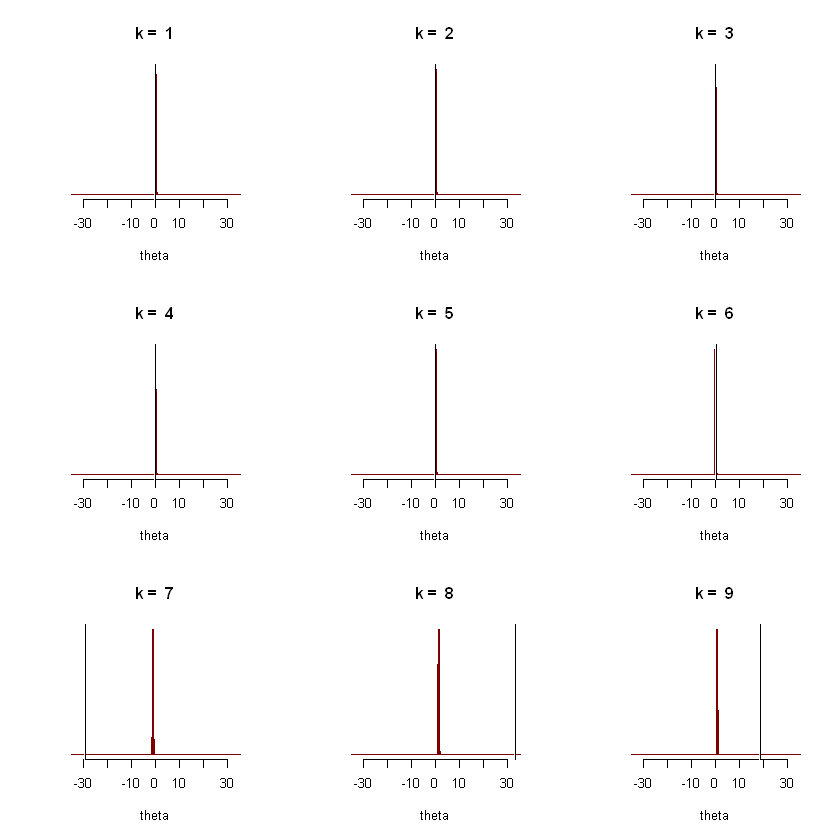

In [8]:
samples = extract(fit)

par(mfrow=c(3, 3))

for (k in 1:9) {
  hist(samples$theta[, k], breaks=seq(-35, 35, 0.25),
       main=paste("k = ", k), col=c_dark, border=c_dark_highlight,
       xlab="theta", yaxt='n', ylab="")
  abline(v=theta_true[k], col="white", lwd=2)
  abline(v=theta_true[k], col="black", lwd=1)
}

Now let's try fixing $\tau = 10$ to accommodate the larger values.



In [9]:
writeLines(readLines("stan_programs/normal_wide.stan"))

data {
  int<lower=0> K;                       // Number of contexts
  int<lower=0> N;                       // Number of observations
  vector[N] y;                          // Observations
  int<lower=1, upper=K> context_idx[N]; // Context assignments
  real<lower=0> sigma;                  // Measurement variability
}

parameters {
  // Horseshoe parameters
  vector[K] theta;
}

model {
  // Horseshoe prior model
  theta ~ normal(0, 10);
  
  // Observational model
  y ~ normal(theta[context_idx], sigma);
}


In [10]:
start.time <- Sys.time()

fit <- stan(file='stan_programs/normal_wide.stan', data=data,
            seed=4938483, refresh=1000)

end.time <- Sys.time()
computing.time <- end.time - start.time
computing.time

Time difference of 40.02682 secs

In [11]:
util$check_all_diagnostics(fit)

[1] "n_eff / iter looks reasonable for all parameters"
[1] "Rhat looks reasonable for all parameters"
[1] "0 of 4000 iterations ended with a divergence (0%)"
[1] "0 of 4000 iterations saturated the maximum tree depth of 10 (0%)"
[1] "E-FMI indicated no pathological behavior"


Again we have no signs of computational problems, and the weaker regularization
seems to allow the inferences for the larger parameters to reach the true
values.


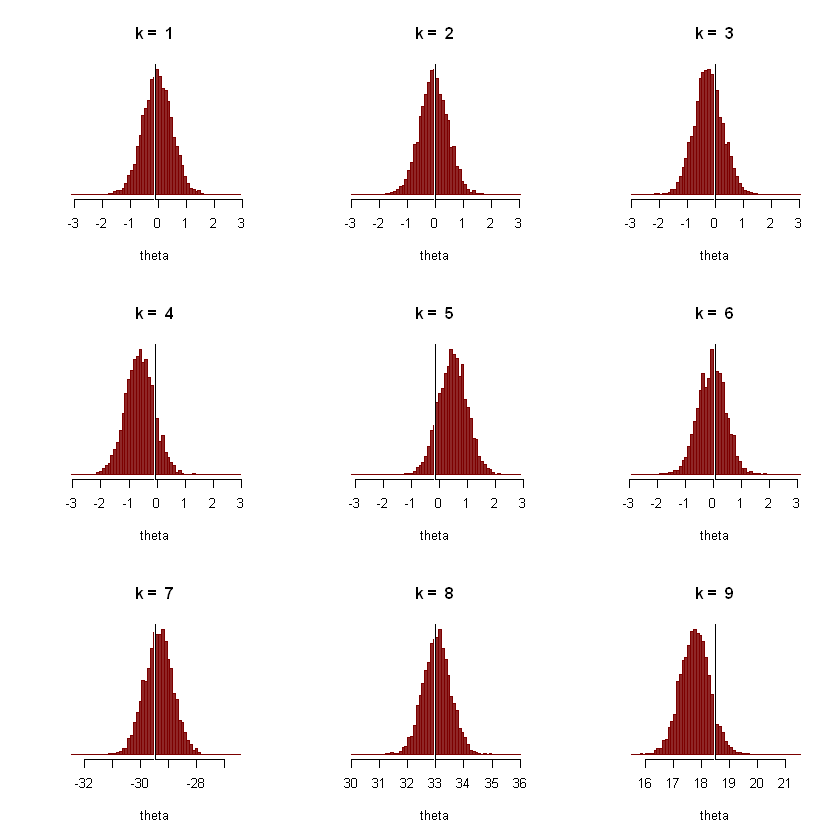

In [12]:
samples = extract(fit)

par(mfrow=c(3, 3))

for (k in 1:9) {
  hist(samples$theta[, k], breaks=seq(theta_true[k] - 3, theta_true[k] + 3, 0.1),
       main=paste("k = ", k), col=c_dark, border=c_dark_highlight,
       xlab="theta", yaxt='n', ylab="")
  abline(v=theta_true[k], col="white", lwd=2)
  abline(v=theta_true[k], col="black", lwd=1)
}

The inferences for the six smaller parameters, however, leaves much to be
desired.  Because the wide population model offers no regularization to these
inferences, each marginal posterior distribution is limited to the resolution
of the measurements $\sigma = 0.5$.  In particular the marginal posterior
distributions are much wider than the true inner scale, $0.1$.


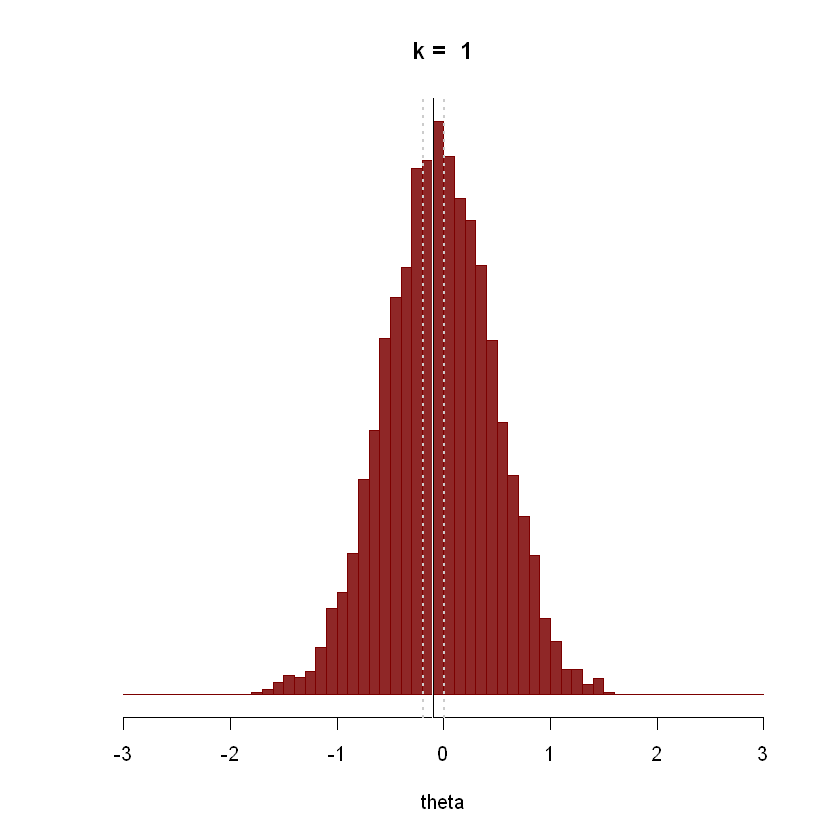

In [13]:
par(mfrow=c(1, 1))

k <- 1
hist(samples$theta[, k], breaks=seq(-3, 3, 0.1),
     main=paste("k = ", k), col=c_dark, border=c_dark_highlight,
     xlab="theta", yaxt='n', ylab="")
abline(v=theta_true[k], col="white", lwd=2)
abline(v=theta_true[k], col="black", lwd=1)

abline(v=theta_true[k] - 0.1, col="gray80", lwd=2, lty=3)
abline(v=theta_true[k] + 0.1, col="gray80", lwd=2, lty=3)

Finally let's investigate what happens when we infer the population scale along
with the individual parameters.  Our prior model for $\tau$ will be just large
enough to contain both the inner core scale and the outer extent scale.


In [14]:
writeLines(readLines("stan_programs/hier_normal_cp.stan"))

data {
  int<lower=0> K;                       // Number of contexts
  int<lower=0> N;                       // Number of observations
  vector[N] y;                          // Observations
  int<lower=1, upper=K> context_idx[N]; // Context assignments
  real<lower=0> sigma;                  // Measurement variability
}

parameters {
  // Horseshoe parameters
  vector[K] theta;
  real<lower=0> tau;
}

model {
  // Horseshoe prior model
  theta ~ normal(0, tau);
  tau ~ normal(0, 10);
  
  // Observational model
  y ~ normal(theta[context_idx], sigma);
}


In [15]:
start.time <- Sys.time()

fit <- stan(file='stan_programs/hier_normal_cp.stan', data=data,
            seed=4938483, refresh=1000)

util$check_all_diagnostics(fit)

end.time <- Sys.time()
computing.time <- end.time - start.time
computing.time

[1] "n_eff / iter looks reasonable for all parameters"
[1] "Rhat looks reasonable for all parameters"
[1] "0 of 4000 iterations ended with a divergence (0%)"
[1] "0 of 4000 iterations saturated the maximum tree depth of 10 (0%)"
[1] "E-FMI indicated no pathological behavior"


Time difference of 40.6347 secs

Because the normal population model is too rigid the posterior distribution is
forced to compromise between the scales of the inner core and outer extent.
Ultimately it ends up concentrating somewhere between the two in a feeble
attempt to balance the over and under-regularization.


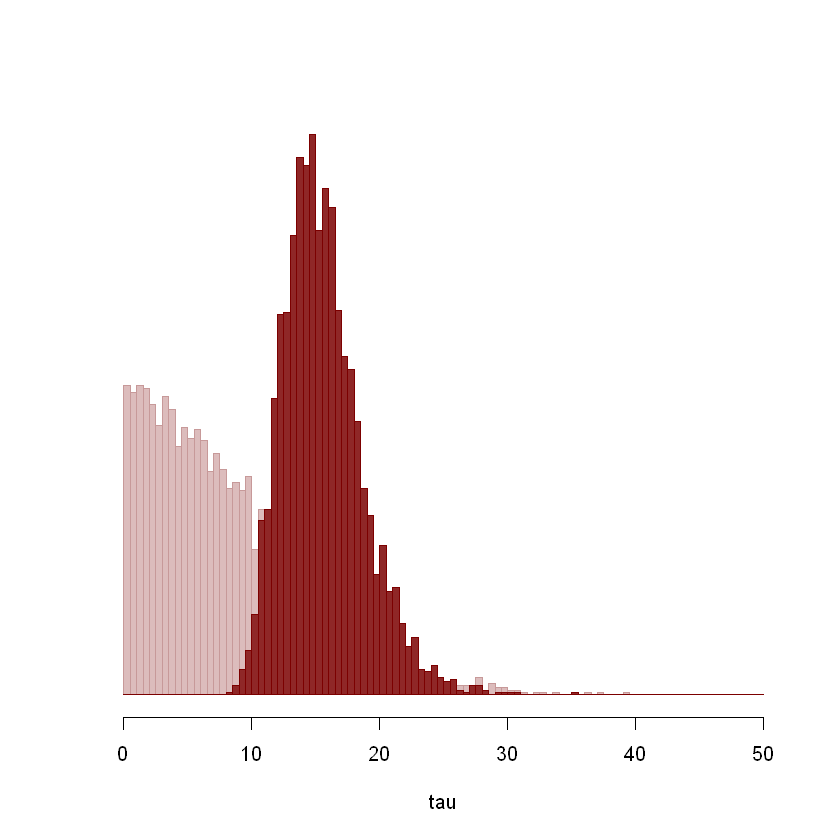

In [16]:
samples = extract(fit)

par(mfrow=c(1, 1))

hist(abs(rnorm(4000, 0, 10)), breaks=seq(0, 50, 0.5),
     main="", col=c_light, border=c_light_highlight,
     xlab="tau", yaxt='n', ylab="", ylim=c(0, 300))
hist(samples$tau, breaks=seq(0, 50, 0.5),
     main="", col=c_dark, border=c_dark_highlight, add=T)

This balance, however, is still too much large for the parameters with small
true values and a bit too small for the parameters with large true values.
Because the balance favors the larger scale the over-regularization isn't too
bad.


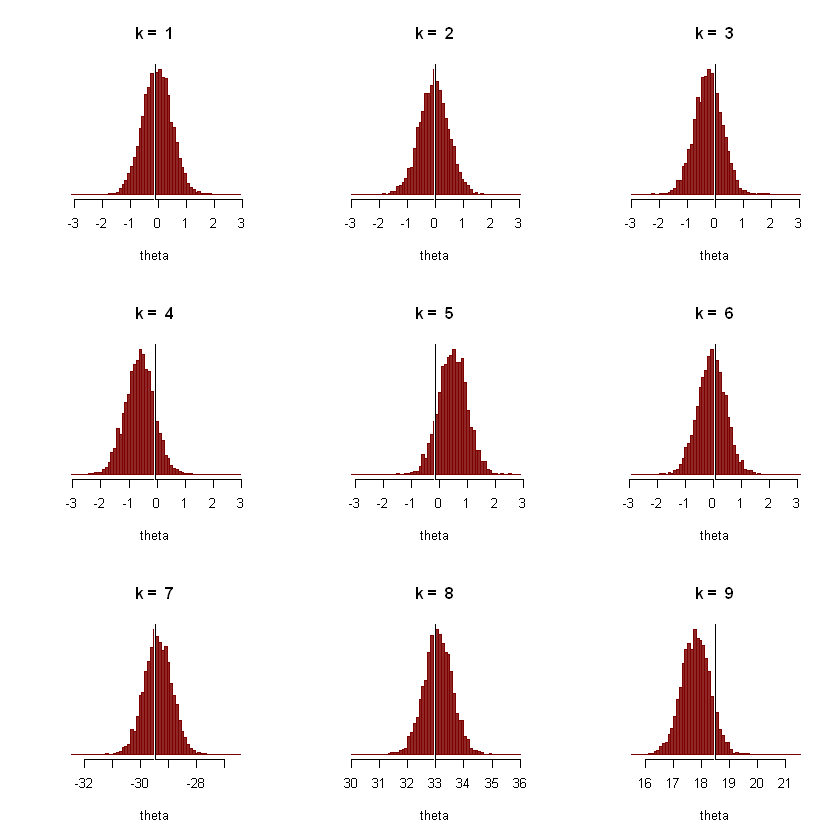

In [17]:
par(mfrow=c(3, 3))

for (k in 1:9) {
  hist(samples$theta[, k], seq(theta_true[k] - 3, theta_true[k] + 3, 0.1),
       main=paste("k = ", k), col=c_dark, border=c_dark_highlight,
       xlab="theta", yaxt='n', ylab="")
  abline(v=theta_true[k], col="white", lwd=2)
  abline(v=theta_true[k], col="black", lwd=1)
}

If we zoom in to one of the plots we can see the under-regularization of the
small parameters more clearly.  Because both $\tau$ and $\sigma$ are greater
than the inner core scale $0.1$ there is no information to concentrate the
posterior distribution to the smaller scale.


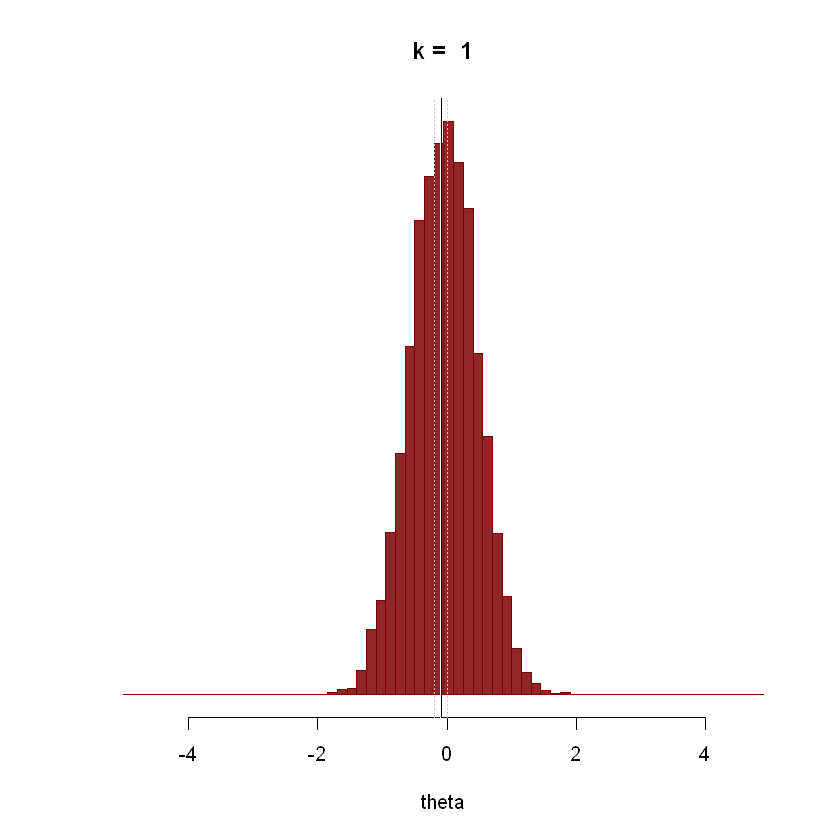

In [18]:
par(mfrow=c(1, 1))

k <- 1
hist(samples$theta[, k], breaks=seq(-5, 5, 0.15),
     main=paste("k = ", k), col=c_dark, border=c_dark_highlight,
     xlab="theta", yaxt='n', ylab="")

abline(v=theta_true[k], col="white", lwd=2)
abline(v=theta_true[k], col="black", lwd=1)

abline(v=theta_true[k] - 0.1, col="gray80", lwd=1, lty=3)
abline(v=theta_true[k] + 0.1, col="gray80", lwd=1, lty=3)

## Mixture Population Models

A single normal population model proved to be too rigid to accommodate
parameters clustering in both the inner core and outer extent at the same time,
but there's no reason why we have to consider only a _single_ normal population
model.  By mixing together multiple component population models our inferences
have the flexibility to associate individual contexts to different populations,
clustering the parameters into different groups as directed by the observed
data.  We can then encode sparsity as a preference for associating parameters
with the most narrow population.

### Discrete Mixture Models

The simplest mixture model to consider is a _discrete_ mixture model that
features only a finite number of component population models.

For example we might consider mixing a Dirac distribution that concentrates
entirely on zero with a wider distribution to accommodate non-zero parameter
values.

<div><center><table class="image">
<caption align="top"><h2>Spike and slab density</h2></caption>
<tr><td><img src="figures/spike_and_slab/density.png" width="400"></td></tr>
</table></center></div>   

The hope is that parameters with likelihood functions concentrating near zero
would collapse to the _spike_ at zero while those with likelihood functions
concentrating further away are more likely to be allocated to the non-zero
_slab_.  By inflating each $\theta_{k} = 0$ to have a non-zero probability this
_spike and slab_ population model [@MitchellEtAl:1988] is theoretically able to
infer exact zeros and not just small values.  Unfortunately because of the
infinity of small but not-quite-zero values this population model requires
special computational methods to transitioning between the spike and slab
components in finite time.  Even these special methods, however, often struggle
to accurately quantify the posterior probabilities of each component in
practice.

If we embrace irrelevant values instead of exact zero values then we can replace
the spike with a narrow population model that concentrates around zero with
scale $\tau_{1}$.  A second, wider normal population model with scale
$\tau_{2} > \tau_{1}$ then accommodates the outer core.

<div><center><table class="image">
<caption align="top"><h2>Normal mixture</h2></caption>
<tr><td><img src="figures/normal_mixture/density.png" width="400"></td></tr>
</table></center></div>   

Each individual parameter $\theta_{k}$ is equipped with a mixture probability
$\lambda_{k}$ that quantifies how consistent the parameter is with the narrower
population model,

$$
    \pi(\theta_{k} \mid \tau_{1}, \tau_{2}, \lambda_{k})
    =\lambda_{k} \cdot \text{normal}(\theta_{k} \mid 0, \tau_{1} )
    + (1 - \lambda_{k}) \cdot \text{normal}(\theta_{k} \mid 0, \tau_{2} ).
$$

<div><center><table class="image">
<caption align="top"><h2>Discrete mixture</h2></caption>
<tr><td><img src="figures/dgms/discrete_mixture/discrete_mixture.png" width="400"></td></tr>
</table></center></div>   

When the marginal posterior distribution for a $\lambda_{k}$ concentrates
towards one then the corresponding $\theta_{k}$ will be more strongly
regularized by the narrow component population model.  In other words the
individual parameter effectively decouples from the wide component population
model.

<div><center><table class="image">
<caption align="top"><h2>Discrete mixture 1</h2></caption>
<tr><td><img src="figures/dgms/discrete_mixture/discrete_mixture1.png" width="400"></td></tr>
</table></center></div>   

On the other hand if the posterior distribution for a $\lambda_{k}$ concentrates
towards zero then the corresponding $\theta_{k}$ will effectively decouple from
the narrow population model and be regularized by only the wide population
model.

<div><center><table class="image">
<caption align="top"><h2>Discrete mixture 2</h2></caption>
<tr><td><img src="figures/dgms/discrete_mixture/discrete_mixture2.png" width="400"></td></tr>
</table></center></div>   

We can then encode sparsity with a prior model on each $ \lambda_{k}$ that
concentrates towards one.  The stronger this concentration the more an
individual likelihood function has to concentrate above $\tau_{1}$ for
$\theta_{k}$ to be decouple from the narrow population model and escape the
strong regularization towards the inner core.

A mixture probability for each $\theta_{k}$ introduces a significant number of
new parameters, and those parameters introduce opportunities for degeneracies
that can frustrate computational efficiency.  If we use a beta prior model for
the mixture probabilities, however, then we can actually marginalize them out of
the model analytically,

$$
\begin{align*}
&\int \mathrm{d} \lambda_{k} \,
\pi(\theta_{k} \mid \tau_{1}, \tau_{2}, \lambda_{k} ) \,
\text{beta}(\lambda_{k} \mid \alpha, \beta)
\\[0.3cm]
&\quad =
\int \mathrm{d} \lambda_{k} \,
\left[ \lambda_{k} \cdot \text{normal}(\theta_{k} \mid 0, \tau_{1} )
+ (1 - \lambda_{k}) \cdot \text{normal}(\theta_{k} \mid 0, \tau_{2} ) \right] \,
\text{beta}(\lambda_{k} \mid \alpha, \beta)
\\[0.3cm]
&\quad =
\left[ \int \mathrm{d} \lambda_{k} \,
\text{beta}(\lambda_{k} \mid \alpha, \beta) \, \lambda_{k} \right]
\text{normal}(\theta_{k} \mid 0, \tau_{1} )
+
\left(1 -
\left[ \int \mathrm{d} \lambda_{k} \,
\text{beta}(\lambda_{k} \mid \alpha, \beta) \, \lambda_{k}) \right]
\right)
\text{normal}(\theta_{k} \mid 0, \tau_{2} )
\\[0.3cm]
&\quad =
\frac{\alpha}{\alpha + \beta}
\text{normal}(\theta_{k} \mid 0, \tau_{1} )
+ (1 - \frac{\alpha}{\alpha + \beta} )
\text{normal}(\theta_{k} \mid 0, \tau_{2} ).
\end{align*}
$$

With only this particular ratio of $\alpha$ and $\beta$ persisting into the
marginal density function our domain expertise does not need to specify both
parameters but just the ratio

$$
    \gamma = \frac{\alpha}{\alpha + \beta}.
$$

In this case we can replace the discrete mixture population model with the
marginal population model

$$
    \pi(\theta_{k} \mid \tau_{1}, \tau_{2}) 
        =\gamma \cdot \text{normal}(\theta_{k} \mid 0, \tau_{1} )
        + (1 - \gamma ) \cdot \text{normal}(\theta_{k} \mid 0, \tau_{2} ).
$$

Because $\gamma$ is the same for _all_ of the individual contexts we have
replaced the $k$ mixture parameters with a single new parameter.  In this
context we can interpret $\gamma$ as the proportion of the total observed
contexts that are expected to be consistent with the narrow population model as
opposed to the wide population model.

<div><center><table class="image">
<caption align="top"><h2>Discrete mixture marginal</h2></caption>
<tr><td><img src="figures/dgms/discrete_mixture/discrete_mixture_marginal.png" width="400"></td></tr>
</table></center></div>   

As before let's investigate the properties of this discrete mixture population
model by fixing the scales and consider how this prior model affect the
posterior mean and standard deviation relative to an improper uniform prior
density function.  To start let's assume that $\tau_{1} < \sigma < \tau_{2}$.

Although each component normal model induces uniform regularization their
mixture does not when the measurement variability can resolve differences
between the component scales.  When the likelihood function concentrates near
and below the narrower scale $\tau_{1}$ the posterior distribution couples to
the narrow population model; the mean is strongly regularized towards zero and
the standard deviation narrows because of the information provided by the prior
model.  In between $\tau_{1}$ and $\tau_{2}$ the regularization of the posterior
mean weakens and the posterior standard deviation actually expands towards
$\tau_{2}$!  Finally when the likelihood function concentrates closer to
$\tau_{2}$ it decouples from the narrow population model entirely.  If
$\tau_{2}$ is much wider than the width of the likelihood function, as is the
case here, then the wide population model behaves almost exactly like an
improper uniform prior model.

<div><center><table class="image">
<caption align="top"><h2>Normal mixture cumulant shrinkage</h2></caption>
<tr><td><img src="figures/shrinkage/normal_mixture/normal_mixture_cumulant_shrinkage.png" width="800"></td></tr>
</table></center></div>   

Because of this multi-scale regularization the discrete mixture population model
can accommodate both the inner core and the outer extend implied by the sparsity
assumption.  When an individual likelihood function is wide the marginal
posterior distribution for $\theta_{k}$ will be informed by both component
population models, allocating most of its probability within the inner core but
spreading some across the outer extent.  If an individual likelihood function is
narrow and concentrates at values near $\tau_{1}$ then the narrow population
model dominates and the marginal posterior distribution is strongly regularized
into the inner core.  On the other hand if the individual likelihood function is
narrow and concentrates at values above $\tau_{1}$ then the wide population
model governs, allowing the marginal posterior distribution to be determined
mostly by the individual likelihood function.

<div><center><table class="image">
<caption align="top"><h2>Normal mixture density shrinkage</h2></caption>
<tr><td><img src="figures/shrinkage/normal_mixture/normal_mixture_density_shrinkage.png" width="800"></td></tr>
</table></center></div>   

When $\sigma < \tau_{2}$ the wide population model has little effect on the
marginal posterior distributions, but it becomes much more important when
$\sigma > \tau_{2}$.  In this case the narrow population model affects the
posterior distribution only negligibly and the wide population model becomes
responsible for all regularization.

As an individual likelihood function concentrates at values above $\tau_{2}$
the regularization of the mean and standard deviation weakens until it reaches
the uniform regularization of $\tau_{2}$ that extends to arbitrarily large
values.

<div><center><table class="image">
<caption align="top"><h2>Normal mixture outer cumulant shrinkage</h2></caption>
<tr><td><img src="figures/shrinkage/normal_mixture/normal_mixture_outer_cumulant_shrinkage.png" width="700"></td></tr>
</table></center></div>   

This outer regularization is particularly important when an individual
likelihood function suppresses zero but otherwise extends far past $\tau_{2}$.
Because the likelihood function suppresses zero the narrow population model has
no affect on the corresponding marginal posterior distribution, and only the
wide population model prevents the posterior distribution from extending above
$\tau_{2}$.

<div><center><table class="image">
<caption align="top"><h2>Normal mixture density shrinkage</h2></caption>
<tr><td><img src="figures/shrinkage/outer/normal_mixture_density_shrinkage.png" width="400"></td></tr>
</table></center></div>  

To investigate the behavior of this prior model when the scales $\tau_{1}$ and
$\tau_{2}$ are not fixed let's fit the data that we simulated earlier in Stan.
We begin with a monolithically centered parameterization and a prior model
for $\tau_{1}$ and $\tau_{2}$ that constrains them to be near the scales of the
inner core and outer extent.  To encode our sparsity assumption we'll use a
$\text{beta}(3, 1)$ prior density function for $\gamma$ that allocates $0.875$
of its total probability above $\gamma = 0.5$.

In [19]:
writeLines(readLines("stan_programs/hier_normal_mixture_cp.stan"))

data {
  int<lower=0> K;                       // Number of groups
  int<lower=0> N;                       // Number of observations
  vector[N] y;                          // Observations
  int<lower=1, upper=K> context_idx[N]; // Context assignments
  real<lower=0> sigma;                  // Measurement variability
}

parameters {
  vector[K] theta;
  
  real<lower=0, upper=1> gamma;
  real<lower=0> tau1;
  real<lower=tau1> tau2;
}

model {
  for (k in 1:K)
    target += log_mix(gamma,
                      normal_lpdf(theta[k] | 0, tau1), 
                      normal_lpdf(theta[k] | 0, tau2));
  
  gamma ~ beta(3, 1);
  tau1 ~ normal(0, 0.1);
  tau2 ~ normal(0, 10);

  // Observational model
  y ~ normal(theta[context_idx], sigma);
}


In [20]:
start.time <- Sys.time()

fit <- stan(file='stan_programs/hier_normal_mixture_cp.stan', data=data,
            seed=4938483, refresh=1000)

end.time <- Sys.time()
computing.time <- end.time - start.time
computing.time

Warning message:
"There were 3 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them."
Warning message:
"Examine the pairs() plot to diagnose sampling problems
"
Warning message:
"Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess"
Warning message:
"Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#tail-ess"


Time difference of 42.34361 secs

In [21]:
util$check_all_diagnostics(fit)

[1] "n_eff / iter looks reasonable for all parameters"
[1] "Rhat looks reasonable for all parameters"
[1] "3 of 4000 iterations ended with a divergence (0.075%)"
[1] "  Try running with larger adapt_delta to remove the divergences"
[1] "0 of 4000 iterations saturated the maximum tree depth of 10 (0%)"
[1] "E-FMI indicated no pathological behavior"


Just like divergent transitions to show up and ruin the party.  Let's go find
where they're hiding.


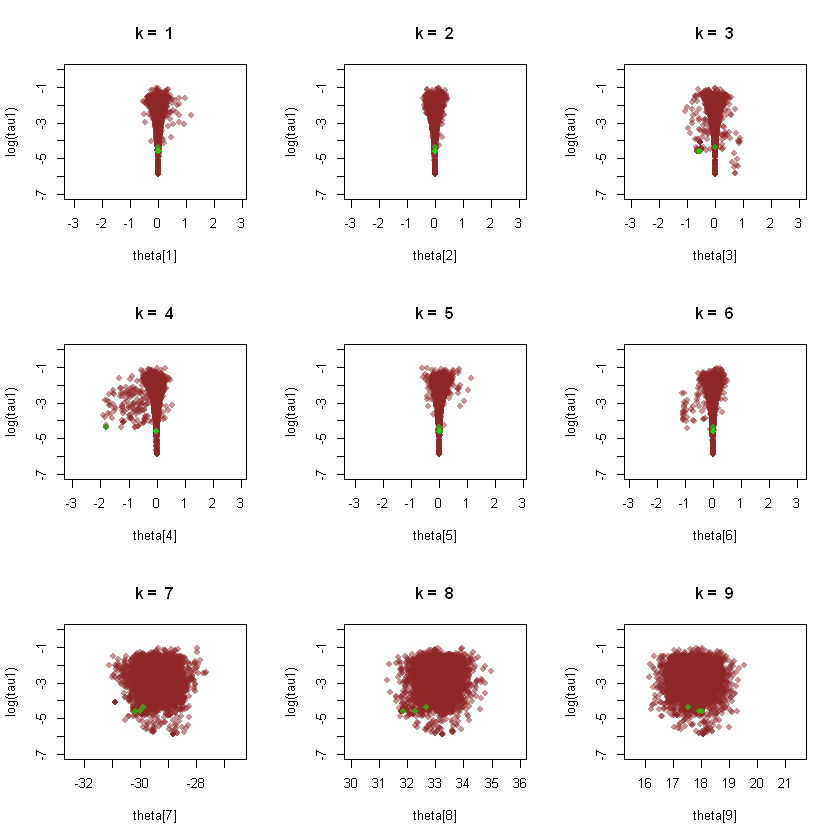

In [22]:
partition <- util$partition_div(fit)
div_params <- partition[[1]]
nondiv_params <- partition[[2]]

par(mfrow=c(3, 3))

for (k in 1:9) {
  name_x <- paste("theta[", k, "]", sep='')
  name_y <- "tau1"

  plot(nondiv_params[name_x][,1], log(nondiv_params[name_y][,1]),
       col=c_dark_trans, pch=16, main=paste("k = ", k),
       xlab=name_x, xlim=c(theta_true[k] - 3, theta_true[k] + 3),
       ylab=paste("log(", name_y, ")", sep=""), ylim=c(-7, 0))
  points(div_params[name_x][,1], log(div_params[name_y][,1]),
         col=c_green_trans, pch=16)
}

The posterior interactions for all of the six parameters with small true values
and $\tau_{1}$ exhibit strong funnel geometries.  This indicates that the
hierarchical prior model is dominating the structure of the posterior
distribution here.  Interestingly the posterior behavior for the three
parameters with large true values shows no indications of a funnel despite the
individual likelihood functions having the same exact shape!

On the other hand none of the parameters exhibit any funnel behavior with
respect to the wider scale, $\tau_{2}$.


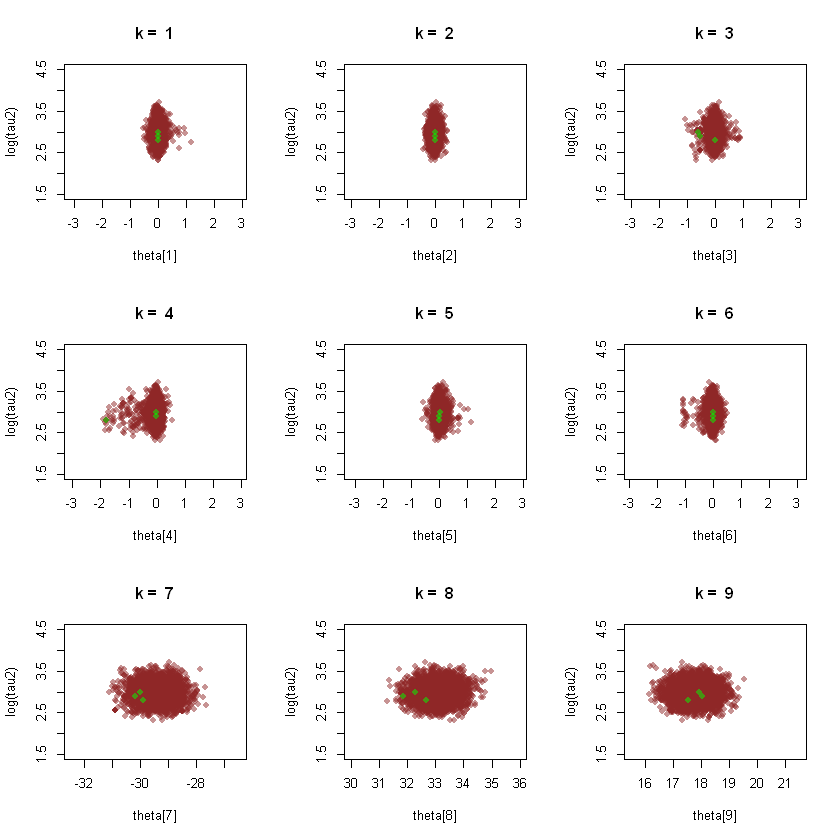

In [23]:
par(mfrow=c(3, 3))

for (k in 1:9) {
  name_x <- paste("theta[", k, "]", sep='')
  name_y <- "tau2"

  plot(nondiv_params[name_x][,1], log(nondiv_params[name_y][,1]),
       col=c_dark_trans, pch=16, main=paste("k = ", k),
       xlab=name_x, xlim=c(theta_true[k] - 3, theta_true[k] + 3),
       ylab=paste("log(", name_y, ")", sep=""), ylim=c(1.5, 4.5))
  points(div_params[name_x][,1], log(div_params[name_y][,1]),
         col=c_green_trans, pch=16)
}

Why are the funnels manifesting only in the parameters with small true values?
Recall that a centered parameterization of an individual parameter is optimal
when the corresponding individual likelihood function is more informative than
the population model, and a non-centered parameterization is optimal when the
population model is more informative.  When the population model is specified
by a single normal probability density function the dominant contribution is
largely determined by the _width_ of the individual likelihood function relative
to the width of the normal population model, but not its _location_.

When we mix multiple normal population models together, however, the location
of the individual likelihood function also matters.  If an individual likelihood
function concentrates near or below $\tau_{1}$ then the narrow population model
will dominate the behavior of the marginal posterior distribution, and a
non-centered parameterization of the corresponding $\theta_{k}$ is needed to
avoid a funnel geometry.  On the other hand if the individual likelihood
function concentrates above $\tau_{1}$ then it will contribute to the posterior
distribution much more strongly than the wide population model in which case a
centered parameterization of $\theta_{k}$ will ensure the best posterior
geometry.

Indeed this variation between whether the population model or an individual
likelihood function dominates the posterior distribution is arguably the best
way to understand sparsity in a Bayesian analysis.  A population model is sparse
if it dominates the the marginal posterior distribution for most of the
parameters, with only a few marginal posterior distributions strongly informed
by the corresponding individual likelihood functions!

Because we don't know which individual likelihood functions will concentrate
near and below $ \tau_{1}$ and which will concentrate at much larger values we
cannot determine an optimal parameterization a priori.  In particular because
the location of the individual likelihood function matters as much as its width
the number of observations in each context isn't as helpful of a heuristic as
it is when implementing hierarchical models with a single normal population
model.  Instead our best practice is to start with a monolithically non-centered
parameterization, consistent with our domain expertise that the marginal
posterior distribution for most of the parameters should be dominated by the
narrow population model, and then center any individual parameters that exhibit
inverted funnels in the initial fit.

A final complication is exactly how to implement a non-centered
parameterization.  In a mixture model we have to transform all of the component
density functions at the same time, which means that we have to rescale _both_
the narrow and wide population models by the same variable, in particular
either $\tau_{1}$ or $\tau_{2}$.  The three parameters with large values inform
$\tau_{2}$ is sufficiently well to suppress any pathological interactions with
$\tau_{2}$ which leaves non-centering with respect to $\tau_{1}$ as the natural
approach,

$$
    \begin{align*}
    \pi(\tilde{\theta}_{k} \mid \tau_{1}, \tau_{2})
    &= \gamma \cdot
    \text{normal} \Big( \tilde{\theta}_{k} \mid 0, 1 \Big)
    + (1 - \gamma) \cdot
    \text{normal} \Big( \tilde{\theta}_{k} \mid 0, \frac{\tau_{2}}{\tau_{1}} \Big)
    \\
    \theta &= \tau_{1} \cdot \tilde{\theta}_{k}.
    \end{align*}
$$

Unfortunately while reparameterization simplifies the geometry of the first
component density function it induces an inverted funnel in the second!  Even if
$\tau_{2}$ is fixed the second component density function will widen as
$\tau_{1}$ decreases and narrow as $\tau_{1}$ increases.  The mixture density
function will overlay the pleasant geometry of the first component with the
more pathological geometry of the second component.

<div><center><table class="image">
<caption align="top"><h2>Normal mixture funnels</h2></caption>
<tr><td><img src="figures/normal_mixture_funnels/funnels.png" width="800"></td></tr>
</table></center></div>

If an individual likelihood function strongly concentrates within one of the
population components then only one of these components will propagate to the
posterior distribution and we can determine an optimal parameterization
accordingly.  When an individual likelihood function is wide enough to overlap
both components, however, then it will exhibit a plateau that is sensitive to
this inverted funnel geometry.

<div><center><table class="image">
<caption align="top"><h2>Normal mixture plateau</h2></caption>
<tr><td><img src="figures/normal_mixture_plateau/normal_mixture_plateau.png" width="800"></td></tr>
</table></center></div>

In this case our best strategy is to utilize a _partial_ non-centering,

$$
\theta = \tau_{1}^{1 - w_{k}} \cdot \tilde{\theta}_{k}.
    $$
with

$$
    \begin{align*}
    \pi(\tilde{\theta}_{k} \mid \tau_{1}, \tau_{2})
    &= \gamma \cdot
    \text{normal} \Big( \tilde{\theta}_{k} \mid 0, \frac{\tau_{1}}{\tau_{1}^{1-w_{k}}} \Big)
    + (1 - \gamma) \cdot
    \text{normal} \Big( \tilde{\theta}_{k} \mid 0, \frac{\tau_{2}}{\tau_{1}^{1-w_{k}}} \Big)
    \\[0.3cm]
    &= \gamma \cdot
    \text{normal} \Big( \tilde{\theta}_{k} \mid 0, \tau_{1}^{w_{k}} \Big)
    + (1 - \gamma) \cdot
    \text{normal} \Big( \tilde{\theta}_{k} \mid 0, \tau_{1}^{w_{k} - 1} \cdot \tau_{2} \Big).
    \end{align*}
$$

As $w_{k}$ approaches zero the parameterization becomes a full non-centering
with respect to $\tau_{1}$, with the first component exhibiting an ideal
geometry and the second exhibiting a strong inverted funnel.  As $w_{k}$
increases towards one the pathological behavior shifts over to the first
component.

In [24]:
writeLines(readLines("stan_programs/hier_normal_mixture_partial.stan"))

data {
  int<lower=0> K;                       // Number of groups
  int<lower=0> N;                       // Number of observations
  vector[N] y;                          // Observations
  int<lower=1, upper=K> context_idx[N]; // Context assignments
  vector<lower=0, upper=1>[K] w;        // Partial centering parameters

  real<lower=0> sigma;                  // Measurement variability
}

parameters {
  vector[K] theta_tilde;
  
  real<lower=0, upper=1> gamma;
  real<lower=0> tau1;
  real<lower=tau1> tau2;
}

transformed parameters {
  vector[K] theta;
  for (k in 1:K)
    theta[k] = pow(tau1, 1 - w[k]) * theta_tilde[k];
}

model {
  for (k in 1:K) {
    target += log_mix(gamma,
                      normal_lpdf(theta_tilde[k] | 0, pow(tau1, w[k])), 
                      normal_lpdf(theta_tilde[k] | 0, pow(tau1, w[k] - 1) * tau2));
  }
  
  gamma ~ beta(3, 1);
  tau1 ~ normal(0, 0.1);
  tau2 ~ normal(0, 10);

  // Observational model
  y ~ normal(theta[context_idx], sigma);
}


Because we already know that the individual likelihood functions for the last
three contexts concentrate at larger values so let's keep those centered while
fully non-centering the rest.


In [25]:
data$w <- c(0, 0, 0,
            0, 0, 0,
            1, 1, 1)

In [26]:
start.time <- Sys.time()

fit <- stan(file='stan_programs/hier_normal_mixture_partial.stan',
            data=data, seed=4938483, refresh=1000)

end.time <- Sys.time()
computing.time <- end.time - start.time
computing.time

Warning message:
"There were 1 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them."
Warning message:
"Examine the pairs() plot to diagnose sampling problems
"


Time difference of 42.58825 secs

Unfortunately the diagnostics indicate that the full non-centering doesn't yield
a nice enough posterior geometry.


In [27]:
util$check_all_diagnostics(fit)

[1] "n_eff / iter looks reasonable for all parameters"
[1] "Rhat looks reasonable for all parameters"
[1] "1 of 4000 iterations ended with a divergence (0.025%)"
[1] "  Try running with larger adapt_delta to remove the divergences"
[1] "0 of 4000 iterations saturated the maximum tree depth of 10 (0%)"
[1] "E-FMI indicated no pathological behavior"


Indeed we can see evidence of inverted funnel geometries in the first six
components.


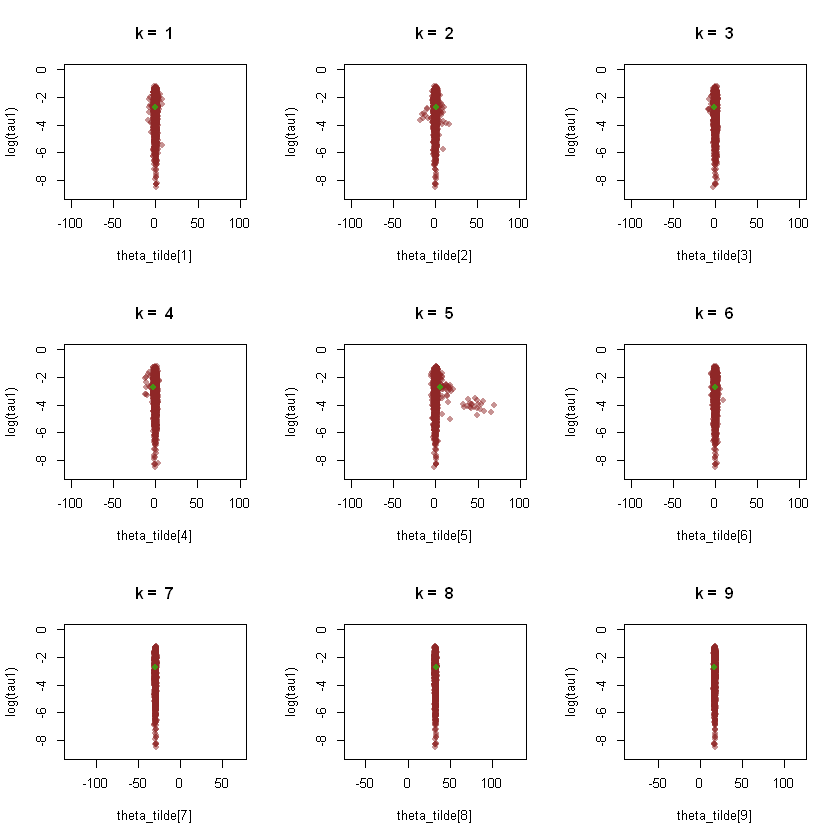

In [28]:
partition <- util$partition_div(fit)
div_params <- partition[[1]]
nondiv_params <- partition[[2]]

par(mfrow=c(3, 3))

for (k in 1:9) {
  name_x <- paste("theta_tilde[", k, "]", sep='')
  name_y <- "tau1"

  plot(nondiv_params[name_x][,1], log(nondiv_params[name_y][,1]),
       col=c_dark_trans, pch=16, main=paste("k = ", k),
       xlab=name_x, xlim=c(theta_true[k] - 100, theta_true[k] + 100),
       ylab=paste("log(", name_y, ")", sep=""), ylim=c(-9, 0))
  points(div_params[name_x][,1], log(div_params[name_y][,1]),
         col=c_green_trans, pch=16)
}

To avoid these extreme tails let's decreasing the non-centering of those
context a bit.


In [29]:
data$w <- c(0.2, 0.2, 0.2,
            0.2, 0.2, 0.2,
            1, 1, 1)

In [30]:
start.time <- Sys.time()

fit <- stan(file='stan_programs/hier_normal_mixture_partial.stan',
            data=data, seed=4938483, refresh=1000)

end.time <- Sys.time()
computing.time <- end.time - start.time
computing.time

Time difference of 6.540039 secs

In [31]:
util$check_all_diagnostics(fit)

[1] "n_eff / iter looks reasonable for all parameters"
[1] "Rhat looks reasonable for all parameters"
[1] "0 of 4000 iterations ended with a divergence (0%)"
[1] "0 of 4000 iterations saturated the maximum tree depth of 10 (0%)"
[1] "E-FMI indicated no pathological behavior"


Voilá!  There are no longer any divergent transitions indicating inaccurate
computation and there are no signs of funnels in the posterior distribution.

Now that we can trust our computation we can investigate our inferences.


In [32]:
samples = extract(fit)

First the marginal mixture probability $\gamma$ concentrates around $0.66$,
which makes sense given that two-thirds of the observed contexts are consistent
with the inner core.


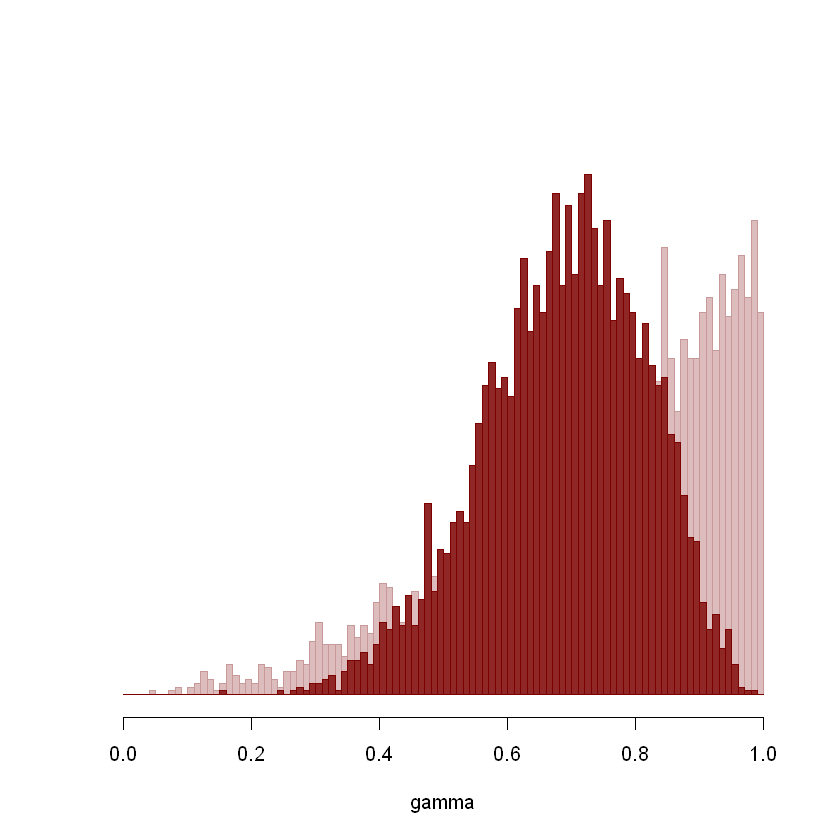

In [33]:
par(mfrow=c(1, 1))

hist(abs(rbeta(4000, 3, 1)), breaks=seq(0, 1, 0.01),
     main="", col=c_light, border=c_light_highlight,
     xlab="gamma", yaxt='n', ylab="", ylim=c(0, 150))
hist(samples$gamma, breaks=seq(0, 1, 0.01),
     main="", col=c_dark, border=c_dark_highlight, add=T)

What about the population scales?  The data informs $\tau_{2}$ reasonably well
but we don't learn much about $\tau_{1}$ beyond what was already encoded in the
prior model.  In hindsight this isn't surprising because the measurement
variability $\sigma = 0.5$ prevents the likelihood functions from resolving
scales that small.


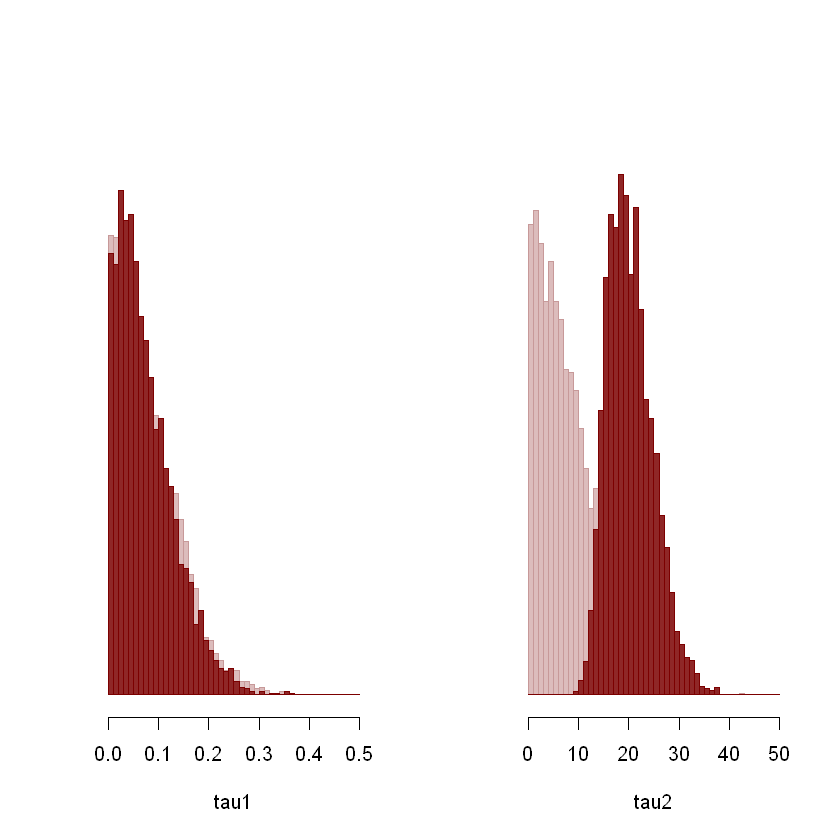

In [34]:
samples = extract(fit)

par(mfrow=c(1, 2))

hist(abs(rnorm(4000, 0, 0.1)), breaks=seq(0, 0.5, 0.01),
     main="", col=c_light, border=c_light_highlight,
     xlab="tau1", yaxt='n', ylab="", ylim=c(0, 400))
hist(samples$tau1, breaks=seq(0, 0.5, 0.01),
     main="", col=c_dark, border=c_dark_highlight, add=T)

hist(abs(rnorm(4000, 0, 10)), breaks=seq(0, 50, 1),
     main="", col=c_light, border=c_light_highlight,
     xlab="tau2", yaxt='n', ylab="", ylim=c(0, 400))
hist(samples$tau2, breaks=seq(0, 50, 1),
     main="", col=c_dark, border=c_dark_highlight, add=T)

Most importantly this mixture strategy provides the flexibility needed to
recover all of the parameters as well as possible.  The first six parameters
are regularized towards the inner core, narrowing beyond the measurement
resolution $\sigma = 0.5$ due to our prior knowledge constraining
$\tau_{1} \lessapprox 0.1$.  This strong regularization, however, does not
affect the inference of the last three parameters which are able to concentrate
on the much larger true values.


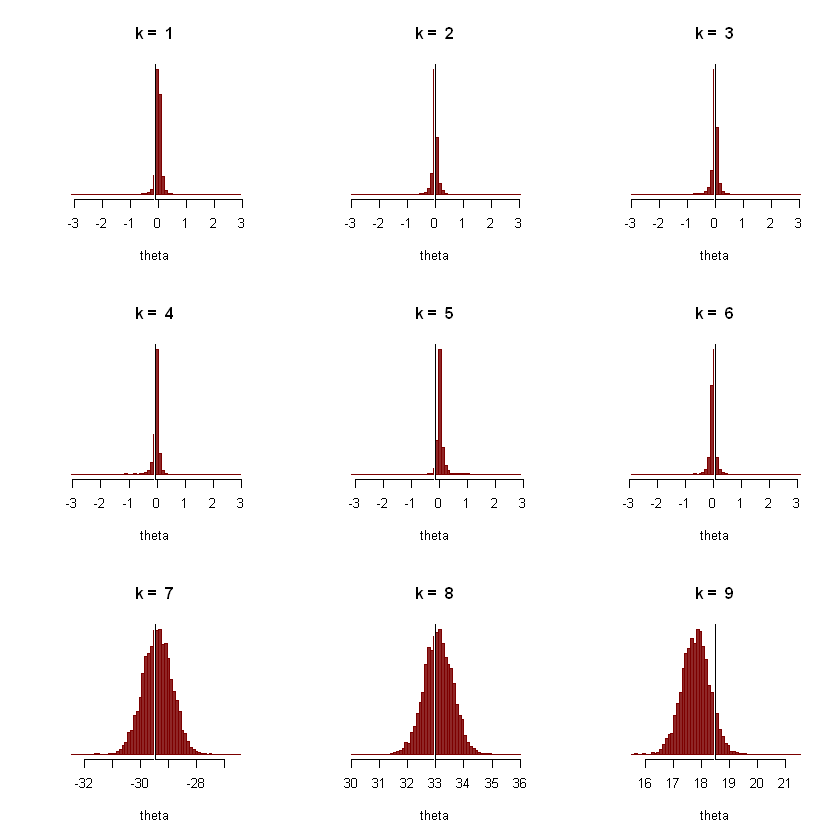

In [35]:
par(mfrow=c(3, 3))

for (k in 1:9) {
  hist(samples$theta[, k], breaks=seq(theta_true[k] - 3, theta_true[k] + 3, 0.1),
       main=paste("k = ", k), col=c_dark, border=c_dark_highlight,
       xlab="theta", yaxt='n', ylab="")
  abline(v=theta_true[k], col="white", lwd=2)
  abline(v=theta_true[k], col="black", lwd=1)
}

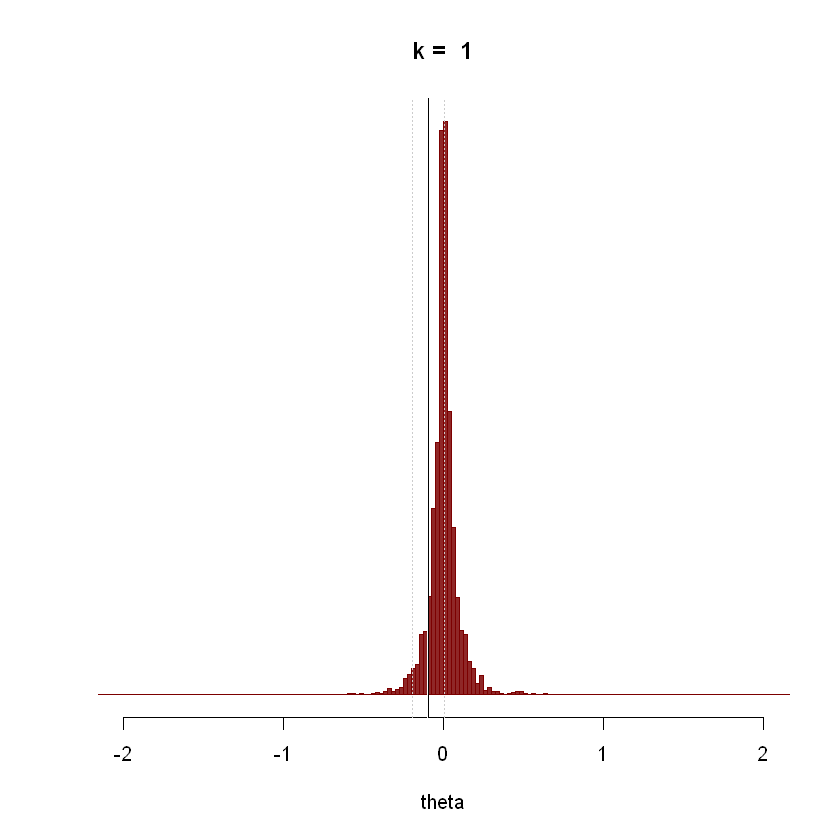

In [36]:
par(mfrow=c(1, 1))

k <- 1
hist(samples$theta[, k], breaks=seq(-3, 3, 0.025),
     main=paste("k = ", k), col=c_dark, border=c_dark_highlight,
     xlab="theta", xlim=c(-2, 2), yaxt='n', ylab="")
abline(v=theta_true[k], col="white", lwd=2)
abline(v=theta_true[k], col="black", lwd=1)

abline(v=theta_true[k] - 0.1, col="gray80", lwd=1, lty=3)
abline(v=theta_true[k] + 0.1, col="gray80", lwd=1, lty=3)

### Continuous Mixture Models

A discrete mixture model combines a finite number of normal population models,
each capturing some segment of the total population.  Mathematically, however,
we are not limited to just a finite number of component populations.  We can
also consider an _infinite_ number of normal population models by introducing a
scale parameter for each individual context, $\lambda_{k}$, and a population
model for those new parameters,

$$
    \pi(\theta_{k}, \lambda_{k} \mid \phi)
    =
    \text{normal}(\theta_{k} \mid 0, \lambda_{k}) \,
    \pi(\lambda_{k} \mid \phi).
$$

In other words these _continuous_ mixture models push back the hierarchy one
layer deeper, pooling not the $\theta_{k}$ together directly but rather the
individual population scales, $\lambda_{k}$.

<div><center><table class="image">
<caption align="top"><h2>Continuous mixture</h2></caption>
<tr><td><img src="figures/dgms/continuous_mixture/continuous_mixture.png" width="400"></td></tr>
</table></center></div>

This additional flexibility afforded by the individual $\lambda_{k}$ allows each
context to more easily accommodate each individual likelihood functions.  For
example when $\lambda_{k} \approx 0$ the individual parameter $\theta_{k}$ is
strongly regularized to zero no matter the shape of the individual likelihood
function.

<div><center><table class="image">
<caption align="top"><h2>Continuous mixture small</h2></caption>
<tr><td><img src="figures/dgms/continuous_mixture/continuous_mixture_small.png" width="400"></td></tr>
</table></center></div>

On the other hand if $\lambda_{k} \gg 0$ then the corresponding $\theta_{k}$ is
regularized much more weakly.  As $\lambda_{k}$ approaches infinity $\theta_{k}$
eventually decouples from the prior model entirely and the individual
contribution to the posterior distribution will be completely determined by the
individual likelihood function.

<div><center><table class="image">
<caption align="top"><h2>Continuous mixture large</h2></caption>
<tr><td><img src="figures/dgms/continuous_mixture/continuous_mixture_large.png" width="400"></td></tr>
</table></center></div>

It is often more mathematically convenient to model not the population scales
but rather their squares, the population variances,

$$
    \pi(\theta_{k}, \omega_{k} \mid \phi)
    =
    \text{normal}(\theta_{k} \mid 0, \sqrt{\omega_{k}}) \,
    \pi(\omega_{k} \mid \phi).
$$

The affect of the prior model, however, will be equivalent provided that
$ \pi(\lambda_{k} \mid \phi)$ is transformed into $\pi(\omega_{k} \mid \phi)$
appropriately.

In this section we will consider three different models for the population
scales and investigate how they contribute to sparse inferences.

#### Laplace Population Model

Perhaps the simplest probabilistic model for the population variances is given
by an exponential probability density function,

$$
    \pi(\omega_{k} \mid \phi)
    = \text{exponential}(\omega_{k} \mid \phi)
    = \phi \, e^{-\phi \, \omega_{k}}.
$$

<div><center><table class="image">
<caption align="top"><h2>Exp density</h2></caption>
<tr><td><img src="figures/laplace/exp_density.png" width="400"></td></tr>
</table></center></div>

This model allocates most of its probability below $3 \phi$ or so, with a tail
that extends further to allow for even wider normal populations models.

<div><center><table class="image">
<caption align="top"><h2>Sampled normals</h2></caption>
<tr><td><img src="figures/laplace/sampled_normals.png" width="400"></td></tr>
</table></center></div>

One of the advantages of this model is that individual population variances can
be analytically marginalized.  If we take $\phi= 1 / 2 \tau^{2}$ then

$$
\int \mathrm{d} \omega_{k} \,
\text{normal}(\theta_{k} \mid 0, \sqrt{\omega_{k}}) \,
\text{exponential} \left( \omega_{k} \mid \frac{1}{2 \tau^{2}} \right)
=
\text{Laplace}(\theta_{k} \mid \tau)!
$$

For a derivation of this result see [Appendix A](#sec:integral_party).

In other words we can incorporate this infinite dimensional mixture distribution
by simply replacing a single normal population model with a single,
heavier-tailed Laplace population model.

<div><center><table class="image">
<caption align="top"><h2>Density comp</h2></caption>
<tr><td><img src="figures/laplace/density_comp.png" width="400"></td></tr>
</table></center></div>

The Laplace population model exhibits many of the desirable properties of the
binary mixture that we considered above.  Near and below $\tau$ the posterior
distribution is shrunk towards zero relative to the posterior distribution
derived from a improper uniform prior model.  Unlike the binary mixture,
however, the posterior standard deviation never expands past the baseline
standard deviation but instead monotonically increases until the maximum
likelihood is large enough that the Laplace prior model has no affect at all.

<div><center><table class="image">
<caption align="top"><h2>Laplace cumulant shrinkage</h2></caption>
<tr><td><img src="figures/shrinkage/laplace/laplace_cumulant_shrinkage.png" width="800"></td></tr>
</table></center></div>

When an individual likelihood function is much wider than $\tau$ then the
marginal posterior distribution for the corresponding $\theta_{k}$ is dominated
by the Laplace population model.  For narrow individual likelihood functions
that concentrate near $\tau$ the regularization is similarly strong.  As a
narrow individual likelihood function concentrates towards larger values the
regularization quickly weakens, allowing the likelihood function to dominate
the structure of the marginal posterior distribution.

<div><center><table class="image">
<caption align="top"><h2>Laplace density shrinkage</h2></caption>
<tr><td><img src="figures/shrinkage/laplace/laplace_density_shrinkage.png" width="800"></td></tr>
</table></center></div>

While this behavior is qualitatively similar to that of the binary normal
mixture population model, there are some key quantitative differences.  For
example the regularization to the inner core doesn't decay quite as quickly.
Consequently the Laplace population model has a stronger influence on the
marginal posterior distribution at larger values of $\theta_{k}$.

Moreover without a second scale $\tau_{2}$ to contain those larger values the
outer extent is essentially being modeled by an improper uniform distribution.
If the likelihood function excludes small values but is degenerate across larger
values then this lack of outer regularization allows the degeneracy to propagate
to the posterior distribution.

<div><center><table class="image">
<caption align="top"><h2>Outer Laplace density shrinkage</h2></caption>
<tr><td><img src="figures/shrinkage/outer/laplace_density_shrinkage.png" width="400"></td></tr>
</table></center></div>

To confirm this behavior let's fix $\tau$ to the small scale in our running
example and try to recover the true individual parameters.

In [37]:
writeLines(readLines("stan_programs/laplace_narrow.stan"))

data {
  int<lower=0> K;                       // Number of contexts
  int<lower=0> N;                       // Number of observations
  vector[N] y;                          // Observations
  int<lower=1, upper=K> context_idx[N]; // Context assignments
  real<lower=0> sigma;                  // Measurement variability
}

parameters {
  // Horseshoe parameters
  vector[K] theta;
}

model {
  // Horseshoe prior model
  theta ~ double_exponential(0, 0.1);

  // Observational model
  y ~ normal(theta[context_idx], sigma);
}


In [38]:
start.time <- Sys.time()

fit <- stan(file='stan_programs/laplace_narrow.stan', data=data,
            seed=4938483, refresh=1000)

end.time <- Sys.time()
computing.time <- end.time - start.time
computing.time

Time difference of 44.54519 secs

In [39]:
util$check_all_diagnostics(fit)

[1] "n_eff / iter looks reasonable for all parameters"
[1] "Rhat looks reasonable for all parameters"
[1] "0 of 4000 iterations ended with a divergence (0%)"
[1] "0 of 4000 iterations saturated the maximum tree depth of 10 (0%)"
[1] "E-FMI indicated no pathological behavior"


Although the regularization of the three parameters with larger true values is
weaker than when using a single normal population model with fixed $\tau$, it's
still strong enough to pull the marginal posterior distributions away from their
true values.


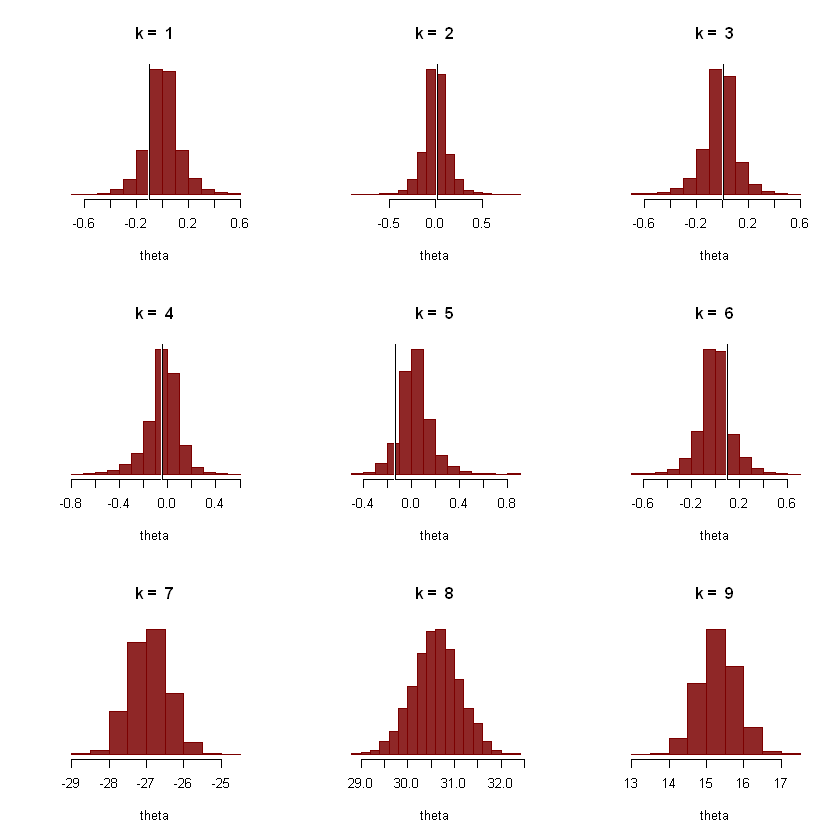

In [42]:
samples = extract(fit)

par(mfrow=c(3, 3))

for (k in 1:9) {
  hist(samples$theta[, k], 
       #breaks=seq(theta_true[k] - 5, theta_true[k] + 5,0.1)
       breaks="Sturges",
       main=paste("k = ", k), col=c_dark, border=c_dark_highlight,
       xlab="theta", yaxt='n', ylab="")
  abline(v=theta_true[k], col="white", lwd=2)
  abline(v=theta_true[k], col="black", lwd=1)
}

What if we set the Laplace scale to $\tau = 10$?



In [43]:
writeLines(readLines("stan_programs/laplace_wide.stan"))

data {
  int<lower=0> K;                       // Number of contexts
  int<lower=0> N;                       // Number of observations
  vector[N] y;                          // Observations
  int<lower=1, upper=K> context_idx[N]; // Context assignments
  real<lower=0> sigma;                  // Measurement variability
}

parameters {
  // Horseshoe parameters
  vector[K] theta;
}

model {
  // Horseshoe prior model
  theta ~ double_exponential(0, 10);

  // Observational model
  y ~ normal(theta[context_idx], sigma);
}


In [44]:
start.time <- Sys.time()

fit <- stan(file='stan_programs/laplace_wide.stan', data=data,
            seed=4938483, refresh=1000)

end.time <- Sys.time()
computing.time <- end.time - start.time
computing.time

Time difference of 41.9503 secs

In [45]:
util$check_all_diagnostics(fit)

[1] "n_eff / iter looks reasonable for all parameters"
[1] "Rhat looks reasonable for all parameters"
[1] "0 of 4000 iterations ended with a divergence (0%)"
[1] "0 of 4000 iterations saturated the maximum tree depth of 10 (0%)"
[1] "E-FMI indicated no pathological behavior"


This larger scale almost eliminates the regularization of the three large
parameters entirely, but at the same time it also eliminates the regularization
of the six parameters with smaller true values.


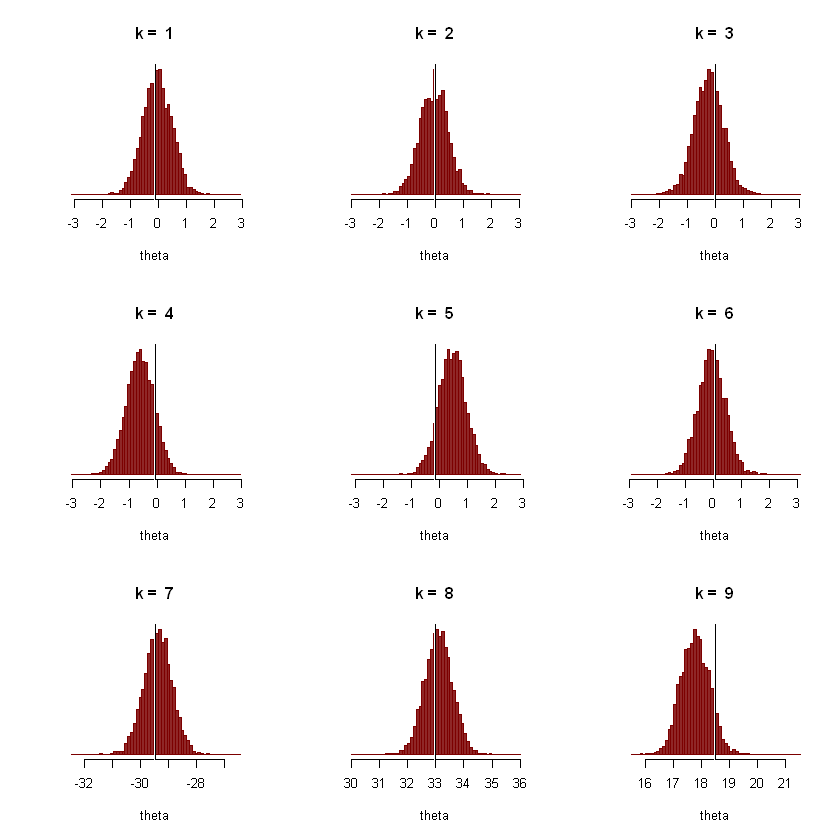

In [46]:
samples = extract(fit)

par(mfrow=c(3, 3))

for (k in 1:9) {
  hist(samples$theta[, k], breaks=seq(theta_true[k] - 3, theta_true[k] + 3, 0.1),
       main=paste("k = ", k), col=c_dark, border=c_dark_highlight,
       xlab="theta", yaxt='n', ylab="")
  abline(v=theta_true[k], col="white", lwd=2)
  abline(v=theta_true[k], col="black", lwd=1)
}

Consequently the widths of the corresponding marginal posterior distributions
are limited by the measurement variability $\sigma = 0.5$.


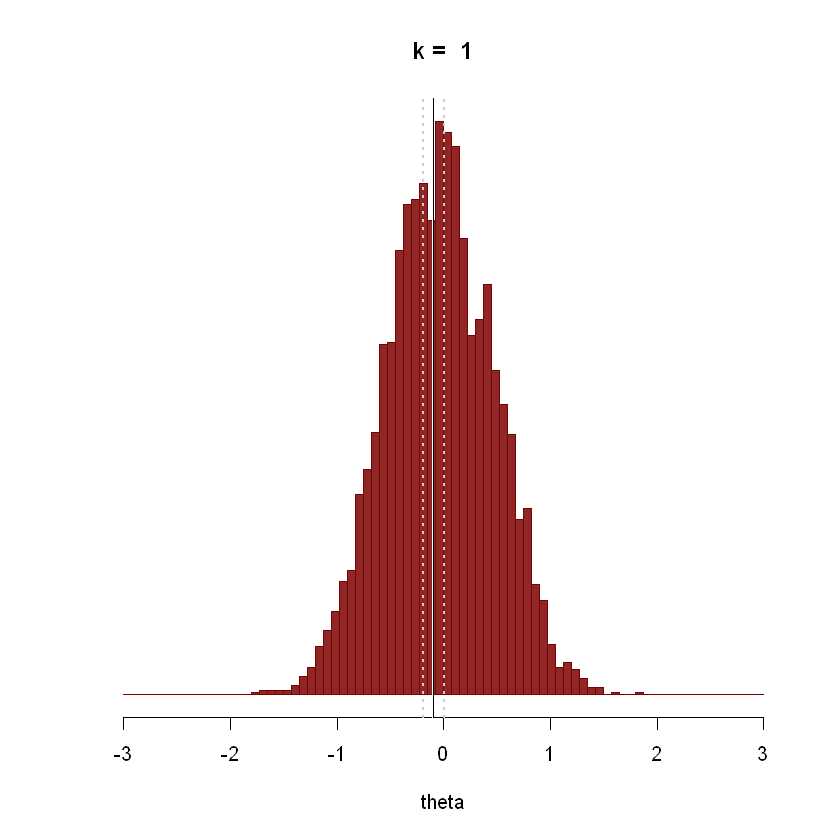

In [47]:
par(mfrow=c(1, 1))

k <- 1
hist(samples$theta[, k], breaks=seq(-3, 3, 0.075),
     main=paste("k = ", k), col=c_dark, border=c_dark_highlight,
     xlab="theta", yaxt='n', ylab="")
abline(v=theta_true[k], col="white", lwd=2)
abline(v=theta_true[k], col="black", lwd=1)

abline(v=theta_true[k] - 0.1, col="gray80", lwd=2, lty=3)
abline(v=theta_true[k] + 0.1, col="gray80", lwd=2, lty=3)

Lastly let's consider what happens when we infer $\tau$ from the observed data.



In [48]:
writeLines(readLines("stan_programs/hier_laplace_cp.stan"))

data {
  int<lower=0> K;                       // Number of contexts
  int<lower=0> N;                       // Number of observations
  vector[N] y;                          // Observations
  int<lower=1, upper=K> context_idx[N]; // Context assignments
  real<lower=0> sigma;                  // Measurement variability
}

parameters {
  // Horseshoe parameters
  vector[K] theta;
  real<lower=0> tau;
}

model {
  // Horseshoe prior model
  theta ~ double_exponential(0, tau);
  tau ~ normal(0, 10);

  // Observational model
  y ~ normal(theta[context_idx], sigma);
}


In [49]:
start.time <- Sys.time()

fit <- stan(file='stan_programs/hier_laplace_cp.stan', data=data,
            seed=4938483, refresh=1000)

end.time <- Sys.time()
computing.time <- end.time - start.time
computing.time

Time difference of 41.31141 secs

In [50]:
util$check_all_diagnostics(fit)

[1] "n_eff / iter looks reasonable for all parameters"
[1] "Rhat looks reasonable for all parameters"
[1] "0 of 4000 iterations ended with a divergence (0%)"
[1] "0 of 4000 iterations saturated the maximum tree depth of 10 (0%)"
[1] "E-FMI indicated no pathological behavior"


As with the single normal population model the single scale $\tau$ has to
compromise between the scale of the smaller parameters, $0.1$, and the scale of
the larger parameters, $10$.  The heavier tail of the Laplace population model
reduces the impact of the larger parameters, however, and this compromise is
weighted more strongly towards the smaller scale.


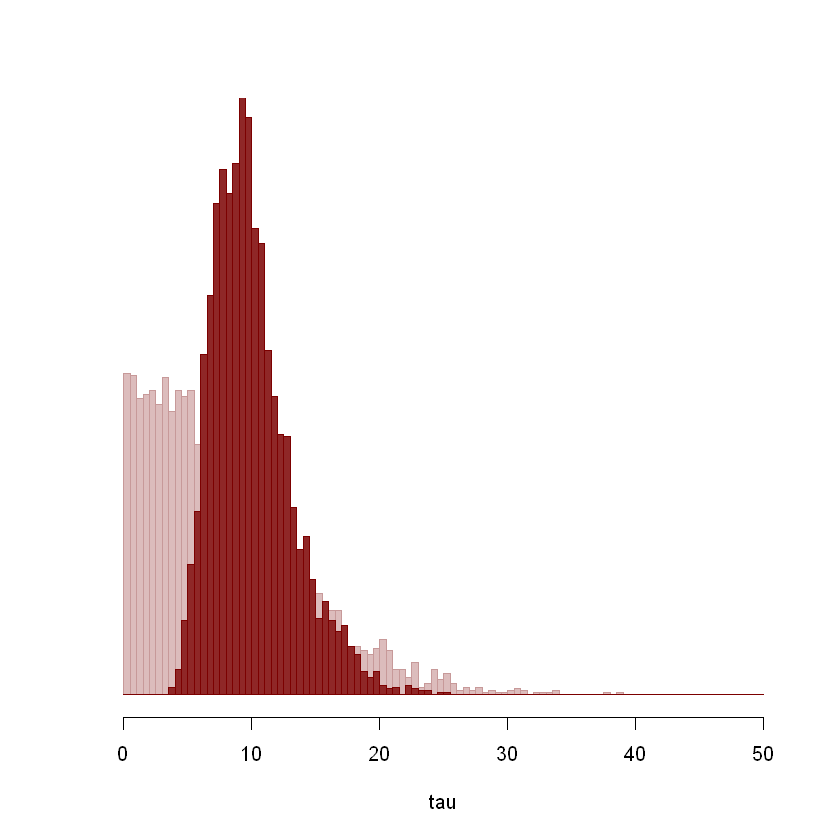

In [51]:
samples = extract(fit)

par(mfrow=c(1, 1))

hist(abs(rnorm(4000, 0, 10)), breaks=seq(0, 50, 0.5),
     main="", col=c_light, border=c_light_highlight,
     xlab="tau", yaxt='n', ylab="", ylim=c(0, 300))
hist(samples$tau, breaks=seq(0, 50, 0.5),
     main="", col=c_dark, border=c_dark_highlight, add=T)

Although not as good as the binary normal mixture population model this
compromise does a reasonable job at recovering the three parameters with larger
true values.


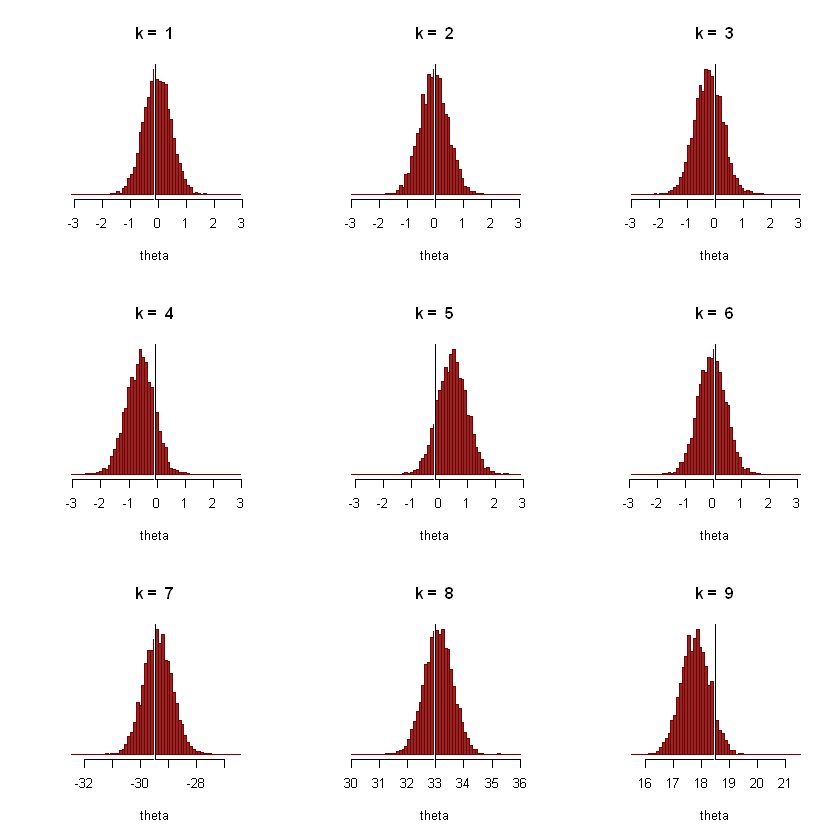

In [52]:
par(mfrow=c(3, 3))

for (k in 1:9) {
  hist(samples$theta[, k], breaks=seq(theta_true[k] - 3, theta_true[k] + 3, 0.1),
       main=paste("k = ", k), col=c_dark, border=c_dark_highlight,
       xlab="theta", yaxt='n', ylab="")
  abline(v=theta_true[k], col="white", lwd=2)
  abline(v=theta_true[k], col="black", lwd=1)
}

Unfortunately the inferred scale is too large small enough to narrow the
marginal posterior distributions of the small parameters below $\sigma = 0.5$.


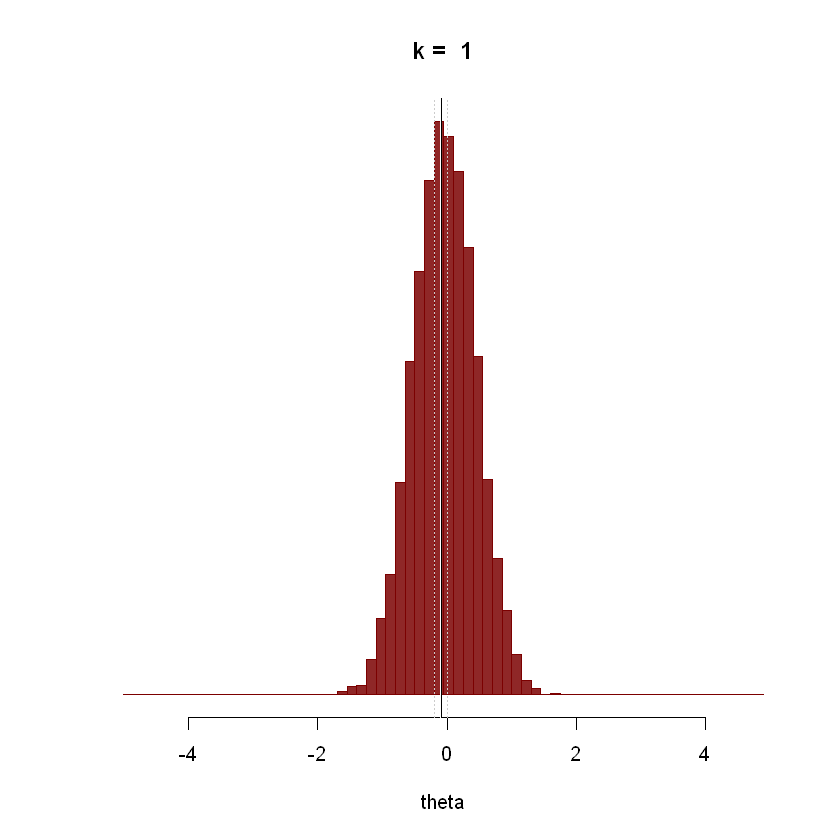

In [53]:
par(mfrow=c(1, 1))

k <- 1
hist(samples$theta[, k], breaks=seq(-5, 5, 0.15),
     main=paste("k = ", k), col=c_dark, border=c_dark_highlight,
     xlab="theta", yaxt='n', ylab="")
abline(v=theta_true[k], col="white", lwd=2)
abline(v=theta_true[k], col="black", lwd=1)

abline(v=theta_true[k] - 0.1, col="gray80", lwd=1, lty=3)
abline(v=theta_true[k] + 0.1, col="gray80", lwd=1, lty=3)

#### Student's t Population Model

A slightly more sophisticated probabilistic model for the population variances
is given by an inverse gamma probability density function,

$$
    \pi(\omega_{k} \mid \alpha, \beta)
    = \text{inv-gamma}(\omega_{k} \mid \alpha, \beta)
    = \frac{ \beta^{\alpha} }{ \Gamma(\alpha) }
    \frac{1}{\omega_{k}^{\alpha + 1}} e^{-\frac{\beta}{\omega_{k}}}.
$$

<div><center><table class="image">
<caption align="top"><h2>Inverse gamma density</h2></caption>
<tr><td><img src="figures/cauchy/inv_gamma_density.png" width="400"></td></tr>
</table></center></div>

With two degrees of freedom, $\alpha$ and $\beta$, the inverse gamma model can
be configured to allocate much more probability to larger population variances
than the exponential model.

<div><center><table class="image">
<caption align="top"><h2>Sampled normals</h2></caption>
<tr><td><img src="figures/cauchy/sampled_normals.png" width="400"></td></tr>
</table></center></div>

Fortunately this inverse gamma model also allows us to marginalize the
individual population variances analytically.  If we take
$\alpha =\frac{\nu}{2}$ and $\beta = \frac{\nu}{2} \, \tau$ then

$$
    \int \mathrm{d} \omega_{k} \,
    \text{normal}(\theta_{k} \mid 0, \sqrt{\omega_{k}}) \,
    \text{inv-gamma} \left( \omega_{k} \mid \frac{\nu}{2}, \frac{\nu}{2} \, \tau \right)
    =
    \text{student-t} (\theta_{k} \mid \nu, 0, \tau)!
$$

For a derivation of this result see [Appendix A.1](#sec:integral_party).

Once again we can incorporate an infinite dimensional mixture distribution
by simply replacing a single normal population model with a single,
heavier-tailed population model, in this case one specified by a Student's t
density function.  By adjusting the degree of freedom parameter $\nu$ the
Student's t population model can become even heavy-tailed than the Laplace
population model, inducing even more non-uniform regularization below and above
some scale set by $\tau$.  Here we will set $\nu = 1$ so that the Student's t
population model becomes a Cauchy population model.

<div><center><table class="image">
<caption align="top"><h2>Cauchy density comp</h2></caption>
<tr><td><img src="figures/cauchy/density_comp.png" width="400"></td></tr>
</table></center></div>

The heavier tail of the Cauchy population model allows it to behave even more
similarly to the binary normal mixture population model.  When an individual
likelihood function concentrates near and below $\tau$ the posterior mean is
regularized towards zero, but that regularization quickly decays as the
concentration shifts to larger values.  In particular the regularization decay
is much faster than that of the Laplace population model.  Like the binary
normal mixture population model there is also an intermediate region where the
posterior standard deviation expands relative to that expected from an improper
uniform population model.

<div><center><table class="image">
<caption align="top"><h2>Cauchy cumulant shrinkage</h2></caption>
<tr><td><img src="figures/shrinkage/cauchy/cauchy_cumulant_shrinkage.png" width="800"></td></tr>
</table></center></div>

Consequently when an individual likelihood function is wide the Cauchy
population model dominates and strongly regularizes the marginal posterior
distribution for the corresponding $\theta_{k}$.  The Cauchy population model is
similarly dominant when the individual likelihood is narrow and concentrates at
small values.  If the individual likelihood function is narrow and concentrates
at larger values, however, then the influence of the Cauchy population model
becomes negligible.

<div><center><table class="image">
<caption align="top"><h2>Cauchy density shrinkage</h2></caption>
<tr><td><img src="figures/shrinkage/cauchy/cauchy_density_shrinkage.png" width="900"></td></tr>
</table></center></div>

As with the Laplace population model the Cauchy population model offers no
regularization above $\tau$.  As with the Laplace population model this lack of
outer regularization can be problematic when an individual likelihood function
excludes small values but is otherwise degenerate across a wide expanse of large
values.

<div><center><table class="image">
<caption align="top"><h2>Outer Cauchy density shrinkage</h2></caption>
<tr><td><img src="figures/shrinkage/outer/cauchy_density_shrinkage.png" width="400"></td></tr>
</table></center></div>

To demonstrate these behaviors let's go to the code.  Per local tradition we
start by fixing $\tau$ to the scale of the smaller true parameter values,
$\tau = 0.1$.

In [54]:
writeLines(readLines("stan_programs/cauchy_narrow.stan"))

data {
  int<lower=0> K;                       // Number of contexts
  int<lower=0> N;                       // Number of observations
  vector[N] y;                          // Observations
  int<lower=1, upper=K> context_idx[N]; // Context assignments
  real<lower=0> sigma;                  // Measurement variability
}

parameters {
  // Horseshoe parameters
  vector[K] theta;
}

model {
  // Horseshoe prior model
  theta ~ cauchy(0, 0.1);

  // Observational model
  y ~ normal(theta[context_idx], sigma);
}


In [55]:
start.time <- Sys.time()

fit <- stan(file='stan_programs/cauchy_narrow.stan', data=data,
            seed=4938483, refresh=1000)

end.time <- Sys.time()
computing.time <- end.time - start.time
computing.time

Time difference of 43.67882 secs

In [56]:
util$check_all_diagnostics(fit)

[1] "n_eff / iter looks reasonable for all parameters"
[1] "Rhat looks reasonable for all parameters"
[1] "0 of 4000 iterations ended with a divergence (0%)"
[1] "0 of 4000 iterations saturated the maximum tree depth of 10 (0%)"
[1] "E-FMI indicated no pathological behavior"


Because the Cauchy population model is so heavy-tailed the six parameters with
small true values are strongly regularized towards $\tau = 0.1$ while the
three parameters with large true values exhibit almost no regularization at all.


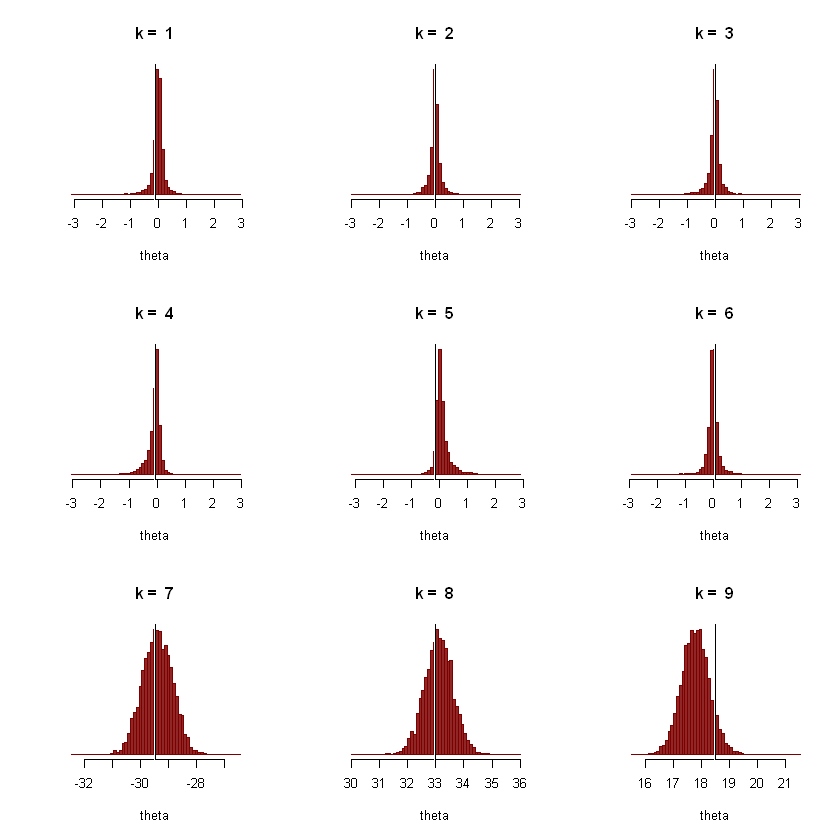

In [57]:
samples = extract(fit)

par(mfrow=c(3, 3))

for (k in 1:9) {
  hist(samples$theta[, k], breaks=seq(theta_true[k] - 3, theta_true[k] + 3, 0.1),
       main=paste("k = ", k), col=c_dark, border=c_dark_highlight,
       xlab="theta", yaxt='n', ylab="")
  abline(v=theta_true[k], col="white", lwd=2)
  abline(v=theta_true[k], col="black", lwd=1)
}

What happens if we set the scale of the Cauchy population model to that of the
larger true parameter values?


In [58]:
writeLines(readLines("stan_programs/cauchy_wide.stan"))

data {
  int<lower=0> K;                       // Number of contexts
  int<lower=0> N;                       // Number of observations
  vector[N] y;                          // Observations
  int<lower=1, upper=K> context_idx[N]; // Context assignments
  real<lower=0> sigma;                  // Measurement variability
}

parameters {
  // Horseshoe parameters
  vector[K] theta;
}

model {
  // Horseshoe prior model
  theta ~ cauchy(0, 10);

  // Observational model
  y ~ normal(theta[context_idx], sigma);
}


In [59]:
start.time <- Sys.time()

fit <- stan(file='stan_programs/cauchy_wide.stan', data=data,
            seed=4938483, refresh=1000)

end.time <- Sys.time()
computing.time <- end.time - start.time
computing.time

Time difference of 41.61593 secs

In [60]:
util$check_all_diagnostics(fit)

[1] "n_eff / iter looks reasonable for all parameters"
[1] "Rhat looks reasonable for all parameters"
[1] "0 of 4000 iterations ended with a divergence (0%)"
[1] "0 of 4000 iterations saturated the maximum tree depth of 10 (0%)"
[1] "E-FMI indicated no pathological behavior"


Given that the parameters with larger true values are barely regularized when
$\tau$ is set to the smaller scale, setting $\tau = 10$ doesn't have much
affect on those three posterior distributions.


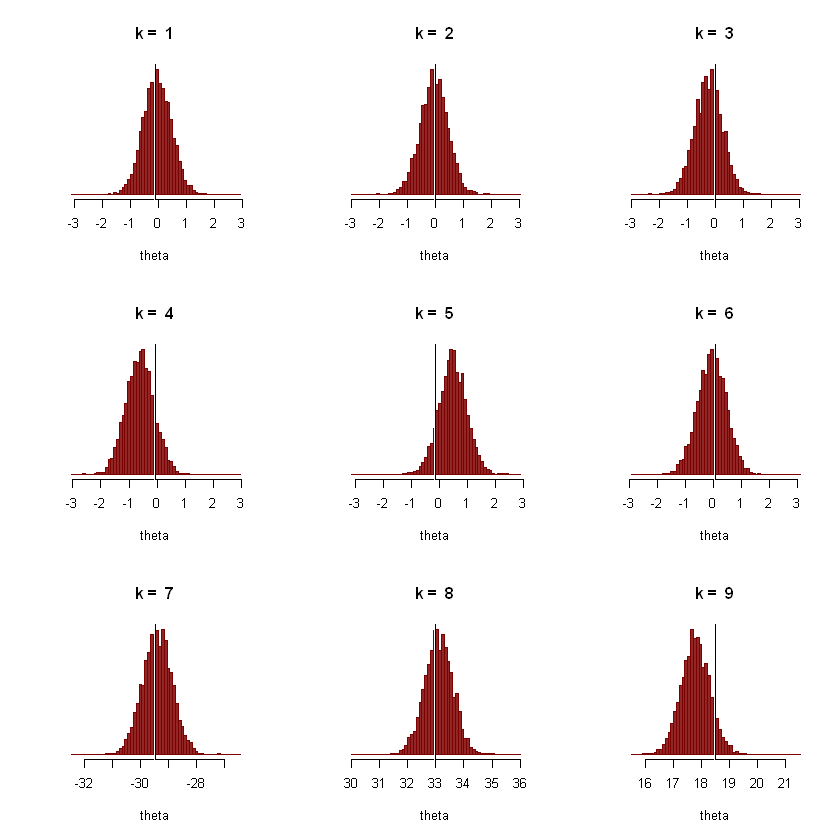

In [61]:
samples = extract(fit)

par(mfrow=c(3, 3))

for (k in 1:9) {
  hist(samples$theta[, k], breaks=seq(theta_true[k] - 3, theta_true[k] + 3, 0.1),
       main=paste("k = ", k), col=c_dark, border=c_dark_highlight,
       xlab="theta", yaxt='n', ylab="")
  abline(v=theta_true[k], col="white", lwd=2)
  abline(v=theta_true[k], col="black", lwd=1)
}

It does, however, dramatically weaken the regularization of the parameters with
small true values.


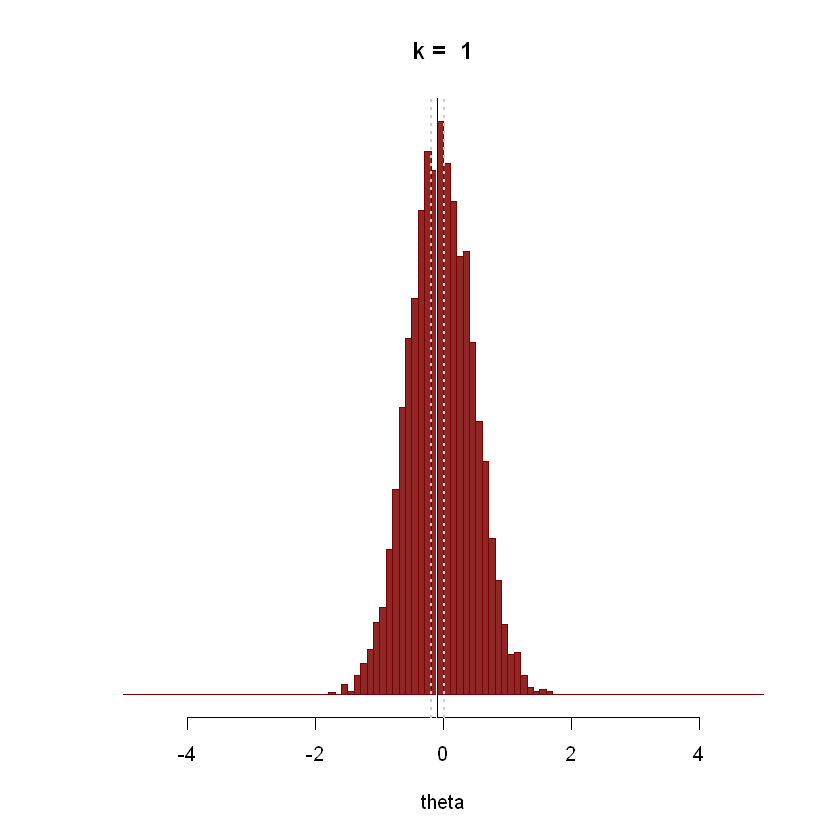

In [62]:
par(mfrow=c(1, 1))

k <- 1
hist(samples$theta[, k], breaks=seq(-5, 5, 0.1),
     main=paste("k = ", k), col=c_dark, border=c_dark_highlight,
     xlab="theta", yaxt='n', ylab="")
abline(v=theta_true[k], col="white", lwd=2)
abline(v=theta_true[k], col="black", lwd=1)

abline(v=theta_true[k] - 0.1, col="gray80", lwd=2, lty=3)
abline(v=theta_true[k] + 0.1, col="gray80", lwd=2, lty=3)

Finally let's consider the more realistic case where we need to fit $\tau$
jointly with the rest of the parameters.


In [63]:
writeLines(readLines("stan_programs/hier_cauchy_cp.stan"))

data {
  int<lower=0> K;                       // Number of contexts
  int<lower=0> N;                       // Number of observations
  vector[N] y;                          // Observations
  int<lower=1, upper=K> context_idx[N]; // Context assignments
  real<lower=0> sigma;                  // Measurement variability
}

parameters {
  // Horseshoe parameters
  vector[K] theta;
  real<lower=0> tau;
}

model {
  // Horseshoe prior model
  theta ~ cauchy(0, tau);
  tau ~ normal(0, 10);

  // Observational model
  y ~ normal(theta[context_idx], sigma);
}


In [64]:
start.time <- Sys.time()

fit <- stan(file='stan_programs/hier_cauchy_cp.stan', data=data,
            seed=4938483, refresh=1000)

end.time <- Sys.time()
computing.time <- end.time - start.time
computing.time

Time difference of 45.00002 secs

In [65]:
util$check_all_diagnostics(fit)

[1] "n_eff / iter looks reasonable for all parameters"
[1] "Rhat looks reasonable for all parameters"
[1] "0 of 4000 iterations ended with a divergence (0%)"
[1] "0 of 4000 iterations saturated the maximum tree depth of 10 (0%)"
[1] "E-FMI indicated no pathological behavior"


As was the case with the Laplace population model, the single scale $\tau$ of
the Cauchy population model has to compromise between the small scale around
$0.1$ and the large scale around $10$.  The heavier tail, however, weakens the
influence of the individual likelihood functions concentrating at larger values
even more, and the marginal posterior distribution for $\tau$ is able to overlap
with the smaller scale ever so slightly.


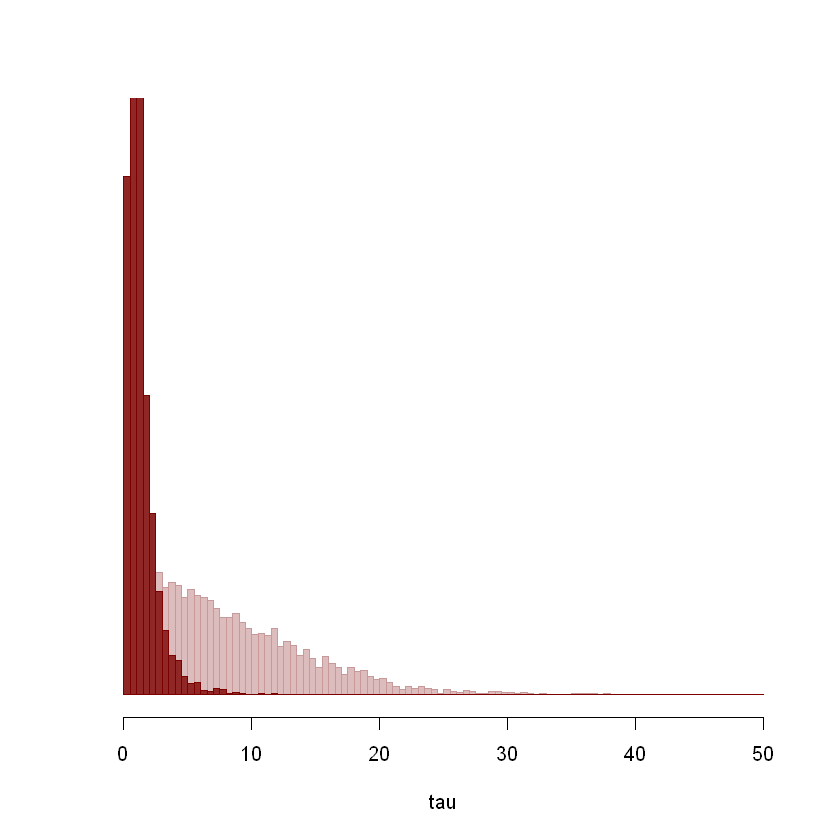

In [66]:
samples = extract(fit)

par(mfrow=c(1, 1))

hist(abs(rnorm(4000, 0, 10)), breaks=seq(0, 50, 0.5),
     main="", col=c_light, border=c_light_highlight,
     xlab="tau", yaxt='n', ylab="", ylim=c(0, 800))
hist(samples$tau, breaks=seq(0, 50, 0.5),
     main="", col=c_dark, border=c_dark_highlight, add=T)

This compromise doesn't much affect inferences for the three parameters with
larger true values.


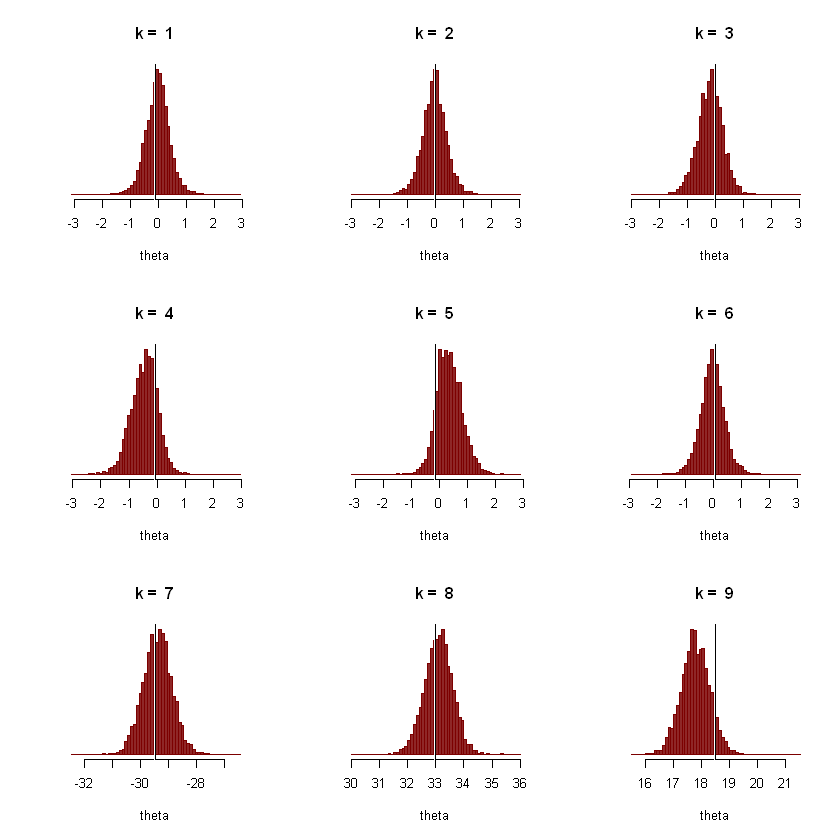

In [67]:
par(mfrow=c(3, 3))

for (k in 1:9) {
  hist(samples$theta[, k], breaks=seq(theta_true[k] - 3, theta_true[k] + 3, 0.1),
       main=paste("k = ", k), col=c_dark, border=c_dark_highlight,
       xlab="theta", yaxt='n', ylab="")
  abline(v=theta_true[k], col="white", lwd=2)
  abline(v=theta_true[k], col="black", lwd=1)
}

The larger values of $\tau$ supported by the posterior distribution, however,
does weaken the regularization of the other six parameters.


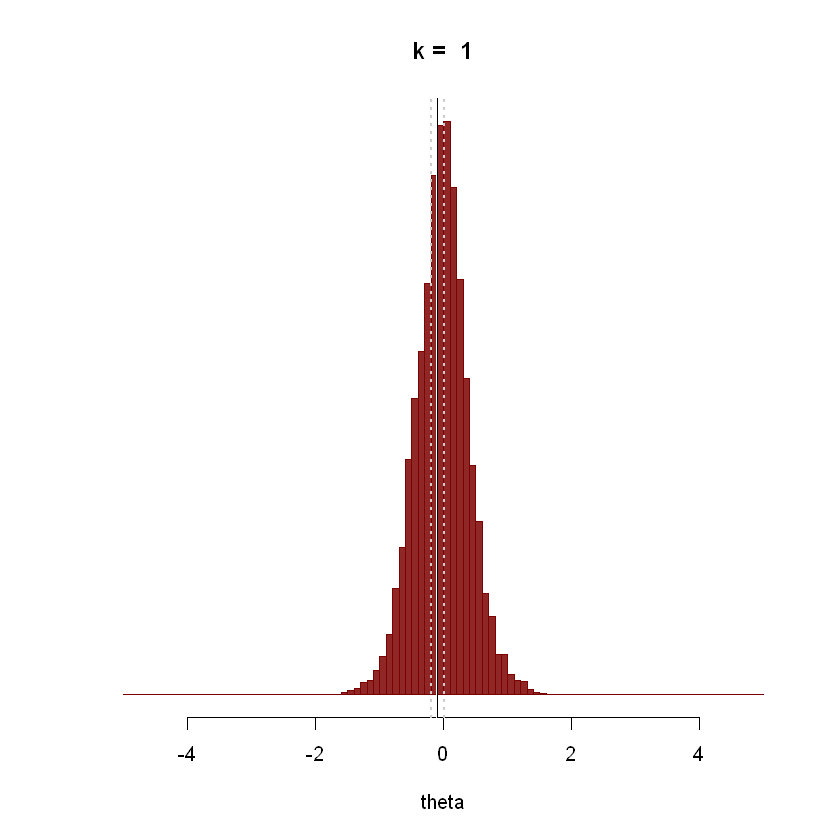

In [68]:
par(mfrow=c(1, 1))

k <- 1
hist(samples$theta[, k], breaks=seq(-5, 5, 0.1),
     main=paste("k = ", k), col=c_dark, border=c_dark_highlight,
     xlab="theta", yaxt='n', ylab="")
abline(v=theta_true[k], col="white", lwd=2)
abline(v=theta_true[k], col="black", lwd=1)

abline(v=theta_true[k] - 0.1, col="gray80", lwd=2, lty=3)
abline(v=theta_true[k] + 0.1, col="gray80", lwd=2, lty=3)

#### The Horseshoe Population Model

We conclude by considering one last model for the normal population scales that
has become popular in the Bayesian zeitgeist over the past few years.

The _horseshoe_ model [@CarvalhoEtAl:2009] begins not with individual scales for
every individual parameter $\theta_{k}$ but rather a common global scale for all
of the parameters, $\tau$.  This scale, however, is then _inflated_ within each
context by an auxiliary parameter $\lambda_{k}$,

$$
    \pi(\theta_{k} \mid \lambda_{k}, \tau)
    =
    \text{normal}(\theta_{k} \mid 0, \lambda_{k} \cdot \tau).
$$

    These auxiliary parameters are modeled with a unit half-Cauchy density function,
    
$$
    \pi(\lambda_{k}) = \text{half-Cauchy}(\lambda_{k} \mid 0, 1),
$$

which allocates most of its probability to $\lambda_{k} \lessapprox 1$ and
spreads the rest over extremely large values.  The intuition is that most of the
$\lambda_{k}$ will take values near 1 in which case the corresponding
$\theta_{k}$ will be strongly regularized towards $\tau$.  A few of the
$\lambda_{k}$, however, will be able to take on much larger values which will
inflate the normal population model for the corresponding $\theta_{k}$ so much
that it becomes a negligible contribution to the marginal posterior
distribution.

<div><center><table class="image">
<caption align="top"><h2>Horseshoe-sampled normals</h2></caption>
<tr><td><img src="figures/horseshoe/sampled_normals.png" width="400"></td></tr>
</table></center></div>

We can't analytically marginalize out these auxiliary inflation parameters, but
we can numerically approximate the marginal population model to compare to the
population models that we have considered above.

<div><center><table class="image">
<caption align="top"><h2>Horseshoe density comp.</h2></caption>
<tr><td><img src="figures/horseshoe/density_comp.png" width="400"></td></tr>
</table></center></div>

Compared to the Cauchy population model the horseshoe population model is more
sharply peaked within the scale $\tau $ without compromising the heaviness of
the tails that extend to larger values.  In other words the "shoulders" of the
marginal probability density function are suppressed allowing the horseshoe
population model to resemble the spike and slab population model reasonably
well.

To see the inferential consequences of this model we'll have to look to
numerical examples.

##### One Horse Town

Before fitting the full horseshoe population model let's fix the global
population scale, $ \tau$.  A shoe for geldings, if you will.

In [69]:
writeLines(readLines("stan_programs/geldingshoe_cp.stan"))

data {
  int<lower=0> K;                       // Number of groups
  int<lower=0> N;                       // Number of observations
  vector[N] y;                          // Observations
  int<lower=1, upper=K> context_idx[N]; // Context assignments
  real<lower=0> tau;                    // Base Population Scale
  real<lower=0> sigma;                  // Measurement variability
}

parameters {
  vector[K] theta;
  vector<lower=0>[K] lambda;
}

model {
  // Horseshoe prior model
  theta ~ normal(0, lambda * tau);
  lambda ~ cauchy(0, 1);

  // Observational model
  y ~ normal(theta[context_idx], sigma);
}


The hope is that the heavy tail of the horseshoe population model will allow
us to set $\tau$ to the scale of the smaller parameters without affecting the
inferences for the larger parameters.


In [70]:
data$tau <- 0.1

In [71]:
start.time <- Sys.time()

fit <- stan(file='stan_programs/geldingshoe_cp.stan', data=data,
            seed=4938483, refresh=1000)

end.time <- Sys.time()
computing.time <- end.time - start.time
computing.time

Warning message:
"There were 704 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them."
Warning message:
"Examine the pairs() plot to diagnose sampling problems
"
Warning message:
"The largest R-hat is 1.1, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat"
Warning message:
"Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess"
Warning message:
"Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#tail-ess"


Time difference of 46.28098 secs

In [72]:
util$check_all_diagnostics(fit)

[1] "n_eff / iter looks reasonable for all parameters"
[1] "Rhat for parameter theta[8] is 1.11283256891441!"
[1] "  Rhat above 1.1 indicates that the chains very likely have not mixed"
[1] "704 of 4000 iterations ended with a divergence (17.6%)"
[1] "  Try running with larger adapt_delta to remove the divergences"
[1] "0 of 4000 iterations saturated the maximum tree depth of 10 (0%)"
[1] "E-FMI indicated no pathological behavior"


Eeeek; divergences abound.  Let's go hunting.



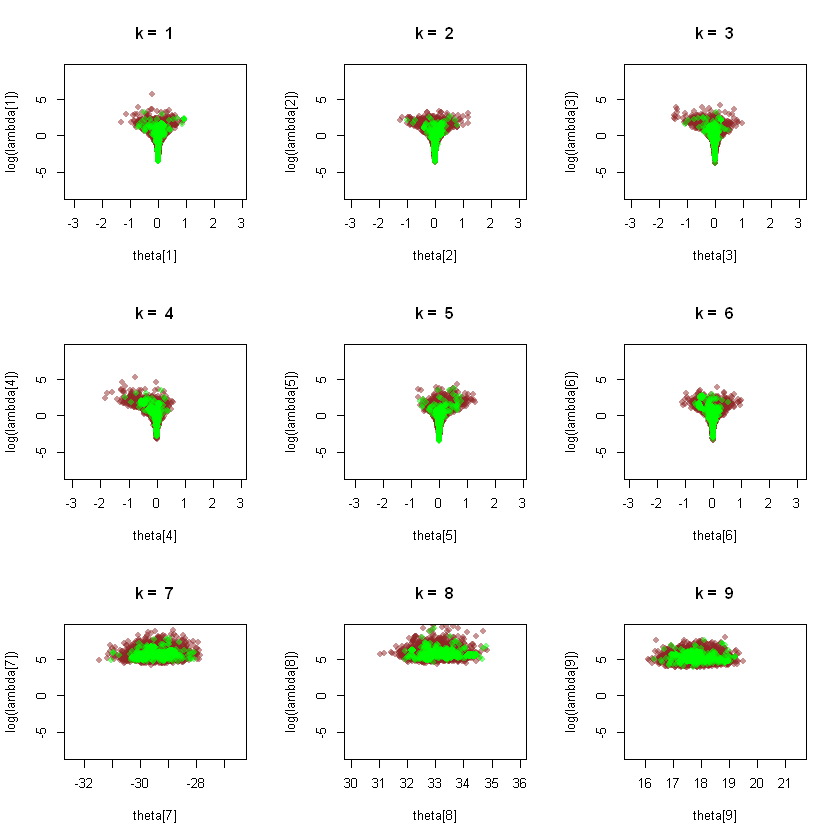

In [73]:
partition <- util$partition_div(fit)
div_params <- partition[[1]]
nondiv_params <- partition[[2]]

par(mfrow=c(3, 3))

for (k in 1:9) {
  name_x <- paste("theta[", k, "]", sep='')
  name_y <- paste("lambda[", k, "]", sep='')

  plot(nondiv_params[name_x][,1], log(nondiv_params[name_y][,1]),
       col=c_dark_trans, pch=16, main=paste("k = ", k),
       xlab=name_x, xlim=c(theta_true[k] - 3, theta_true[k] + 3),
       ylab=paste("log(", name_y, ")", sep=""), ylim=c(-8, 9))
  points(div_params[name_x][,1], log(div_params[name_y][,1]),
         col=c_green_trans, pch=16)
}

With $\tau$ fixed the interaction between the individual parameters and the
population model is moderated by the inflation parameters, $\lambda_{k}$, and
that interaction manifests in strong funnel geometries between each
$\lambda_{k}$ and $\theta_{k}$.  Critically because each $\lambda_{k}$ is
informed by one and only one context there's no partial pooling to moderate
the vertical direction of the funnels!

The only respite from the funnels appears in contexts 7, 8, and 9 which push to
larger values of $\lambda_{k}$ that cut off the most pathological part of the
funnel geometry.  These larger values are needed to inflate the corresponding
normal population models and allow the individual likelihood functions to
dominate the marginal posterior distributions, as desired for the larger true
values in these contexts.

As with the binary normal mixture population model the optimal parameterization
of the horseshoe population model depends not just on the width of the
individual likelihood functions but also on their locations.  When an individual
likelihood function concentrates near $\tau$ the corresponding $\lambda_{k}$
will concentrate around $1$, allowing the marginal posterior distribution for
$\theta_{k}$ to be strongly regularized.  In this case a non-centered
parameterization of the $\theta_{k}$ should be optimal even if the individual
likelihood function itself is narrow.  On the other hand when an individual
likelihood function concentrates above $\tau$ then the corresponding
$\lambda_{k}$ will inflate, allowing said likelihood function to dominate the
marginal posterior distribution.  Here a centered parameterization of
$\theta_{k}$ should yield the optimal geometry.

Under the sparsity assumption we'll need to non-center most of the $\theta_{k}$,
but we won't know which to leave centered until we try to fit and see where the
funnels are most strongly manifesting.  Having already seen centered funnels in
the first six contexts let's try non-centering just those.


In [74]:
writeLines(readLines("stan_programs/geldingshoe_mixed.stan"))

data {
  int<lower=0> K;                       // Number of groups
  int<lower=0> N;                       // Number of observations
  vector[N] y;                          // Observations
  int<lower=1, upper=K> context_idx[N]; // Context assignments
  
  int<lower=0, upper=K> K_cp;
  int<lower=0, upper=K> cp_idx[K_cp];
  
  int<lower=0, upper=K> K_ncp;
  int<lower=0, upper=K> ncp_idx[K_ncp];
  
  real<lower=0> tau;                    // Base Population Scale
  real<lower=0> sigma;                  // Measurement variability
}

parameters {
  vector[K_cp] theta_cp;
  vector[K_ncp] theta_ncp;
  
  vector<lower=0>[K] lambda;
}

transformed parameters {
  vector[K] theta;
  theta[cp_idx] = theta_cp;
  theta[ncp_idx] = theta_ncp .* lambda[ncp_idx];
}

model {
  // Horseshoe prior model
  theta_cp ~ normal(0, lambda[cp_idx] * tau);
  theta_ncp ~ normal(0, tau);
  
  lambda ~ cauchy(0, 1);

  // Observational model
  y ~ normal(theta[context_idx], sigma);
}


In [75]:
data$cp_idx <- c(7, 8, 9)
data$K_cp <- length(data$cp_idx)

data$ncp_idx <- setdiff(1:data$K, data$cp_idx)
data$K_ncp <- length(data$ncp_idx)

In [76]:
start.time <- Sys.time()

fit <- stan(file='stan_programs/geldingshoe_mixed.stan', data=data,
            seed=4938483, refresh=1000)

end.time <- Sys.time()
computing.time <- end.time - start.time
computing.time

Warning message:
"There were 35 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them."
Warning message:
"Examine the pairs() plot to diagnose sampling problems
"


Time difference of 46.08908 secs

In [77]:
util$check_all_diagnostics(fit)

[1] "n_eff / iter looks reasonable for all parameters"
[1] "Rhat looks reasonable for all parameters"
[1] "35 of 4000 iterations ended with a divergence (0.875%)"
[1] "  Try running with larger adapt_delta to remove the divergences"
[1] "0 of 4000 iterations saturated the maximum tree depth of 10 (0%)"
[1] "E-FMI indicated no pathological behavior"


Unfortunately this reparameterization seems to have done nothing beneficial.
Indeed looking at the pairs plots we see that the first six contexts now
manifest _inverted funnels_!


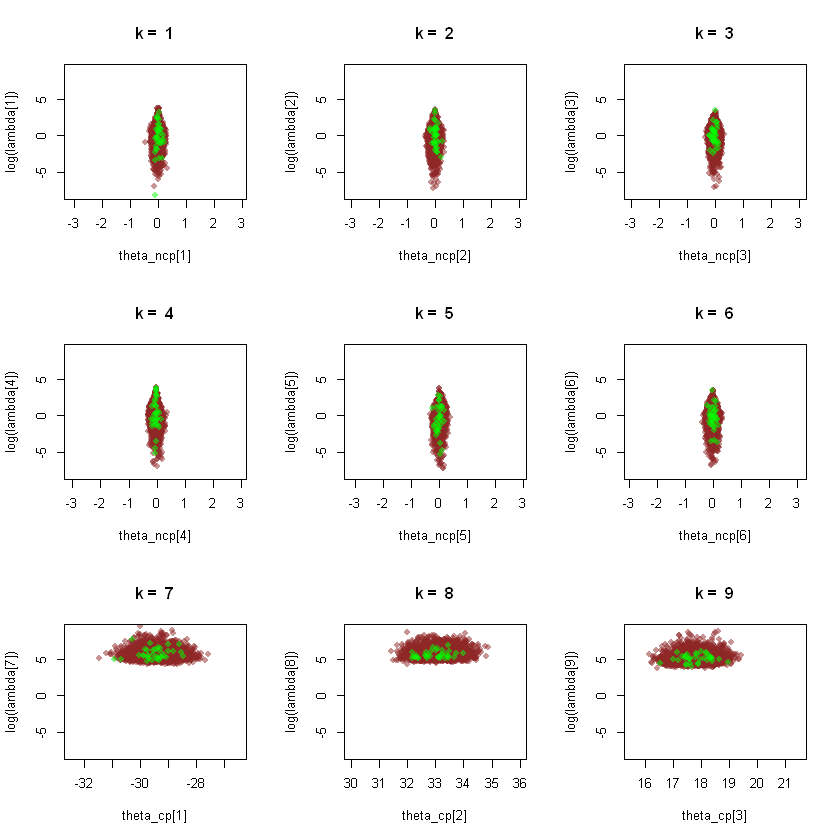

In [78]:
partition <- util$partition_div(fit)
div_params <- partition[[1]]
nondiv_params <- partition[[2]]

par(mfrow=c(3, 3))

for (k in 1:9) {
  if (k %in% data$cp_idx)
    name_x <- paste("theta_cp[", which(data$cp_idx == k), "]", sep='')
  else
    name_x <- paste("theta_ncp[", which(data$ncp_idx == k), "]", sep='')

  name_y <- paste("lambda[", k, "]", sep='')

  plot(nondiv_params[name_x][,1], log(nondiv_params[name_y][,1]),
       col=c_dark_trans, pch=16, main=paste("k = ", k),
       xlab=name_x, xlim=c(theta_true[k] - 3, theta_true[k] + 3),
       ylab=paste("log(", name_y, ")", sep=""), ylim=c(-8, 9))
  points(div_params[name_x][,1], log(div_params[name_y][,1]),
         col=c_green_trans, pch=16)
}

The problem here is that the heavy tailed Cauchy prior model for the
$\lambda_{k}$ is a bit of a double edged sword.  While it allows inferences for
larger parameters to decouple from the prior model it also puts inferences for
the smaller parameters in a weird place.  These inferences are informed by
the individual likelihood functions too strongly for the non-centered
parameterization to yield a funnel-free geometry but they're not informed enough
for the centered parameterization to yield a funnel-free geometry!  If that's
not bad enough because "funnel-free geometry" rhymes with
"problem-free philosophy" you're now going to have the Lion King soundtrack
stuck in your head.

With both the centered and non-centered parameterizations of the strongly
regularized contexts exhibiting funnel geometries we'll have to pull out the
heavy artillery and consider a _partially-centered parameterization_ that
interpolates between the two.  When the centering parameter $w$ approaches 1 the
partially-centered parameterization becomes a centered parameterization, and
when it approaches 0 it becomes a non-centered parameterization.  Let's start by
keeping the last three contexts centered but drop the first six contexts right
in the middle.


In [79]:
writeLines(readLines("stan_programs/geldingshoe_partial.stan"))

data {
  int<lower=0> K;                       // Number of groups
  int<lower=0> N;                       // Number of observations
  vector[N] y;                          // Observations
  int<lower=1, upper=K> context_idx[N]; // Context assignments
  
  vector<lower=0, upper=1>[K] w;        // Partial centering parameters
  
  real<lower=0> tau;                    // Base Population Scale
  real<lower=0> sigma;                  // Measurement variability
}

parameters {
  vector[K] theta_tilde;
  vector<lower=0>[K] lambda;
}

transformed parameters {
  vector[K] theta;
  for (k in 1:K)
    theta[k] = pow(lambda[k] * tau, 1 - w[k]) * theta_tilde[k];
}

model {
  for (k in 1:K)
    theta_tilde[k] ~ normal(0, pow(lambda[k] * tau, w[k]));
  lambda ~ cauchy(0, 1);

  // Observational model
  y ~ normal(theta[context_idx], sigma);
}


In [80]:
data$w <- c(0.5, 0.5, 0.5,
            0.5, 0.5, 0.5,
            1.0, 1.0, 1.0)

In [81]:
start.time <- Sys.time()

fit <- stan(file='stan_programs/geldingshoe_partial.stan', data=data,
            seed=4938483, refresh=1000)

end.time <- Sys.time()
computing.time <- end.time - start.time
computing.time

Warning message:
"There were 257 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them."
Warning message:
"Examine the pairs() plot to diagnose sampling problems
"


Time difference of 45.17342 secs

In [82]:
util$check_all_diagnostics(fit)

[1] "n_eff / iter looks reasonable for all parameters"
[1] "Rhat looks reasonable for all parameters"
[1] "257 of 4000 iterations ended with a divergence (6.425%)"
[1] "  Try running with larger adapt_delta to remove the divergences"
[1] "0 of 4000 iterations saturated the maximum tree depth of 10 (0%)"
[1] "E-FMI indicated no pathological behavior"


Plenty of divergences remain and the funnels in the pairs plots suggest that
we need to push the partially-centered parameterization more towards
non-centering.


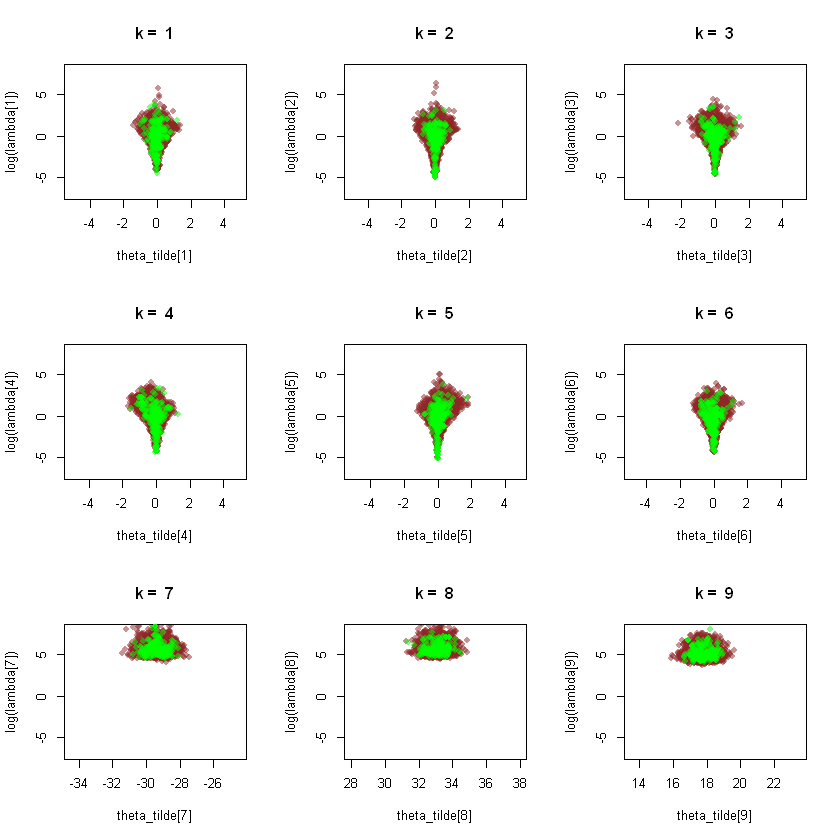

In [83]:
partition <- util$partition_div(fit)
div_params <- partition[[1]]
nondiv_params <- partition[[2]]

par(mfrow=c(3, 3))

for (k in 1:9) {
  name_x <- paste("theta_tilde[", k, "]", sep='')
  name_y <- paste("lambda[", k, "]", sep='')

  plot(nondiv_params[name_x][,1], log(nondiv_params[name_y][,1]),
       col=c_dark_trans, pch=16, main=paste("k = ", k),
       xlab=name_x, xlim=c(theta_true[k] - 5, theta_true[k] + 5),
       ylab=paste("log(", name_y, ")", sep=""), ylim=c(-7, 8))
  points(div_params[name_x][,1], log(div_params[name_y][,1]),
         col=c_green_trans, pch=16)
}

Let's try dropping the first six $w$ to even smaller values.



In [84]:
data$w <- c(0.25, 0.25, 0.25,
            0.25, 0.25, 0.25,
            1.0, 1.0, 1.0)

In [85]:
start.time <- Sys.time()

fit <- stan(file='stan_programs/geldingshoe_partial.stan', data=data,
            seed=4938483, refresh=1000)

end.time <- Sys.time()
computing.time <- end.time - start.time
computing.time

Warning message:
"There were 35 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them."
Warning message:
"Examine the pairs() plot to diagnose sampling problems
"


Time difference of 8.519803 secs

In [86]:
util$check_all_diagnostics(fit)

[1] "n_eff / iter looks reasonable for all parameters"
[1] "Rhat looks reasonable for all parameters"
[1] "35 of 4000 iterations ended with a divergence (0.875%)"
[1] "  Try running with larger adapt_delta to remove the divergences"
[1] "0 of 4000 iterations saturated the maximum tree depth of 10 (0%)"
[1] "E-FMI indicated no pathological behavior"


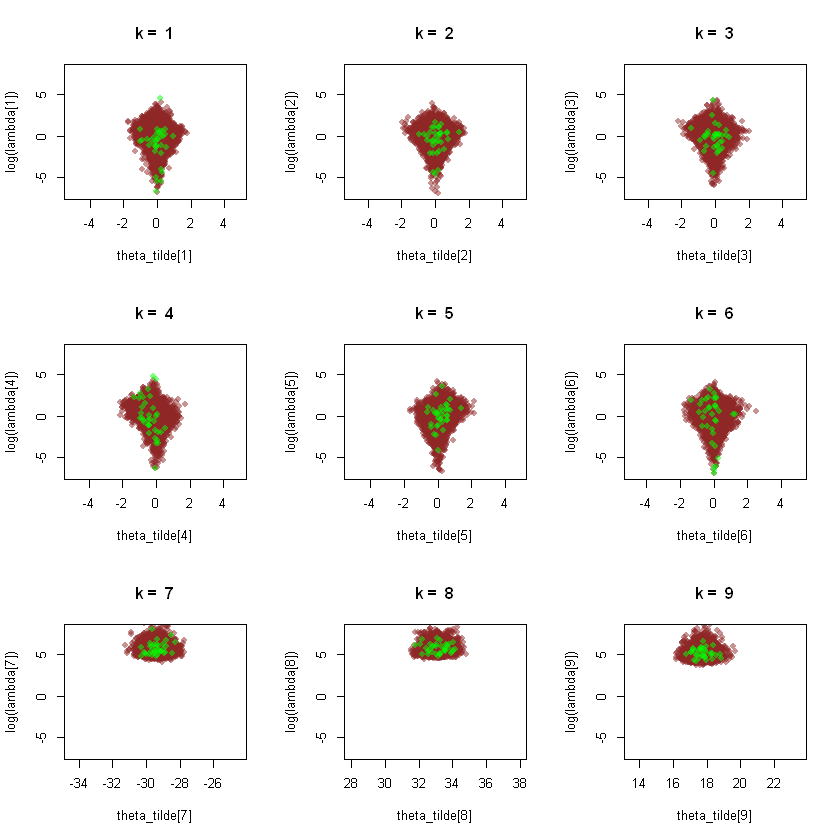

In [87]:
partition <- util$partition_div(fit)
div_params <- partition[[1]]
nondiv_params <- partition[[2]]

par(mfrow=c(3, 3))

for (k in 1:9) {
  name_x <- paste("theta_tilde[", k, "]", sep='')
  name_y <- paste("lambda[", k, "]", sep='')

  plot(nondiv_params[name_x][,1], log(nondiv_params[name_y][,1]),
       col=c_dark_trans, pch=16, main=paste("k = ", k),
       xlab=name_x, xlim=c(theta_true[k] - 5, theta_true[k] + 5),
       ylab=paste("log(", name_y, ")", sep=""), ylim=c(-7, 8))
  points(div_params[name_x][,1], log(div_params[name_y][,1]),
         col=c_green_trans, pch=16)
}

Still too centered!  Let's keep going.



In [88]:
data$w <- c(0.2, 0.2, 0.2,
            0.2, 0.2, 0.2,
            1.0, 1.0, 1.0)

In [89]:
start.time <- Sys.time()

fit <- stan(file='stan_programs/geldingshoe_partial.stan', data=data,
            seed=4938483, refresh=1000)

end.time <- Sys.time()
computing.time <- end.time - start.time
computing.time

Warning message:
"There were 23 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them."
Warning message:
"Examine the pairs() plot to diagnose sampling problems
"


Time difference of 7.490806 secs

In [90]:
util$check_all_diagnostics(fit)

[1] "n_eff / iter looks reasonable for all parameters"
[1] "Rhat looks reasonable for all parameters"
[1] "23 of 4000 iterations ended with a divergence (0.575%)"
[1] "  Try running with larger adapt_delta to remove the divergences"
[1] "0 of 4000 iterations saturated the maximum tree depth of 10 (0%)"
[1] "E-FMI indicated no pathological behavior"


Well this is interesting.  We seem to have found a nice balance between the
centered and non-centering parameterizations, but only because the pairs plots
exhibit _both regular and inverted funnels at the same time_!  In other words
the funnel has become a diamond that's pointy on all sides.


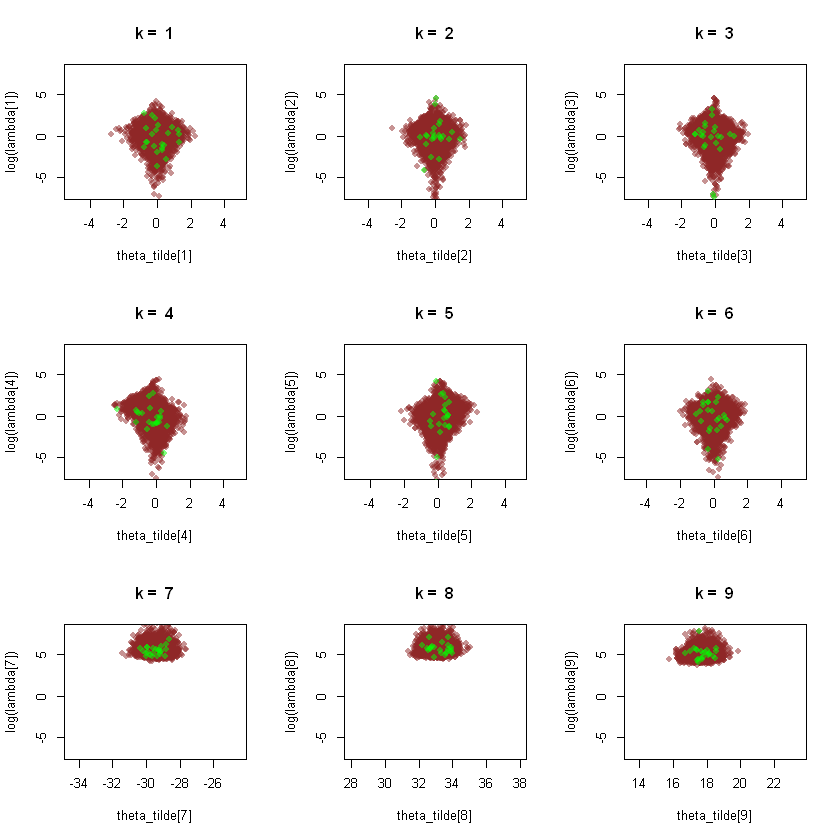

In [91]:
partition <- util$partition_div(fit)
div_params <- partition[[1]]
nondiv_params <- partition[[2]]

par(mfrow=c(3, 3))

for (k in 1:9) {
  name_x <- paste("theta_tilde[", k, "]", sep='')
  name_y <- paste("lambda[", k, "]", sep='')

  plot(nondiv_params[name_x][,1], log(nondiv_params[name_y][,1]),
       col=c_dark_trans, pch=16, main=paste("k = ", k),
       xlab=name_x, xlim=c(theta_true[k] - 5, theta_true[k] + 5),
       ylab=paste("log(", name_y, ")", sep=""), ylim=c(-7, 8))
  points(div_params[name_x][,1], log(div_params[name_y][,1]),
         col=c_green_trans, pch=16)
}

At this point there's not much we can do but brute force a more accurate fit by
use a less aggressive sampler adaptation in Stan.


In [92]:
start.time <- Sys.time()

fit <- stan(file='stan_programs/geldingshoe_partial.stan', data=data,
            seed=4938483, refresh=1000, control=list(adapt_delta=0.99))

end.time <- Sys.time()
computing.time <- end.time - start.time
computing.time

Time difference of 7.867768 secs

In [93]:
util$check_all_diagnostics(fit)

[1] "n_eff / iter looks reasonable for all parameters"
[1] "Rhat looks reasonable for all parameters"
[1] "0 of 4000 iterations ended with a divergence (0%)"
[1] "0 of 4000 iterations saturated the maximum tree depth of 10 (0%)"
[1] "E-FMI indicated no pathological behavior"


Finally through considerable tuning of the parameterizations _and_ expensive
sampling we have a divergence-free fit.  Even better all of that work yields
sparse inferences, with the small parameters regularized towards $\tau$ and the
large parameters not regularized at all.


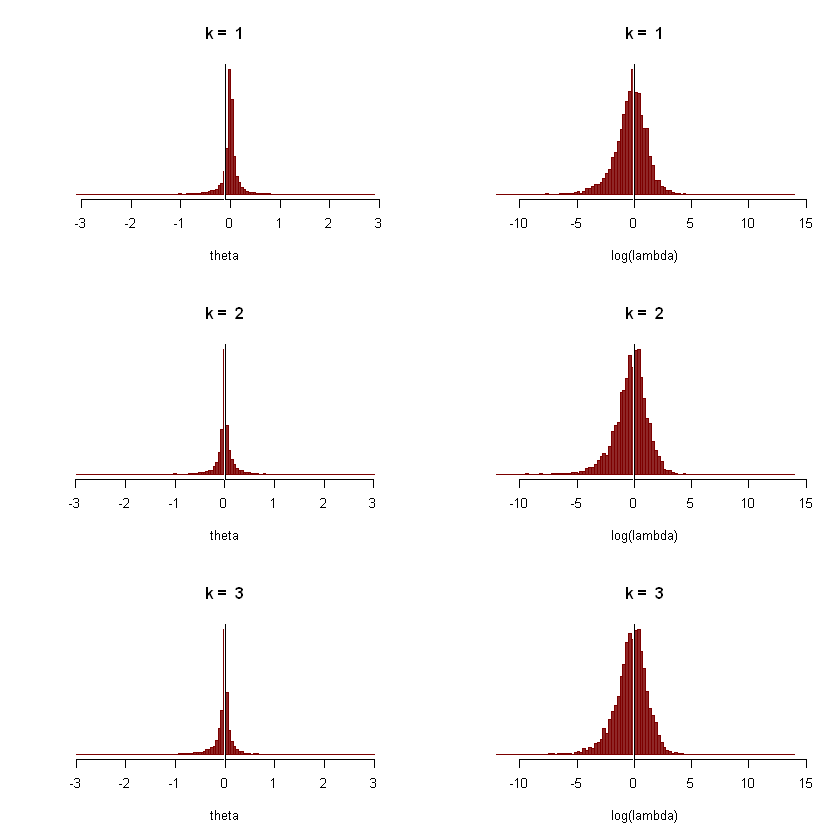

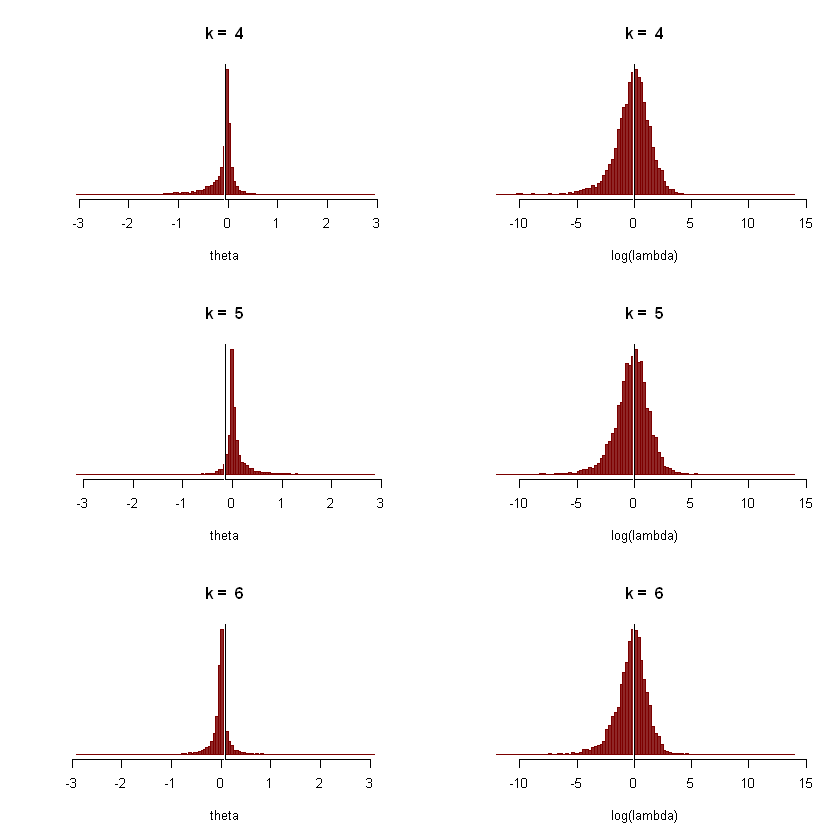

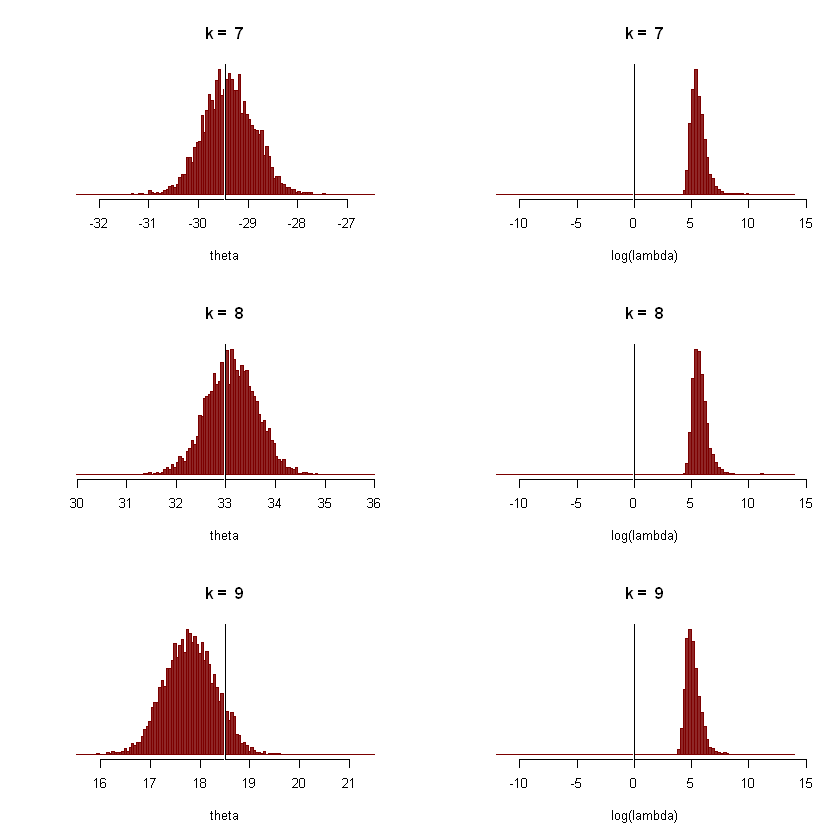

In [94]:
samples = extract(fit)

par(mfrow=c(3, 2))

for (k in 1:9) {
  hist(samples$theta[, k], breaks=seq(theta_true[k] - 3, theta_true[k] + 3, 0.05),
       main=paste("k = ", k), col=c_dark, border=c_dark_highlight,
       xlab="theta", yaxt='n', ylab="")
  abline(v=theta_true[k], col="white", lwd=2)
  abline(v=theta_true[k], col="black", lwd=1)

  hist(log(samples$lambda[, k]), breaks=seq(-12, 14, 0.25),
       main=paste("k = ", k), col=c_dark, border=c_dark_highlight,
       xlab="log(lambda)", yaxt='n', ylab="")
  abline(v=0, col="white", lwd=2)
  abline(v=0, col="black", lwd=1)
}

##### High Horse

As unpleasant as that was let's confront what happens when the population scale
is not fixed but instead contained near the small scale with a prior model.
Using what we learned above let's start with mixed parameterization that
non-centers the first six $ \theta_{k}$ that we expect to be more strongly
influenced by the prior model.

In [95]:
writeLines(readLines("stan_programs/horseshoe_mixed.stan"))

data {
  int<lower=0> K;                       // Number of groups
  int<lower=0> N;                       // Number of observations
  vector[N] y;                          // Observations
  int<lower=1, upper=K> context_idx[N]; // Context assignments
  
  int<lower=0, upper=K> K_cp;
  int<lower=0, upper=K> cp_idx[K_cp];
  
  int<lower=0, upper=K> K_ncp;
  int<lower=0, upper=K> ncp_idx[K_ncp];
  
  real<lower=0> sigma;                  // Measurement variability
}

parameters {
  vector[K_cp] theta_cp;
  vector[K_ncp] theta_ncp;
  
  vector<lower=0>[K] lambda;
  real<lower=0> tau;
}

transformed parameters {
  vector[K] theta;
  theta[cp_idx] = theta_cp;
  theta[ncp_idx] = theta_ncp .* lambda[ncp_idx] * tau;
}

model {
  // Horseshoe prior model
  theta_cp ~ normal(0, lambda[cp_idx] * tau);
  theta_ncp ~ normal(0, 1);
  
  lambda ~ cauchy(0, 1);
  tau ~ normal(0, 0.1);

  // Observational model
  y ~ normal(theta[context_idx], sigma);
}


In [96]:
data$cp_idx <- c(7, 8, 9)
data$K_cp <- length(data$cp_idx)

data$ncp_idx <- setdiff(1:data$K, data$cp_idx)
data$K_ncp <- length(data$ncp_idx)

In [97]:
start.time <- Sys.time()

fit <- stan(file='stan_programs/horseshoe_mixed.stan', data=data,
             seed=4938483, refresh=1000)

end.time <- Sys.time()
computing.time <- end.time - start.time
computing.time

Warning message:
"There were 28 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them."
Warning message:
"Examine the pairs() plot to diagnose sampling problems
"


Time difference of 47.77443 secs

In [98]:
util$check_all_diagnostics(fit)

[1] "n_eff / iter looks reasonable for all parameters"
[1] "Rhat looks reasonable for all parameters"
[1] "28 of 4000 iterations ended with a divergence (0.7%)"
[1] "  Try running with larger adapt_delta to remove the divergences"
[1] "0 of 4000 iterations saturated the maximum tree depth of 10 (0%)"
[1] "E-FMI indicated no pathological behavior"


As before the first six parameters exhibit inverted funnels suggesting that
they're being too strongly informed by the individual likelihood functions for
the full non-centered parameterization to be appropriate.


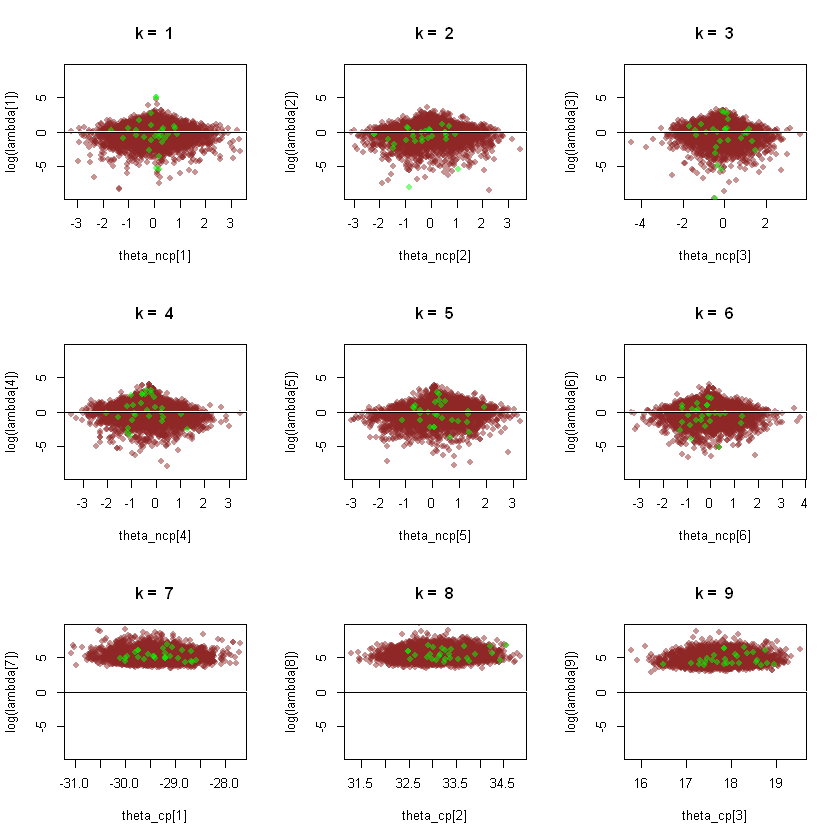

In [99]:
partition <- util$partition_div(fit)
div_params <- partition[[1]]
nondiv_params <- partition[[2]]

par(mfrow=c(3, 3))

for (k in 1:9) {
  if (k %in% data$cp_idx)
    name_x <- paste("theta_cp[", which(data$cp_idx == k), "]", sep='')
  else
    name_x <- paste("theta_ncp[", which(data$ncp_idx == k), "]", sep='')

  name_y <- paste("lambda[", k, "]", sep='')

  plot(nondiv_params[name_x][,1], log(nondiv_params[name_y][,1]),
       col=c_dark_trans, pch=16, main=paste("k = ", k),
       xlab=name_x,
       ylab=paste("log(", name_y, ")", sep=""), ylim=c(-9, 9))
  points(div_params[name_x][,1], log(div_params[name_y][,1]),
         col=c_green_trans, pch=16)
  abline(h=0, col="white", lwd=2)
  abline(h=0, col="black", lwd=1)
}

Before considering partially-centered parameterizations let's try to brute force
this the fit of this mixed parameterization.


In [100]:
start.time <- Sys.time()

fit <- stan(file='stan_programs/horseshoe_mixed.stan', data=data,
             seed=4938483, refresh=1000, control=list(adapt_delta=0.99))

end.time <- Sys.time()
computing.time <- end.time - start.time
computing.time

Warning message:
"There were 6 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them."
Warning message:
"Examine the pairs() plot to diagnose sampling problems
"


Time difference of 9.552252 secs

In [101]:
util$check_all_diagnostics(fit)

[1] "n_eff / iter looks reasonable for all parameters"
[1] "Rhat looks reasonable for all parameters"
[1] "6 of 4000 iterations ended with a divergence (0.15%)"
[1] "  Try running with larger adapt_delta to remove the divergences"
[1] "0 of 4000 iterations saturated the maximum tree depth of 10 (0%)"
[1] "E-FMI indicated no pathological behavior"


The divergent transitions have been reduced a bit but they definitely haven't
been eliminated.  The more accurate quantification of the posterior distribution
that this less aggressive adaptation achieves, however, does better show just
how oddly shaped these Cauchy funnels can be.


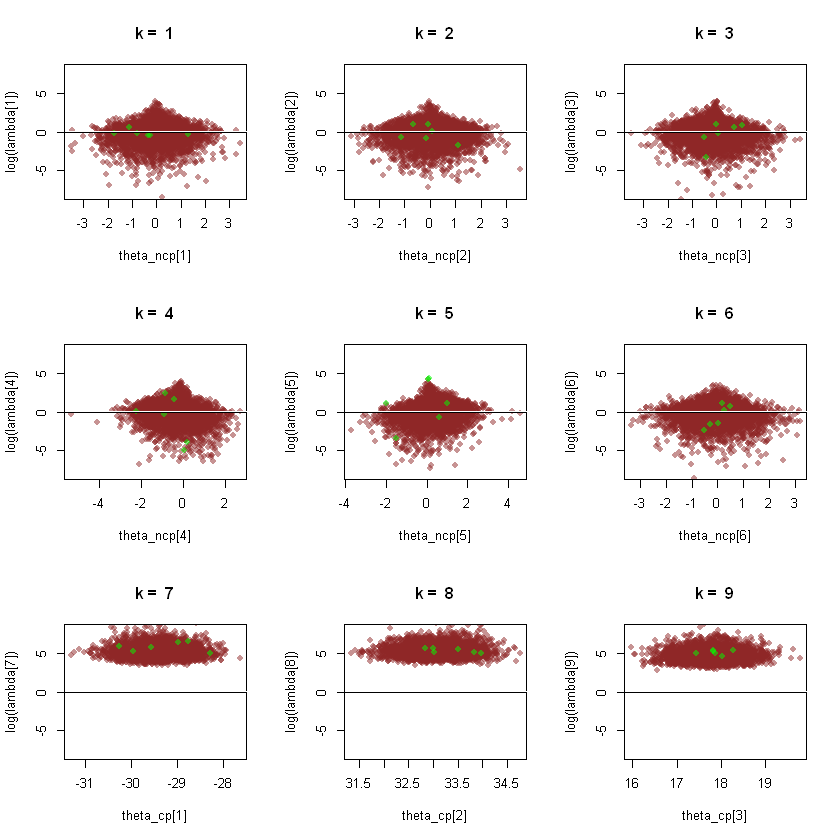

In [102]:
partition <- util$partition_div(fit)
div_params <- partition[[1]]
nondiv_params <- partition[[2]]

par(mfrow=c(3, 3))

for (k in 1:9) {
  if (k %in% data$cp_idx)
    name_x <- paste("theta_cp[", which(data$cp_idx == k), "]", sep='')
  else
    name_x <- paste("theta_ncp[", which(data$ncp_idx == k), "]", sep='')

  name_y <- paste("lambda[", k, "]", sep='')

  plot(nondiv_params[name_x][,1], log(nondiv_params[name_y][,1]),
       col=c_dark_trans, pch=16, main=paste("k = ", k),
       xlab=name_x,
       ylab=paste("log(", name_y, ")", sep=""), ylim=c(-8, 8))
  points(div_params[name_x][,1], log(div_params[name_y][,1]),
         col=c_green_trans, pch=16)
  abline(h=0, col="white", lwd=2)
  abline(h=0, col="black", lwd=1)
}

Just for completeness let's try partially-centering again.



In [103]:
writeLines(readLines("stan_programs/horseshoe_partial.stan"))

data {
  int<lower=0> K;                       // Number of contexts
  int<lower=0> N;                       // Number of observations
  vector[N] y;                          // Observations
  int<lower=1, upper=K> context_idx[N]; // Context assignments
  
  vector<lower=0, upper=1>[K] w;        // Partial centering parameters
  
  real<lower=0> sigma;                  // Measurement variability
}

parameters {
  vector[K] theta_tilde;
  vector<lower=0>[K] lambda;
  real<lower=0> tau;
}

transformed parameters {
  vector[K] theta;
  for (k in 1:K)
    theta[k] = pow(lambda[k] * tau, 1 - w[k]) * theta_tilde[k];
}

model {
  for (k in 1:K)
    theta_tilde[k] ~ normal(0, pow(lambda[k] * tau, w[k]));
  
  lambda ~ cauchy(0, 1);
  tau ~ normal(0, 0.1);

  // Observational model
  y ~ normal(theta[context_idx], sigma);
}


In [104]:
data$w <- c(0.5, 0.5, 0.5,
            0.5, 0.5, 0.5,
            1.0, 0.5, 1.0)

In [105]:
start.time <- Sys.time()

fit <- stan(file='stan_programs/horseshoe_partial.stan', data=data,
            seed=4938483, refresh=1000)

end.time <- Sys.time()
computing.time <- end.time - start.time
computing.time

Warning message:
"There were 12 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them."
Warning message:
"Examine the pairs() plot to diagnose sampling problems
"


Time difference of 45.48767 secs

In [106]:
util$check_all_diagnostics(fit)

[1] "n_eff / iter looks reasonable for all parameters"
[1] "Rhat looks reasonable for all parameters"
[1] "12 of 4000 iterations ended with a divergence (0.3%)"
[1] "  Try running with larger adapt_delta to remove the divergences"
[1] "0 of 4000 iterations saturated the maximum tree depth of 10 (0%)"
[1] "E-FMI indicated no pathological behavior"


The first six contexts still appear to be too centered.



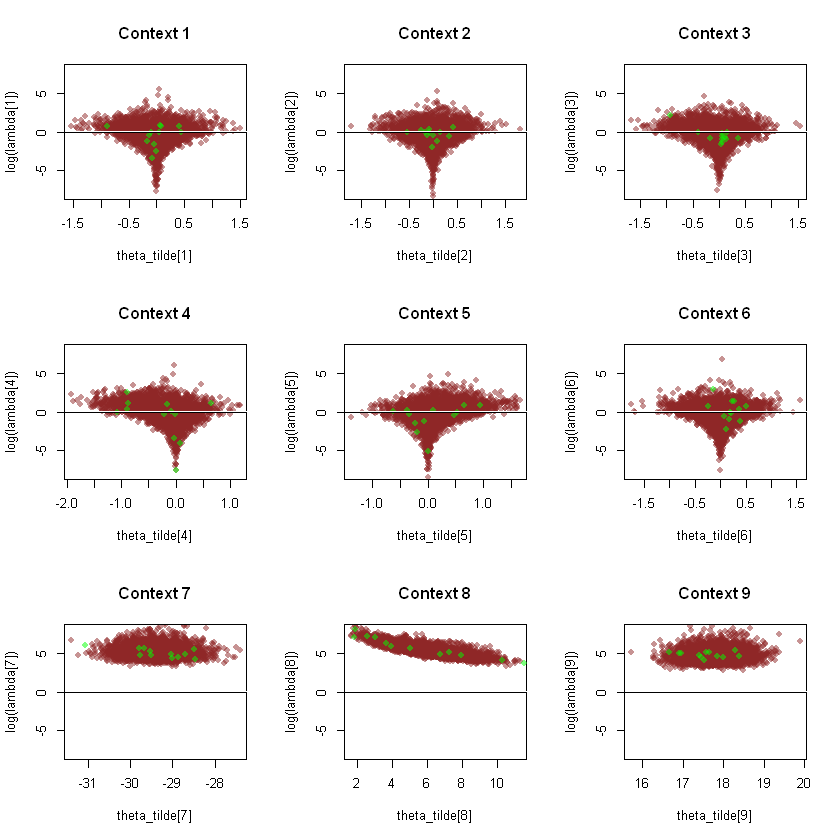

In [107]:
partition <- util$partition_div(fit)
div_params <- partition[[1]]
nondiv_params <- partition[[2]]

par(mfrow=c(3, 3))

for (k in 1:9) {
  name_x <- paste("theta_tilde[", k, "]", sep='')
  name_y <- paste("lambda[", k, "]", sep='')

  plot(nondiv_params[name_x][,1], log(nondiv_params[name_y][,1]),
       col=c_dark_trans, pch=16, main=paste("Context", k),
       xlab=name_x,
       ylab=paste("log(", name_y, ")", sep=""), ylim=c(-8, 8))
  points(div_params[name_x][,1], log(div_params[name_y][,1]),
         col=c_green_trans, pch=16)
  abline(h=0, col="white", lwd=2)
  abline(h=0, col="black", lwd=1)
}

Let's try a more non-centered parameterization.



In [108]:
data$w <- c(0.25, 0.25, 0.25,
            0.25, 0.25, 0.25,
            1.00, 0.25, 1.00)

In [109]:
start.time <- Sys.time()

fit <- stan(file='stan_programs/horseshoe_partial.stan', data=data,
            seed=4938483, refresh=1000)

end.time <- Sys.time()
computing.time <- end.time - start.time
computing.time

Warning message:
"There were 75 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them."
Warning message:
"Examine the pairs() plot to diagnose sampling problems
"


Time difference of 12.24076 secs

In [110]:
util$check_all_diagnostics(fit)

[1] "n_eff / iter looks reasonable for all parameters"
[1] "Rhat looks reasonable for all parameters"
[1] "75 of 4000 iterations ended with a divergence (1.875%)"
[1] "  Try running with larger adapt_delta to remove the divergences"
[1] "0 of 4000 iterations saturated the maximum tree depth of 10 (0%)"
[1] "E-FMI indicated no pathological behavior"


Paraphrasing the great scholar Rihanna, shine bright like a diamond you pairs
plots.  With $\tau$ no longer fixed and only limited partial pooling to
restrict it's possible values the regularization for each $\lambda_{k}$ is even
weaker now.  This allows the $\theta_{k}$-$\lambda_{k}$ funnels to be drawn out
to even more pathological extents.


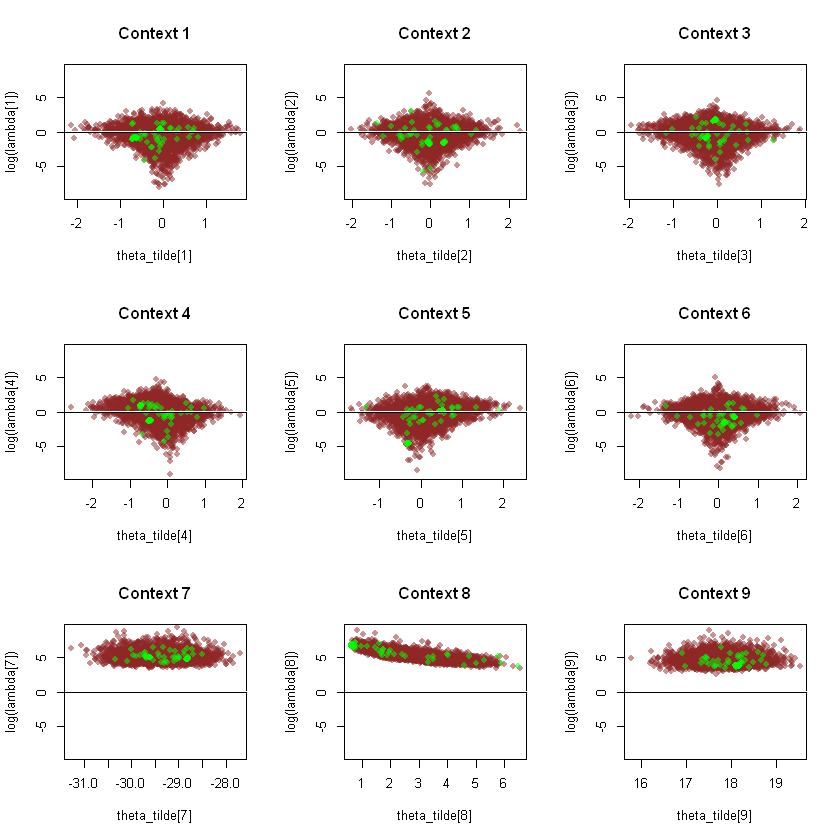

In [111]:
partition <- util$partition_div(fit)
div_params <- partition[[1]]
nondiv_params <- partition[[2]]

par(mfrow=c(3, 3))

for (k in 1:9) {
  name_x <- paste("theta_tilde[", k, "]", sep='')
  name_y <- paste("lambda[", k, "]", sep='')

  plot(nondiv_params[name_x][,1], log(nondiv_params[name_y][,1]),
       col=c_dark_trans, pch=16, main=paste("Context", k),
       xlab=name_x,
       ylab=paste("log(", name_y, ")", sep=""), ylim=c(-9, 9))
  points(div_params[name_x][,1], log(div_params[name_y][,1]),
         col=c_green_trans, pch=16)
  abline(h=0, col="white", lwd=2)
  abline(h=0, col="black", lwd=1)
}

At this point tweaking the partial-centering isn't likely to offer much help,
so let's resort to brute forcing the computation.


In [112]:
start.time <- Sys.time()

fit <- stan(file='stan_programs/horseshoe_partial.stan', data=data,
            seed=4938483, refresh=1000,
            control=list(adapt_delta=0.999, max_treedepth=15))

end.time <- Sys.time()
computing.time <- end.time - start.time
computing.time

Warning message:
"There were 1 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them."
Warning message:
"Examine the pairs() plot to diagnose sampling problems
"


Time difference of 23.14975 secs

In [113]:
util$check_all_diagnostics(fit)

[1] "n_eff / iter looks reasonable for all parameters"
[1] "Rhat looks reasonable for all parameters"
[1] "1 of 4000 iterations ended with a divergence (0.025%)"
[1] "  Try running with larger adapt_delta to remove the divergences"
[1] "2930 of 4000 iterations saturated the maximum tree depth of 10 (73.25%)"
[1] "  Run again with max_treedepth set to a larger value to avoid saturation"
[1] "E-FMI indicated no pathological behavior"


I'm exhausted.  I'm guessing that you the reader might also be exhausted, so
let's be bad people, ignore the lingering divergences, and investigate the
biased posterior inferences.

The inferred population scale is consistent with the scale of the smaller
parameters, although much of that is due to the relatively strong prior model.


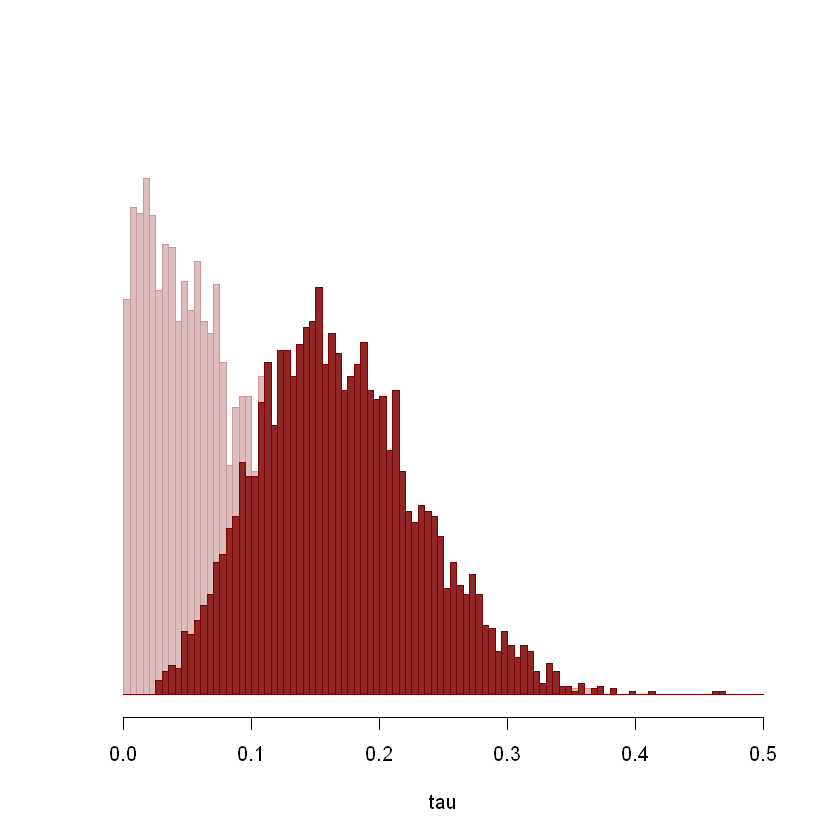

In [114]:
samples = extract(fit)

par(mfrow=c(1, 1))

hist(abs(rnorm(4000, 0, 0.1)), breaks=seq(0, 0.5, 0.005),
     main="", col=c_light, border=c_light_highlight,
     xlab="tau", yaxt='n', ylab="", ylim=c(0, 200))
hist(samples$tau, breaks=seq(0, 0.5, 0.005),
     main="", col=c_dark, border=c_dark_highlight, add=T)

Similarly the computed inferences for the $\theta_{k}$ are consistent with the
true values, both for the six small parameters and the three large parameters.


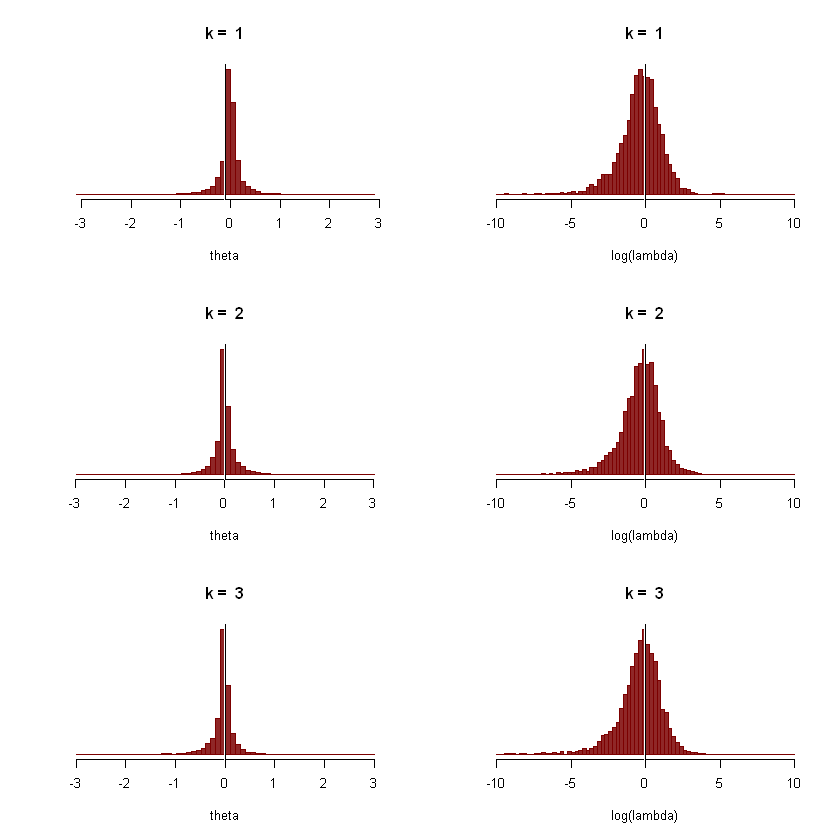

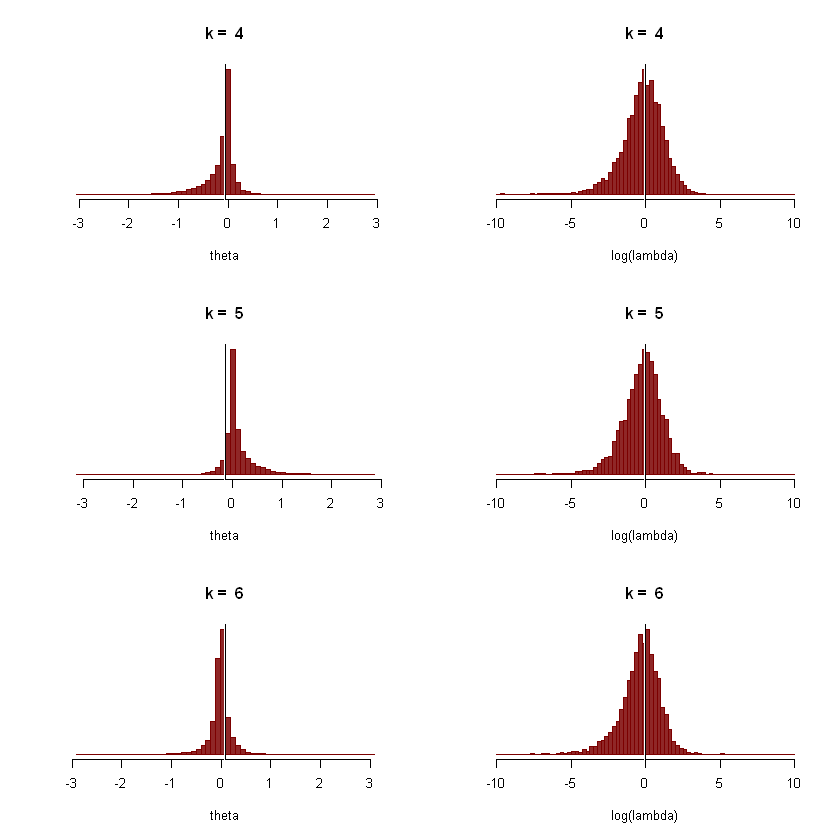

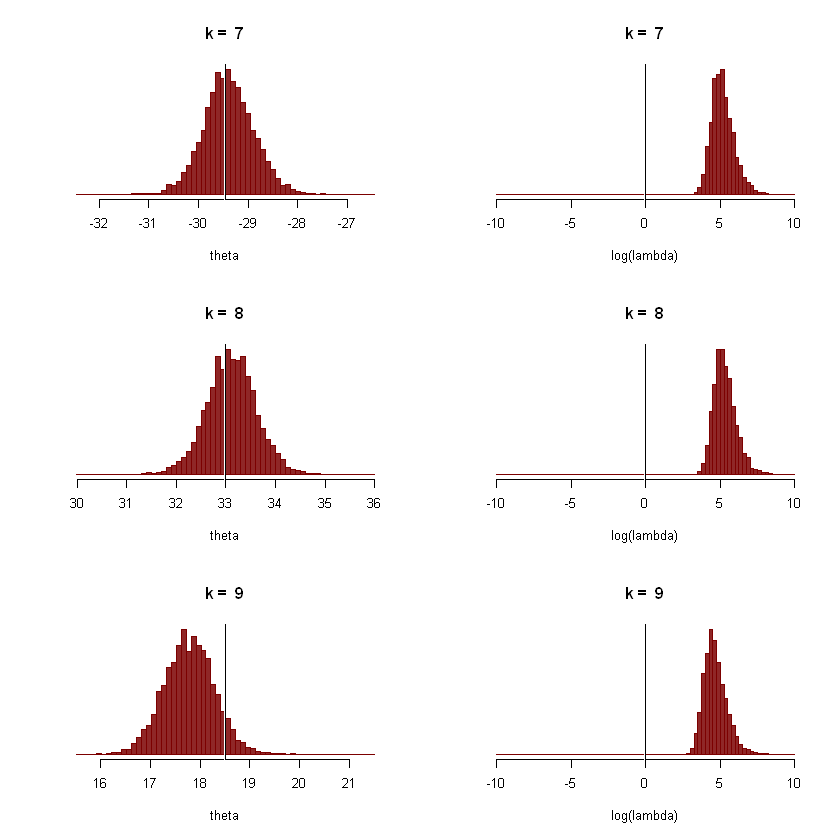

In [115]:
par(mfrow=c(3, 2))

for (k in 1:9) {
  hist(samples$theta[, k], breaks=seq(theta_true[k] - 3, theta_true[k] + 3, 0.1),
       main=paste("k = ", k), col=c_dark, border=c_dark_highlight,
       xlab="theta", yaxt='n', ylab="")
  abline(v=theta_true[k], col="white", lwd=2)
  abline(v=theta_true[k], col="black", lwd=1)

  hist(log(samples$lambda[, k]), breaks=seq(-10, 10, 0.25),
       main=paste("k = ", k), col=c_dark, border=c_dark_highlight,
       xlab="log(lambda)", yaxt='n', ylab="")
  abline(v=0, col="white", lwd=2)
  abline(v=0, col="black", lwd=1)
}

In some sense the horseshoe population model is working as expected.  The
individual $ \lambda_{k}$ give the model the freedom to decouple large parameters
from the prior regularization entirely while pooling the rest towards an inner
core.  That decoupling, however, comes at the cost of extreme funnels that
frustrate sampler exploration and are often impossible to reparameterize away
in practice.  Even knowing which parameters have large true values and which
have small true values we still have to exploit a carefully tuned
partially-centered parameterization _and_ a small step size with correspondingly
expensive numerical trajectories in order explore most of the latent horseshoe
geometry.

#### Beating A, Um, Well You Know

On top of all of these computational issues the horseshoe population model also
lacks any outer regularization capable of suppressing degenerate behavior across
larger values.  The _regularized horseshoe_ [@PiironenEtAl:2017a] runs the
inflation parameters through a deterministic function that suppresses larger
values, which implicitly introduces a second-scale beyond $ \tau$ that regularizes
larger values.  Although this outer regularization can work well the
pathological interactions between $\theta_{k}$ and $\lambda_{k}$ in each context
remain.

One way to suppress the worst of those interactions is to replace the
half-Cauchy model for the $\lambda_{k}$ with another model that features lighter
tails, for example a half-Student's t model that can interpolate between the
nominal half-Cauchy model and a much lighter-tailed half-normal model.  By
allocating less probability to extreme values of $\lambda_{k}$ this modified
model rounds out those infuriating diamonds at the expense of slightly stronger
regularization above $\tau$.  At the same time these lighter tails can lead to
less effective separation of the inferences between small and large parameters.

In the end while these modifications of the horseshoe population model can help
they typically don't achieve any better performance in practice than a Cauchy
population model or the binary mixture normal population model, both of which
are much easier to configure and accurately fit out of the box.  Consequently
it's hard to argue for the practical utility of the horseshoe model.

# We Built Sparse City On Rock and Roll

To see how we might wield sparsity in a more realistic modeling situation let's
consider a hypothetical application where we want to understand the sales of a
small company.  This hypothetical company has a few locations across town, each
selling a few hundred units a day.

Those sales, however, are known to vary throughout the year.  Firstly there is
a significant yearly periodicity across which sales can vary by hundreds of
units; sales typically bottom out a few weeks into the beginning of the year.
Secondly there are sudden, sporadic variations in the daily sales throughout the
year.  These are often hypothesized to be due to distinct but unpredictable
events that draw customers into the stores -- or at times drive them away.

In order to understand these behaviors we've collected (okay, fine, I simulated)
almost a year's worth of daily sales data.

In [116]:
data <- read_rdump("data/sales.data.R")

In [117]:
names(data)

[1] "obs_day_idx"  "N_obs_days"   "N_obs"        "y_obs"        "pred_day_idx"
[6] "N_pred_days"  "y_pred"

The data itself has been partitioned into two groups -- the first
`N_obs_days = 370` days will be used to infer sales patterns while the final
`N_pred = 100` days will be used to study how well we can forecast sales based
on those inferences.


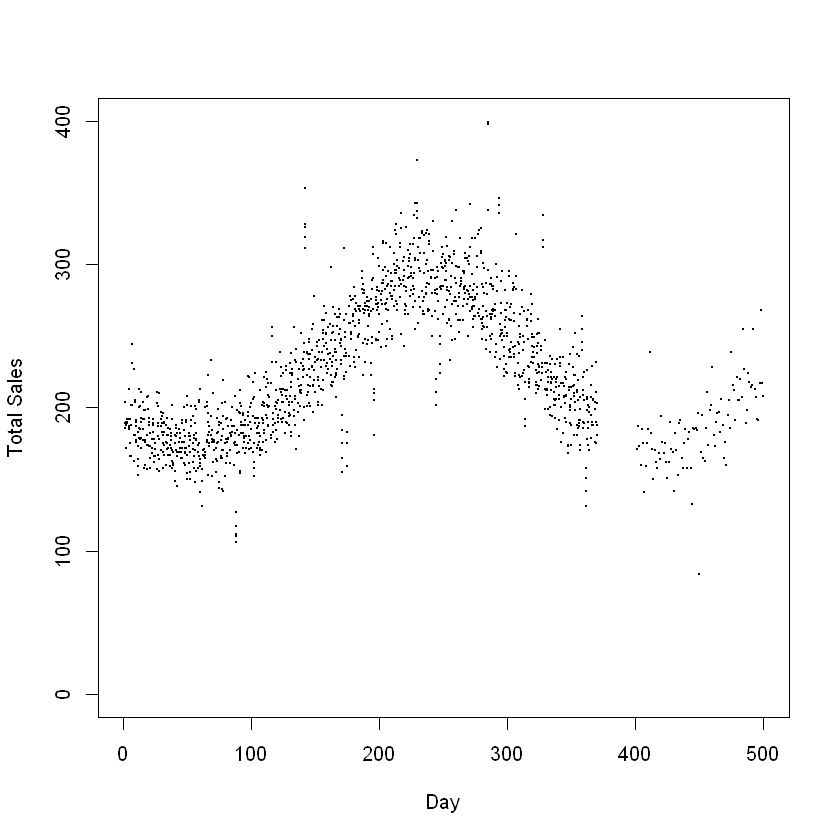

In [118]:
par(mfrow=c(1, 1))

plot(c(data$obs_day_idx, data$pred_day_idx),
     c(data$y_obs, data$y_pred),
     col="black", pch=16, cex=0.25,
     xlab="Day", xlim=c(0, 500),
     ylab="Total Sales", ylim=c(0, 400))

For pedagogical purposes we also have the underlying sales behavior, but we
won't take a look at this until after we've built our first model.


In [119]:
truth <- read_rdump("data/sales.truth.R")

Finally let's define some new colors for this investigation and load in a few
utility functions that will be handy for visualizing our results and quantifying
the performance of our forecasts.


In [120]:
c_light_teal <- c("#6B8E8E")
c_mid_teal <- c("#487575")
c_dark_teal <- c("#1D4F4F")

In [121]:
source('sparse_utility.R', local=util)

## Normal Population Model

Let's model the unstructured variation in the sales data with a negative
binomial observational model.  Here we assume that the variation is unlikely to
be too much more dispersed than a pure Poisson model so we can constrain the
dispersion parameter $ \psi^{-1}$ to be close to zero.

The seasonal variation can then be captured by modeling the log location
parameter of the negative binomial model as the sum of a baseline daily sales
parameter $\alpha$ and a sinusoidal function with frequency equal to 360 days
and a phase $\phi$ softly constrained between one and two weeks.  Our domain
expertise that typically daily sales number a few hundred informs a prior model
for $\alpha$, while our domain expertise on the strength of the seasonal
fluctuation in sales informs a prior model on the amplitude of the sinusoidal
function.  Here we want to constrain the seasonal variation to around $50\%$.

Finally we have to model the excess sales variation due to sporadic,
unpredictable events.  The very fact that these variations are known to be
sporadic already indicates that these influences should be sparse, but before
trying any of the strategies for encoding sparsity assumptions in our model
let's first try adding daily parameters pooled together only with a single
normal population model.  Domain expertise that these surprising variations are
usually no greater than $10\%$ suggests a prior model that constrains the
population scale to around $\log(1.1)$.

In [122]:
writeLines(readLines("stan_programs/fit_sales_normal.stan"))

data {
  int<lower=0> N_obs; // Number of sales observations
  int y_obs[N_obs];  // Daily units sold
  
  int<lower=0> N_obs_days;                           // Number of days observed
  int<lower=1, upper=N_obs_days> obs_day_idx[N_obs]; // Day of each observation
  
  int<lower=0> N_pred_days;                        // Number of future days to predict
  int<lower=N_obs_days> pred_day_idx[N_pred_days]; // Day of each prediction

  int<lower=0, upper=N_obs_days> K_cp;
  int<lower=0, upper=N_obs_days> cp_idx[K_cp];

  int<lower=0, upper=N_obs_days> K_ncp;
  int<lower=0, upper=N_obs_days> ncp_idx[K_ncp];
}

parameters {
  vector[K_cp] delta_days_cp;   // Daily excess
  vector[K_ncp] delta_days_ncp; // Daily excess
  real<lower=0> tau_day;        // Weekly log variation scale
  
  real alpha;                   // Baseline sales per day
  real<lower=0> delta_season;   // Amplitude of log seasonal variation
  real delta_phi;               // Phase of seasonal variation from 10.5 days
  real<

With only a few observations per day let's start by non-centering all of these
daily variation parameters.


In [123]:
data$cp_idx <- vector()
data$K_cp <- length(data$cp_idx)

data$ncp_idx <- setdiff(1:data$N_obs_days, data$cp_idx)
data$K_ncp <- length(data$ncp_idx)

In [124]:
start.time <- Sys.time()

normal_fit <- stan(file='stan_programs/fit_sales_normal.stan', data=data,
                   seed=4938483, refresh=1000)

end.time <- Sys.time()
computing.time <- end.time - start.time
computing.time

Time difference of 1.832837 mins

Fortunately this parameterization appears to have been wise as Stan has no
problems exploring the posterior distribution.


In [125]:
util$check_all_diagnostics(normal_fit)

[1] "n_eff / iter looks reasonable for all parameters"
[1] "Rhat looks reasonable for all parameters"
[1] "0 of 4000 iterations ended with a divergence (0%)"
[1] "0 of 4000 iterations saturated the maximum tree depth of 10 (0%)"
[1] "E-FMI indicated no pathological behavior"


Let's investigate our inferences by examining the marginal posterior
distribution for each of the parameters.  In particular let's compare to the
true values from which the data were simulated when possible.

We've learned the seasonality behavior extremely well. The inferred scale of
the daily variations is a bit large relative to the prior model indicating that
at least some of the daily variations are much larger than the assumed $10\%$.


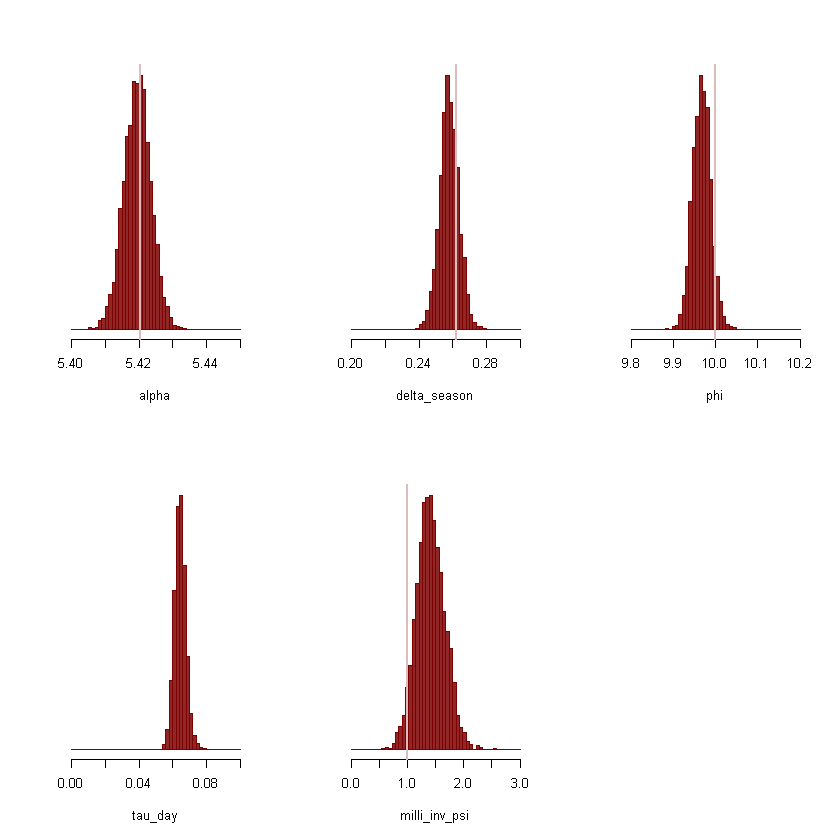

In [126]:
samples = extract(normal_fit)

par(mfrow=c(2, 3))

hist(samples$alpha, breaks=seq(5.40, 5.45, 0.05 / 50),
     main="", xlab="alpha", yaxt='n', ylab="",
     col=c_dark, border=c_dark_highlight)
abline(v=truth$alpha, col=c_light, lty=1, lw=2)

hist(samples$delta_season, seq(0.2, 0.3, 0.1 / 50),
     main="", xlab="delta_season", yaxt='n', ylab="",
     col=c_dark, border=c_dark_highlight)
abline(v=truth$delta_season, col=c_light, lty=1, lw=2)

hist(samples$phi, seq(9.8, 10.2, 0.4 / 50),
     main="", xlab="phi", yaxt='n', ylab="",
     col=c_dark, border=c_dark_highlight)
abline(v=truth$phi, col=c_light, lty=1, lw=2)

hist(samples$tau_day, seq(0, 0.1, 0.1 / 50),
     main="", xlab="tau_day", yaxt='n', ylab="",
     col=c_dark, border=c_dark_highlight)

hist(samples$milli_inv_psi, seq(0, 3, 3 / 50),
     main="", xlab="milli_inv_psi", yaxt='n', ylab="",
     col=c_dark, border=c_dark_highlight)
abline(v=1000 * truth$inv_psi, col=c_light, lty=1, lw=2)

Unfortunately if we look at the ensemble of inferences for each daily variation
we see some issues.  There is indeed sparsity in the true values, shown here in
teal, but the single normal population model cannot accommodate both small and
large values at the same time.  Instead inferences for the small values are
under-regularized and inferences for the large values are strongly
over-regularized.


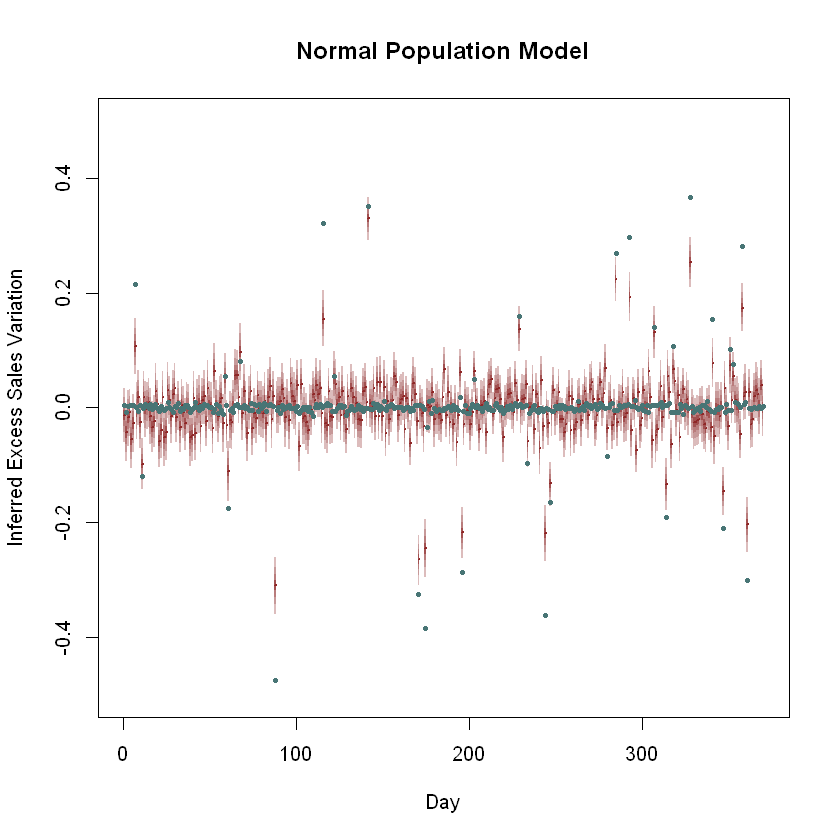

In [127]:
par(mfrow=c(1, 1))

util$plot_excess_variation(samples, data, truth, "Normal Population Model")

Subtracting the true values from the marginal posteriors clearly reveals this
ineffective regularization in the residuals.


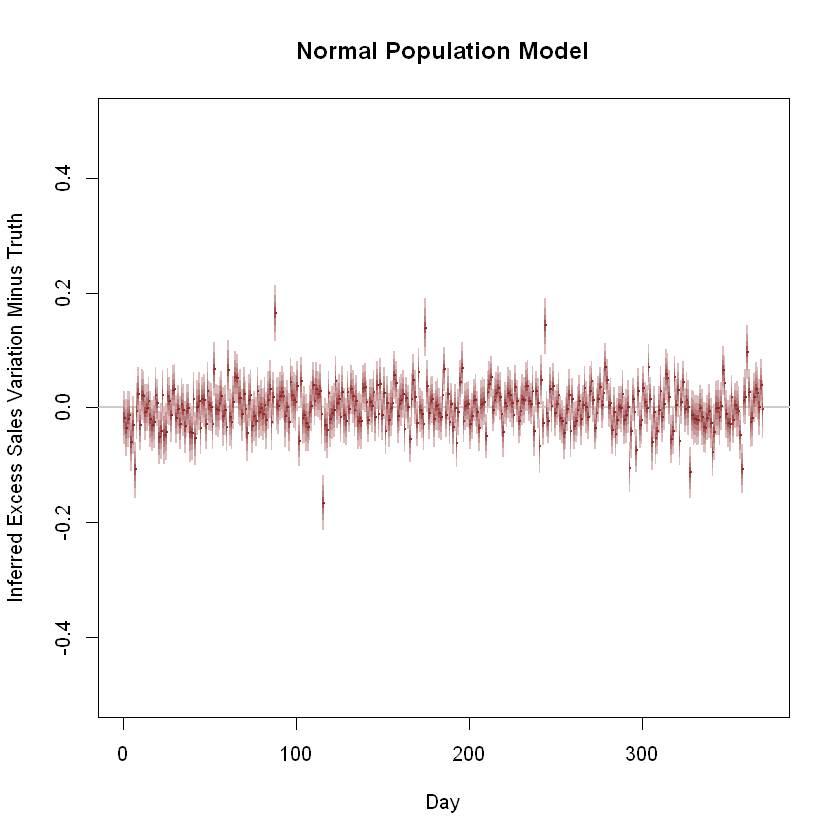

In [128]:
util$plot_excess_variation_residual(samples, data, truth, "Normal Population Model")

In order to provide some quantification for how well our models are inferring
all of the daily sales variations let's use an empirical continuous rank
probability score as discussed in [Appendix B](#sec:ecrps).


In [129]:
ecrps <- util$sum_empirical_crps(samples$delta_days, truth$delta_days)
infer_crps_comp <- data.frame("Normal" = ecrps)
row.names(infer_crps_comp) = "Inferential ECRPS"

print(infer_crps_comp)

                  Normal
Inferential ECRPS 6.7729


This number doesn't mean much on its own but it will provide one way of
comparing the performance between our different models.

Given our inferences we can reconstruct the expected sales over the observation
period.  We seem to be capturing the overall sales trends reasonably well but
our model isn't flexible enough to really capture those deviant days.


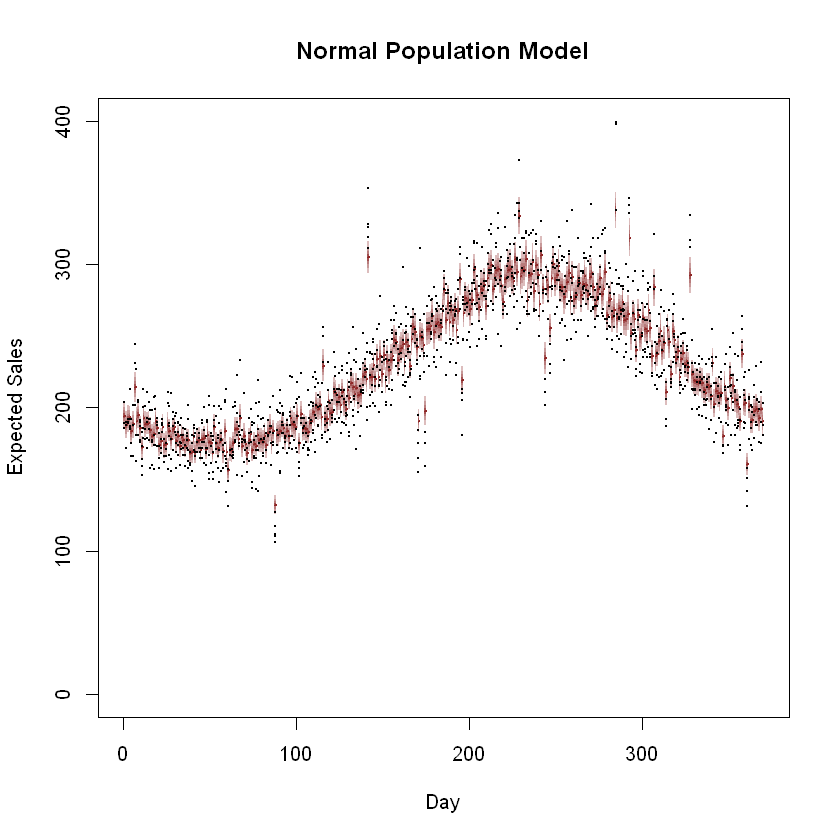

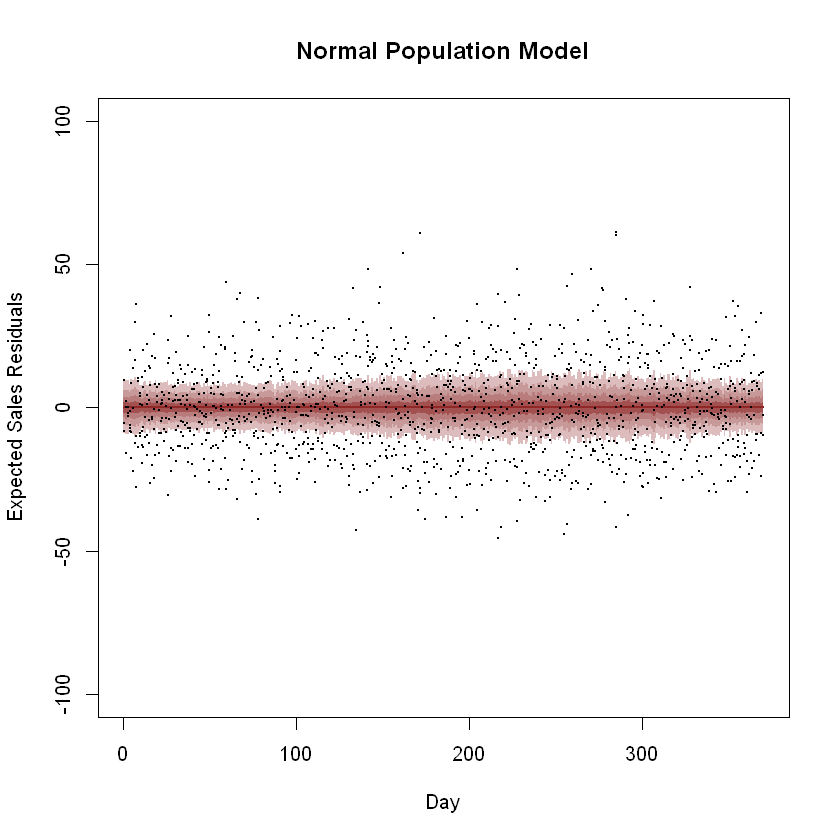

In [130]:
util$plot_expected_sales(samples, data, "Normal Population Model")

util$plot_expected_sales_residual(samples, data, "Normal Population Model")

To really make a proper comparison between our model and the observed sales
data, however, we need to compare apples to apples, or rather sales to sales.
Here we can compare the observations to the posterior predictive distribution,
which forms a posterior retrodictive check for the first part of the data and
a posterior predictive check for the second part of the data.

Again the model is doing okay overall but struggling with the deviant days.


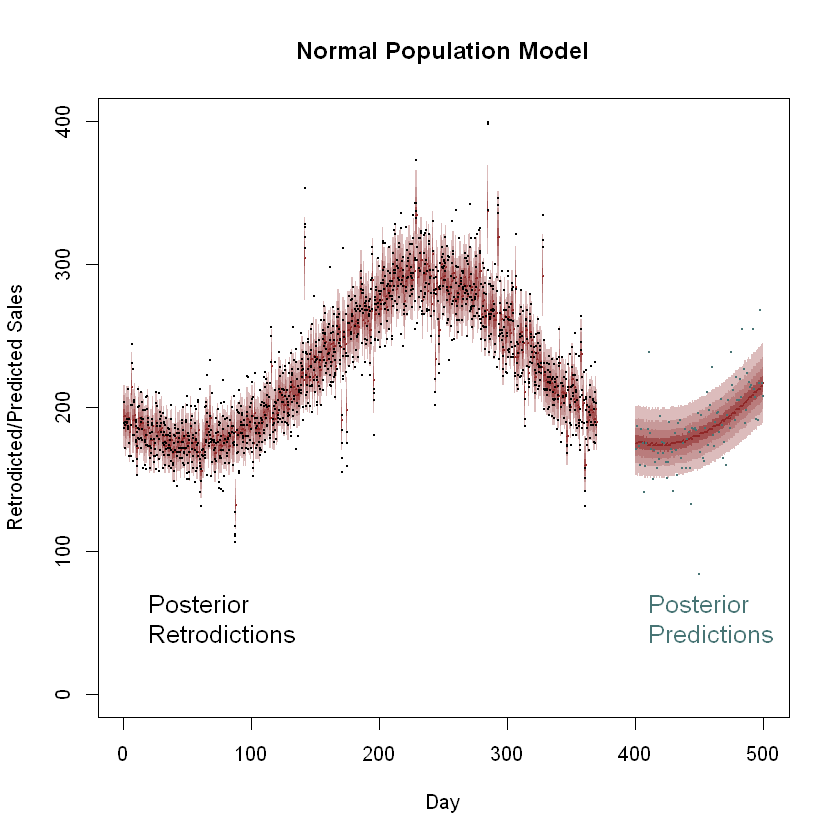

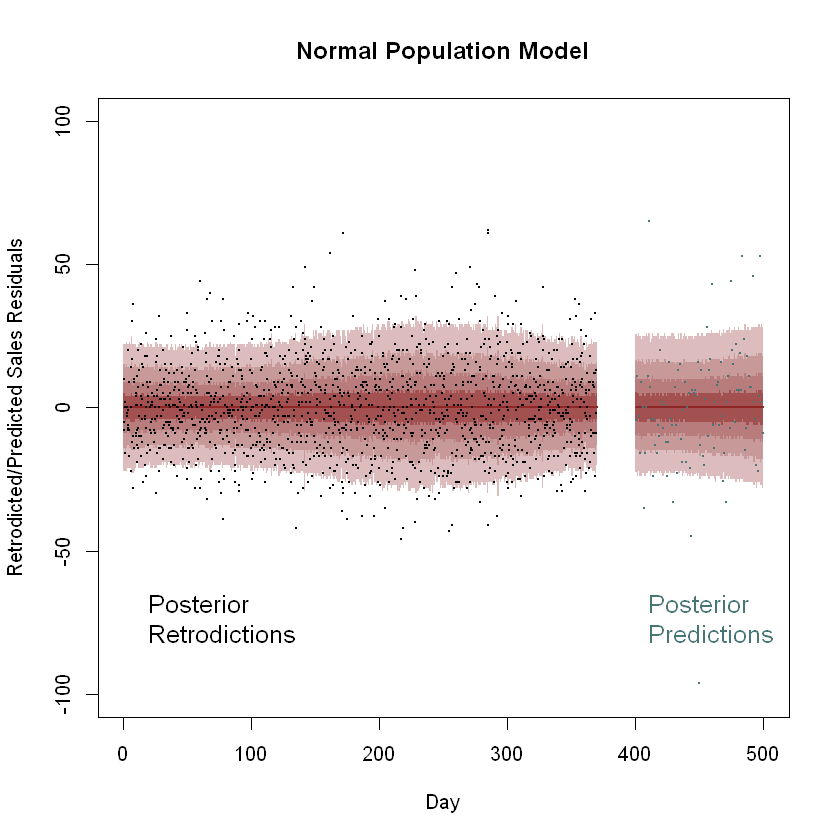

In [131]:
util$plot_dictions(samples, data, "Normal Population Model")

util$plot_dictions_residual(samples, data, "Normal Population Model")

Let's employ an empirical continuous rank probability score one more time to
quantify how well the posterior predictive forecast captures the future
observations held out from our inferences.


In [132]:
ecrps <- util$sum_empirical_crps(samples$y_post_pre, data$y_pred)
pred_crps_comp <- data.frame("Normal" = ecrps)
row.names(pred_crps_comp) = "Predictive ECRPS"

print(pred_crps_comp)

                   Normal
Predictive ECRPS 1109.773


## Laplace Population Model

To do better we need to encode an assumption of sparsity into our prior model.
Let's first try a single, heavier-tailed Laplace population model.


In [133]:
writeLines(readLines("stan_programs/fit_sales_laplace.stan"))

data {
  int<lower=0> N_obs; // Number of sales observations
  int y_obs[N_obs];  // Daily units sold
  
  int<lower=0> N_obs_days;                           // Number of days observed
  int<lower=1, upper=N_obs_days> obs_day_idx[N_obs]; // Day of each observation
  
  int<lower=0> N_pred_days;                        // Number of future days to predict
  int<lower=N_obs_days> pred_day_idx[N_pred_days]; // Day of each prediction

  int<lower=0, upper=N_obs_days> K_cp;
  int<lower=0, upper=N_obs_days> cp_idx[K_cp];

  int<lower=0, upper=N_obs_days> K_ncp;
  int<lower=0, upper=N_obs_days> ncp_idx[K_ncp];
}

parameters {
  vector[K_cp] delta_days_cp;   // Daily excess
  vector[K_ncp] delta_days_ncp; // Daily excess
  
  real alpha;                   // Baseline sales per day
  real<lower=0> delta_season;   // Amplitude of log seasonal variation
  real delta_phi;               // Phase of seasonal variation from 10.5 days
  real<lower=0> tau_day;        // Weekly log variation scale
  real<

As we saw above we have to be careful with how we parameterize the individual
parameters with a heavier tailed population model, in particular we'll want to
center the parameters concentrating at larger values and non-center the rest.
Because we've already fit the normal population model let's use those inferences
to inform a heuristic split between "small" and "large" parameters.  If this
initial guess is wrong then we'll see divergent transitions and we can identify
which parameterizations to change by looking for funnels in the pairs plots.


In [134]:
data$cp_idx <- which(abs(sapply(1:data$N_obs_day,
                                function(n) mean(samples$delta_days[, n]))) > 0.05)
data$K_cp <- length(data$cp_idx)

data$ncp_idx <- setdiff(1:data$N_obs_days, data$cp_idx)
data$K_ncp <- length(data$ncp_idx)

In [135]:
start.time <- Sys.time()

laplace_fit <- stan(file='stan_programs/fit_sales_laplace.stan', data=data,
                    seed=4938483, refresh=1000)

end.time <- Sys.time()
computing.time <- end.time - start.time
computing.time

Time difference of 2.67975 mins

Fortunately this initial parameterization seems to be doing well enough.



In [136]:
util$check_all_diagnostics(laplace_fit)

[1] "n_eff / iter looks reasonable for all parameters"
[1] "Rhat looks reasonable for all parameters"
[1] "0 of 4000 iterations ended with a divergence (0%)"
[1] "0 of 4000 iterations saturated the maximum tree depth of 10 (0%)"
[1] "E-FMI indicated no pathological behavior"


Our inferences are largely unchanged except for the population scale which,
due to the Laplace population model, is able to move towards zero to better
accommodate the smaller parameters.


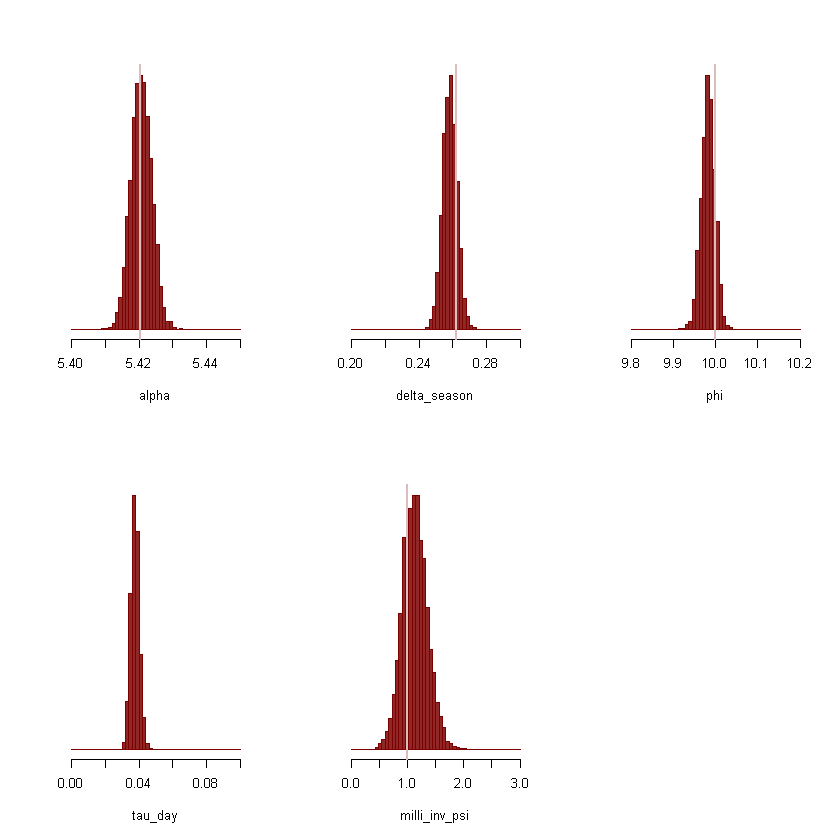

In [137]:
samples = extract(laplace_fit)

par(mfrow=c(2, 3))

hist(samples$alpha, breaks=seq(5.40, 5.45, 0.05 / 50),
     main="", xlab="alpha", yaxt='n', ylab="",
     col=c_dark, border=c_dark_highlight)
abline(v=truth$alpha, col=c_light, lty=1, lw=2)

hist(samples$delta_season, seq(0.2, 0.3, 0.1 / 50),
     main="", xlab="delta_season", yaxt='n', ylab="",
     col=c_dark, border=c_dark_highlight)
abline(v=truth$delta_season, col=c_light, lty=1, lw=2)

hist(samples$phi, seq(9.8, 10.2, 0.4 / 50),
     main="", xlab="phi", yaxt='n', ylab="",
     col=c_dark, border=c_dark_highlight)
abline(v=truth$phi, col=c_light, lty=1, lw=2)

hist(samples$tau_day, seq(0, 0.1, 0.1 / 50),
     main="", xlab="tau_day", yaxt='n', ylab="",
     col=c_dark, border=c_dark_highlight)

hist(samples$milli_inv_psi, seq(0, 3, 3 / 50),
     main="", xlab="milli_inv_psi", yaxt='n', ylab="",
     col=c_dark, border=c_dark_highlight)
abline(v=1000 * truth$inv_psi, col=c_light, lty=1, lw=2)

The benefit of the heavier tails is also evident in how well the marginal
posterior distribution for each daily variation parameter captures the true
value.  Although not perfect the posterior distributions for parameters with
larger true values are able to reach further and the rest are more strongly
regularized towards zero.


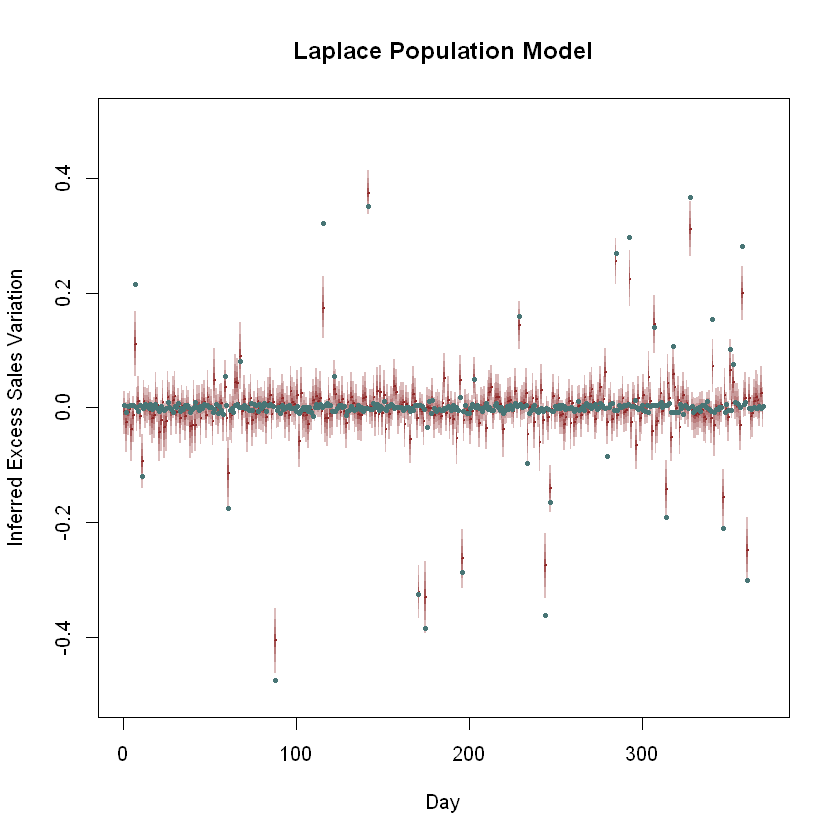

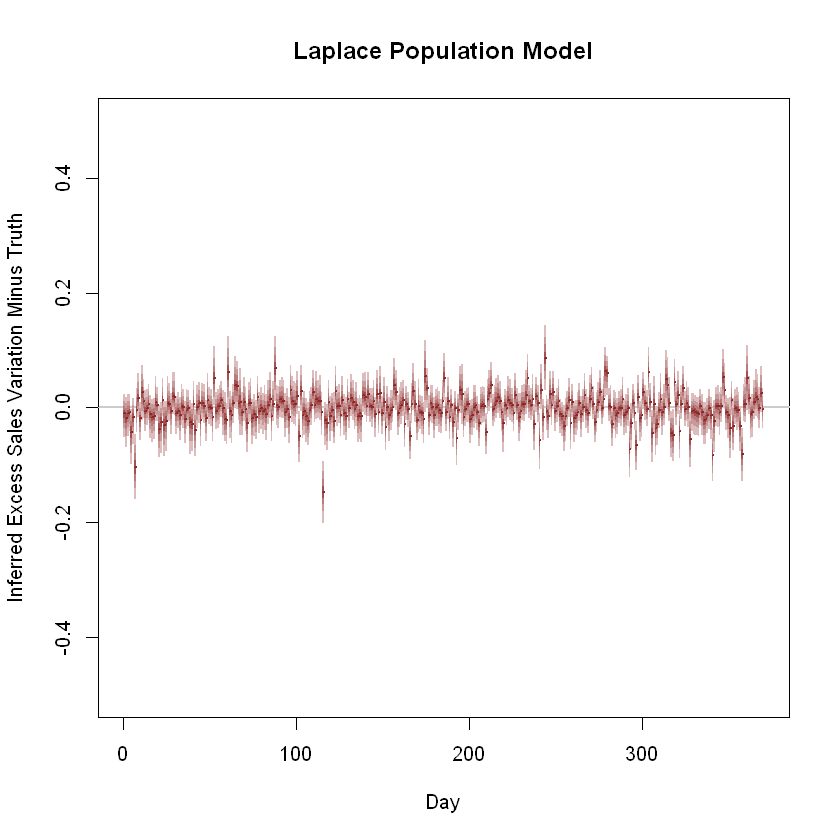

In [138]:
par(mfrow=c(1, 1))

util$plot_excess_variation(samples, data, truth, "Laplace Population Model")

util$plot_excess_variation_residual(samples, data, truth, "Laplace Population Model")

This manifests in a smaller empirical continuous rank probability score, which
indicates better performance.


In [139]:
infer_crps_comp["Laplace"] = util$sum_empirical_crps(samples$delta_days, truth$delta_days)
print(infer_crps_comp)

                  Normal  Laplace
Inferential ECRPS 6.7729 4.548471


These more accurate inference result in the model being better able to capture
the full temporal variation in expected sales.


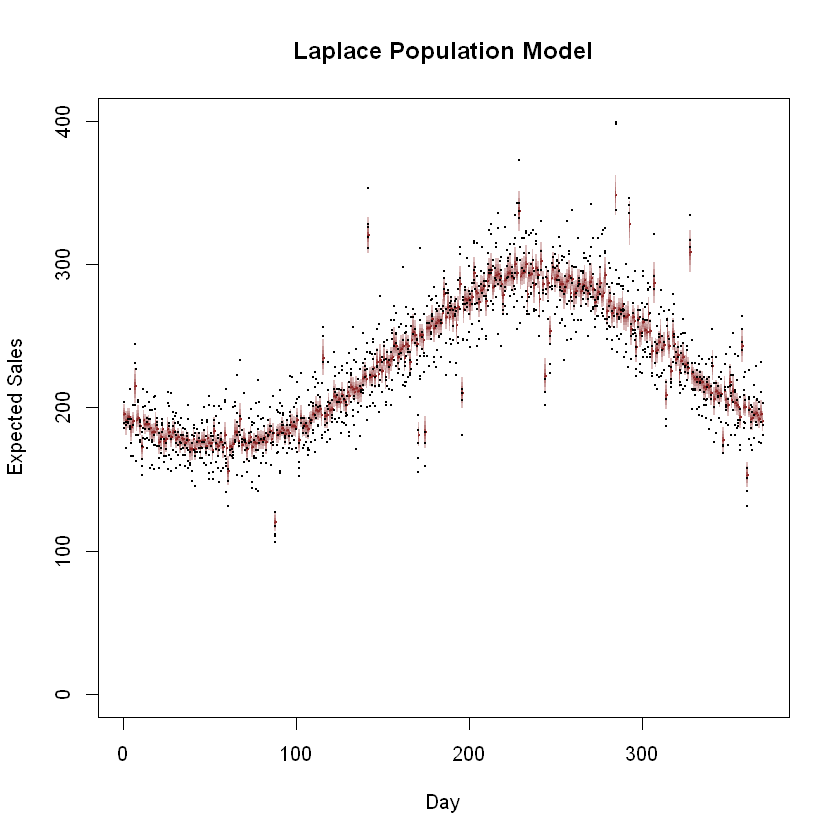

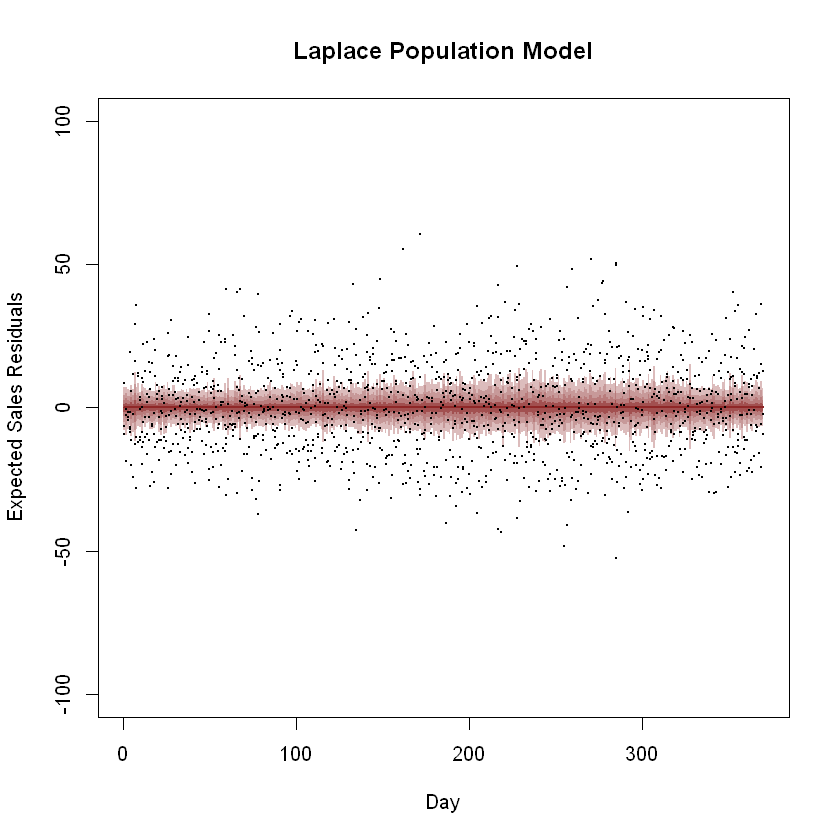

In [140]:
util$plot_expected_sales(samples, data, "Laplace Population Model")

util$plot_expected_sales_residual(samples, data, "Laplace Population Model")

The posterior predictions don't seem to have changed much, but that's largely
an artifact of using marginal quantiles to construct the ribbons in this
visualization.  In particular while the bounding 10% and 90% quantiles are
easier to estimate they do not show the heavy tail in the posterior predictive
distribution all that well.


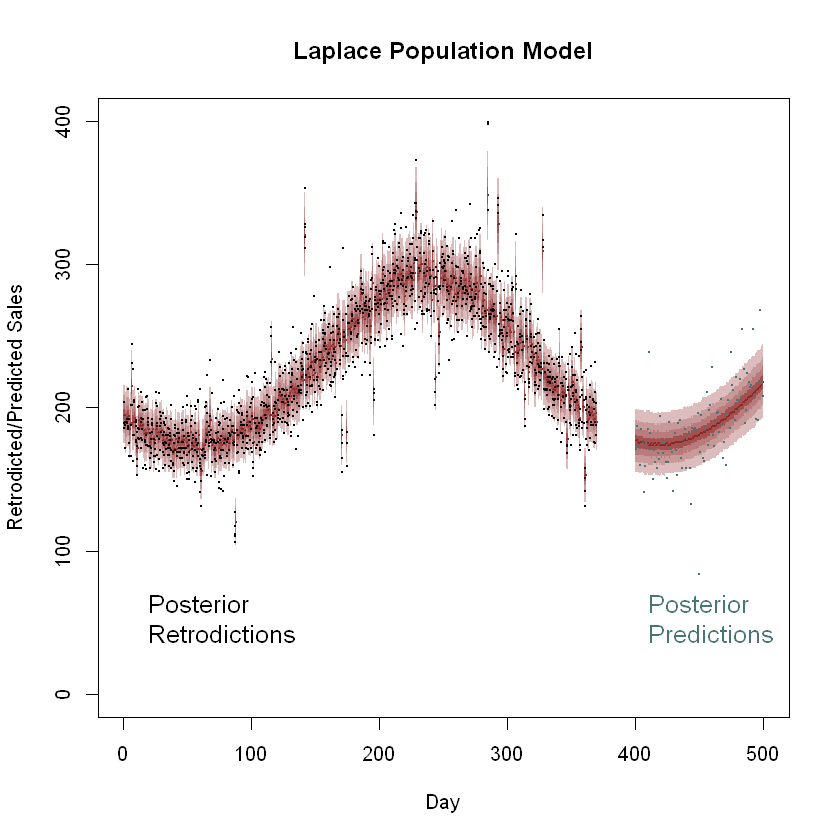

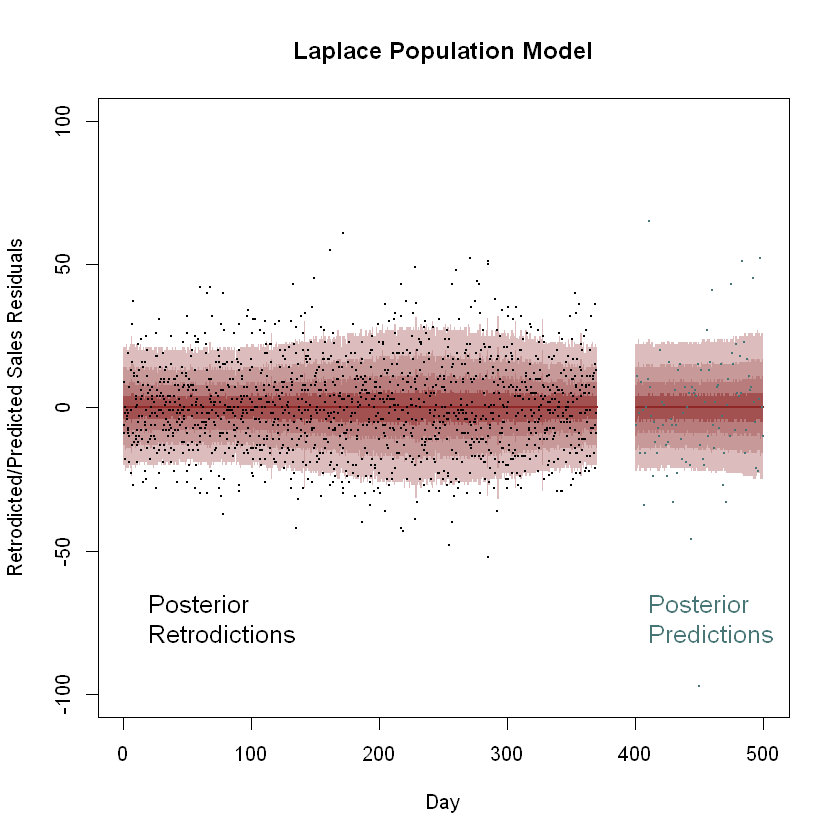

In [141]:
util$plot_dictions(samples, data, "Laplace Population Model")

util$plot_dictions_residual(samples, data, "Laplace Population Model")

Overall, however, the forecasting performance of the posterior predictive
distribution is basically equivalent to the normal population model.


In [142]:
pred_crps_comp["Laplace"] = util$sum_empirical_crps(samples$y_post_pre, data$y_pred)
print(pred_crps_comp)

                   Normal  Laplace
Predictive ECRPS 1109.773 1098.318


## Cauchy Population Model

What if we go even heavier with a Cauchy population model?


In [143]:
writeLines(readLines("stan_programs/fit_sales_cauchy.stan"))

data {
  int<lower=0> N_obs; // Number of sales observations
  int y_obs[N_obs];  // Daily units sold
  
  int<lower=0> N_obs_days;                           // Number of days observed
  int<lower=1, upper=N_obs_days> obs_day_idx[N_obs]; // Day of each observation
  
  int<lower=0> N_pred_days;                        // Number of future days to predict
  int<lower=N_obs_days> pred_day_idx[N_pred_days]; // Day of each prediction

  int<lower=0, upper=N_obs_days> K_cp;
  int<lower=0, upper=N_obs_days> cp_idx[K_cp];

  int<lower=0, upper=N_obs_days> K_ncp;
  int<lower=0, upper=N_obs_days> ncp_idx[K_ncp];
}

parameters {
  vector[K_cp] delta_days_cp;   // Daily excess
  vector[K_ncp] delta_days_ncp; // Daily excess
  real<lower=0> tau_day;        // Weekly log variation scale
    
  real alpha;                   // Baseline sales per day
  real<lower=0> delta_season;   // Amplitude of log seasonal variation
  real delta_phi;               // Phase of seasonal variation from 10.5 days
  rea

We'll use the same mixed centering and non-centering that we used for the
Laplace population model, but to avoid initializations that might get stuck out
in those heavy, heavy Cauchy tails we'll restrict the range of random initial
values from Stan's default of $[-2, 2]$ on the unconstrained scale to
$[-1, 1]$.  Given that our prior model for the population scale suppresses
values far above $\log(1.1) \approx 0.1$ this will still lead to overall very
conservative initializations.


In [144]:
start.time <- Sys.time()

cauchy_fit <- stan(file='stan_programs/fit_sales_cauchy.stan', data=data,
                    seed=4938483, refresh=1000, init_r=1)

end.time <- Sys.time()
computing.time <- end.time - start.time
computing.time

Warning message:
"Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess"


Time difference of 4.244065 mins

That initial parameterization still appears to be well-suited to the Cauchy
population model.


In [145]:
util$check_all_diagnostics(cauchy_fit)

[1] "n_eff / iter looks reasonable for all parameters"
[1] "Rhat looks reasonable for all parameters"
[1] "0 of 4000 iterations ended with a divergence (0%)"
[1] "0 of 4000 iterations saturated the maximum tree depth of 10 (0%)"
[1] "E-FMI indicated no pathological behavior"


As with the Laplace population model fit most of the inferences are unchanged.
The only strong difference is the population scale which has now dropped to
even smaller values without having to accommodate the larger deviations.


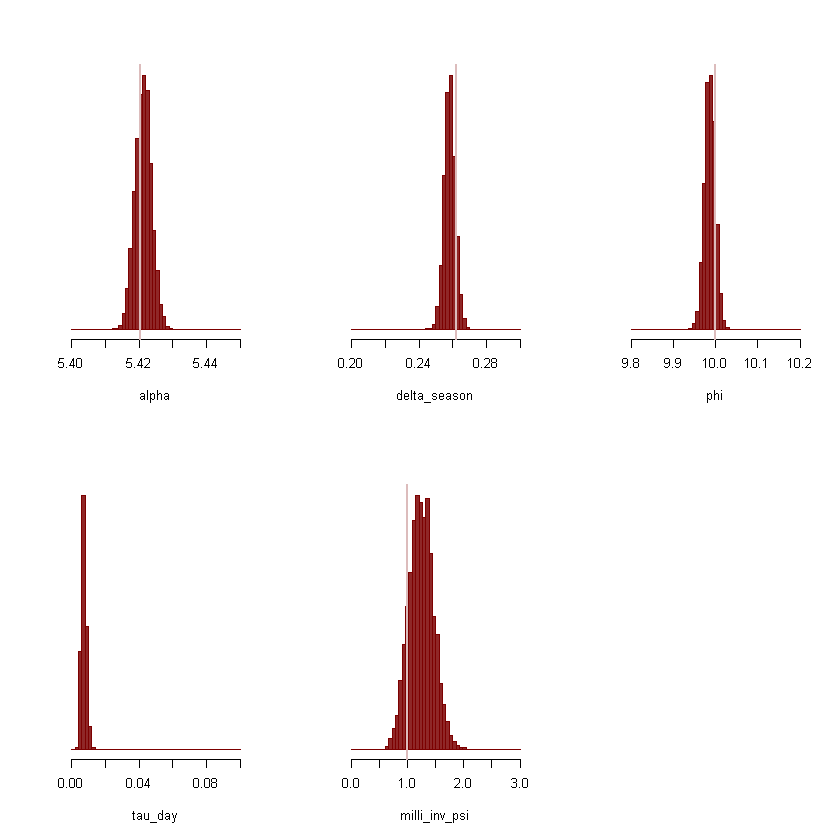

In [146]:
samples = extract(cauchy_fit)

par(mfrow=c(2, 3))

hist(samples$alpha, breaks=seq(5.40, 5.45, 0.05 / 50),
     main="", xlab="alpha", yaxt='n', ylab="",
     col=c_dark, border=c_dark_highlight)
abline(v=truth$alpha, col=c_light, lty=1, lw=2)

hist(samples$delta_season, seq(0.2, 0.3, 0.1 / 50),
     main="", xlab="delta_season", yaxt='n', ylab="",
     col=c_dark, border=c_dark_highlight)
abline(v=truth$delta_season, col=c_light, lty=1, lw=2)

hist(samples$phi, seq(9.8, 10.2, 0.4 / 50),
     main="", xlab="phi", yaxt='n', ylab="",
     col=c_dark, border=c_dark_highlight)
abline(v=truth$phi, col=c_light, lty=1, lw=2)

hist(samples$tau_day, seq(0, 0.1, 0.1 / 50),
     main="", xlab="tau_day", yaxt='n', ylab="",
     col=c_dark, border=c_dark_highlight)

hist(samples$milli_inv_psi, seq(0, 3, 3 / 50),
     main="", xlab="milli_inv_psi", yaxt='n', ylab="",
     col=c_dark, border=c_dark_highlight)
abline(v=1000 * truth$inv_psi, col=c_light, lty=1, lw=2)

With those ample tails the Cauchy population model can accommodate the more
common smaller values that cluster into an inner core and the occasional larger
values that make up the outer extent.  Notice how much narrower the inferences
for the inner core parameters are!


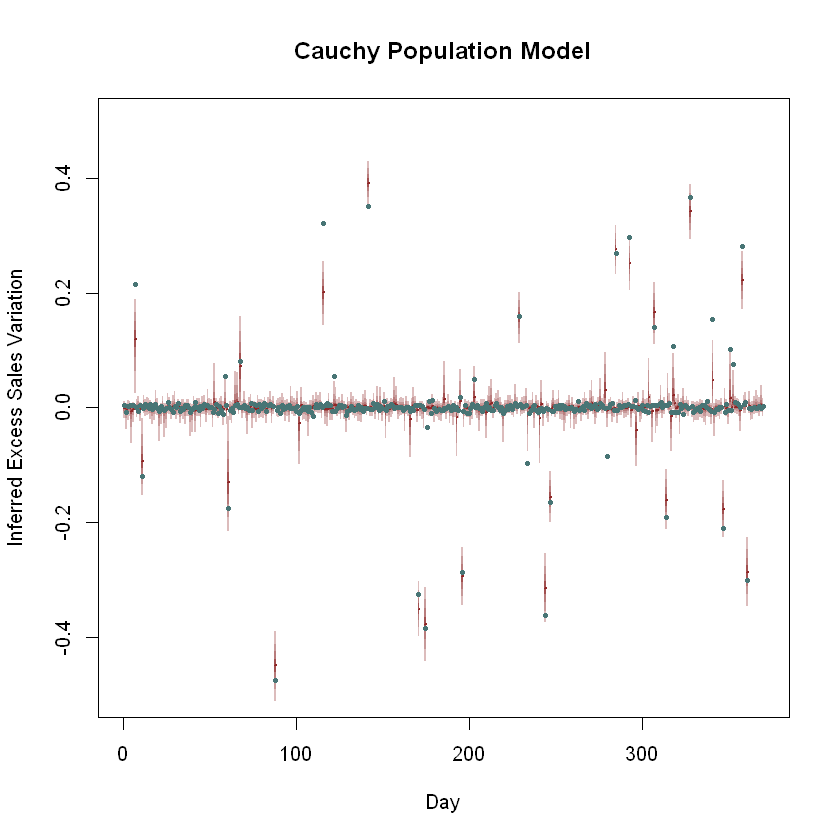

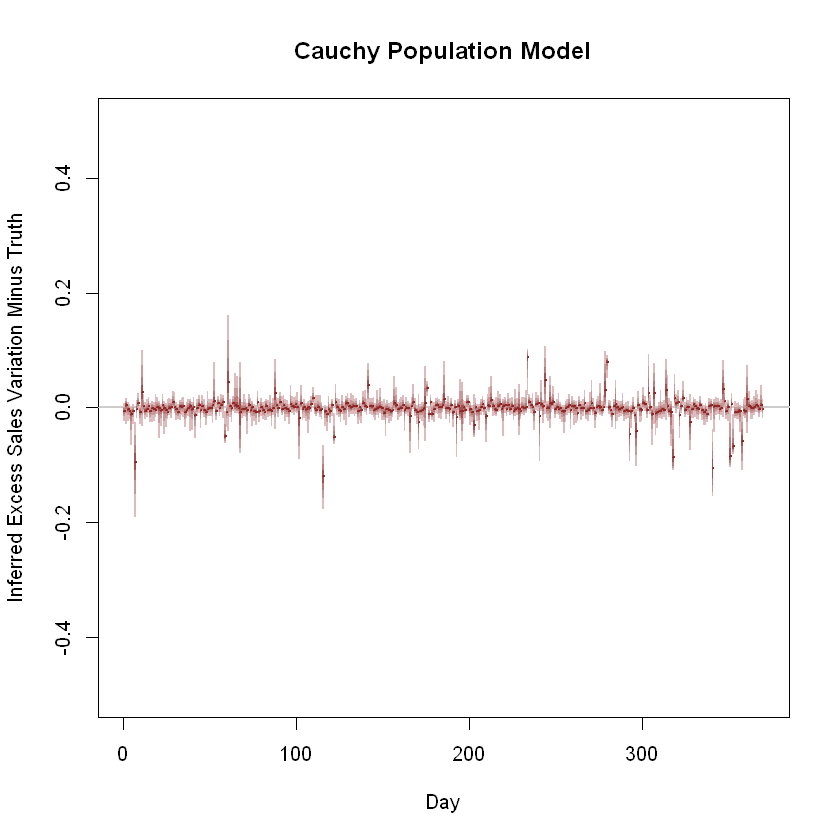

In [147]:
par(mfrow=c(1, 1))

util$plot_excess_variation(samples, data, truth, "Cauchy Population Model")

util$plot_excess_variation_residual(samples, data, truth, "Cauchy Population Model")

This leads to a much better recovery of the true values.



In [148]:
infer_crps_comp["Cauchy"] = util$sum_empirical_crps(samples$delta_days, truth$delta_days)
print(infer_crps_comp)

                  Normal  Laplace   Cauchy
Inferential ECRPS 6.7729 4.548471 2.354729


By separating out the small and large values the inferences for the expected
daily sales are now more precise.


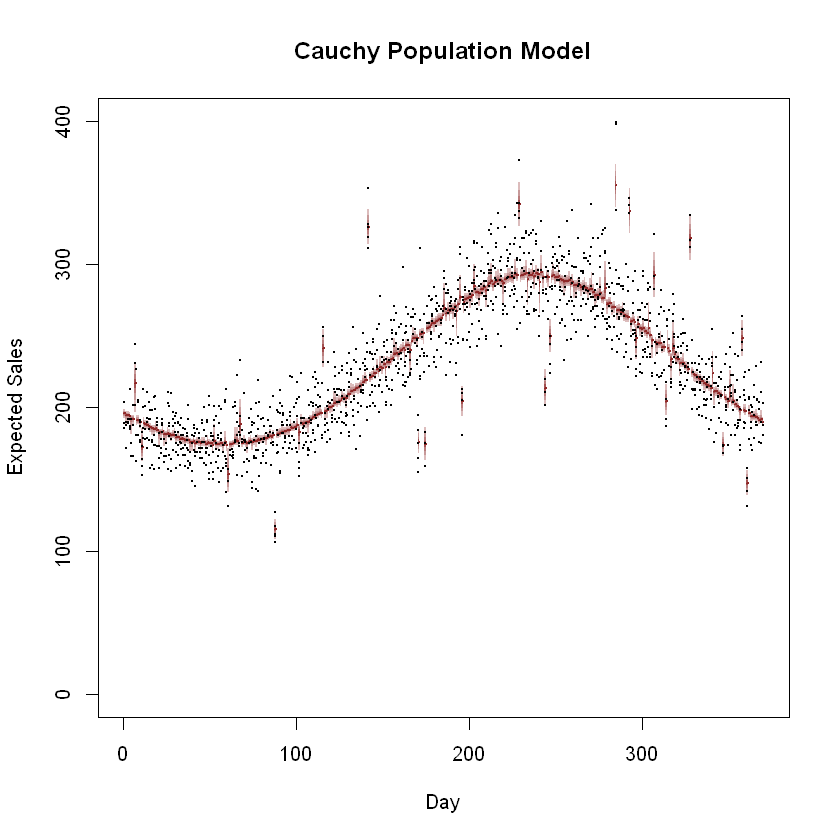

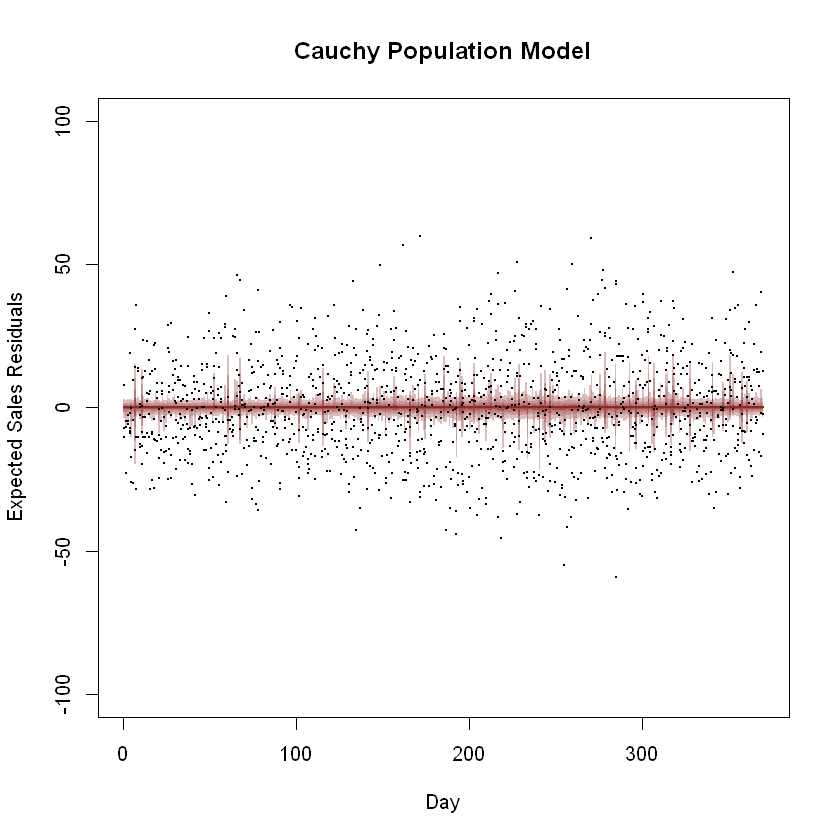

In [149]:
util$plot_expected_sales(samples, data, "Cauchy Population Model")

util$plot_expected_sales_residual(samples, data, "Cauchy Population Model")

The visual posterior retrodictive check looks much better than before with all
of those deviant days fully captured by the corresponding parameters.
On the other hand the posterior predictive distribution doesn't seem to have
changed much.  Again this is largely an artifact of having to build
visualizations from only finite Markov chains -- the tails of the posterior
predictive forecast past the 10% lower and 90% upper ribbons spread out to much
more extreme values.


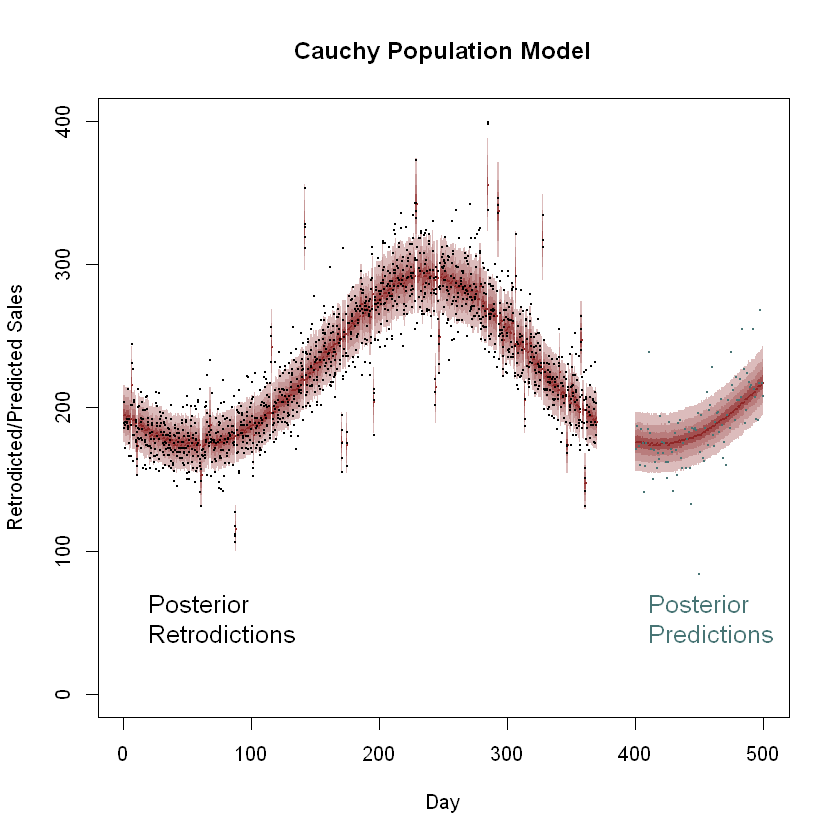

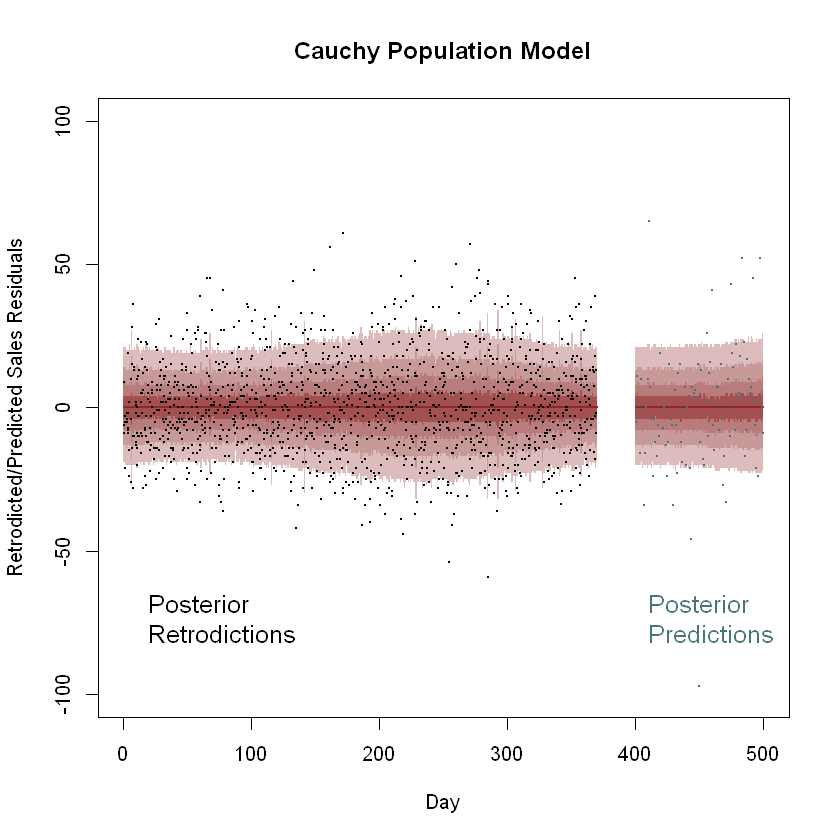

In [150]:
util$plot_dictions(samples, data, "Cauchy Population Model")

util$plot_dictions_residual(samples, data, "Cauchy Population Model")

Interestingly the heavier tails of the forecasting distribution results in
_much_ worse forecasting performance, at least as quantified by the empirical
continuous rank probability score.


In [151]:
pred_crps_comp["Cauchy"] = util$sum_empirical_crps(samples$y_post_pre, data$y_pred)
print(pred_crps_comp)

                   Normal  Laplace   Cauchy
Predictive ECRPS 1109.773 1098.318 5351.806


The problem is that without any data to inform whether any future day will see
a large deviation or not the Cauchy population model has to accommodate both.
This increases coverage and reduces risk but at the cost of the precision of
the predictions.

## Horseshoe Population Model

Let's continue this tread towards increasingly heavier-tailed population models
by considering the horseshoe population model.


In [152]:
writeLines(readLines("stan_programs/fit_sales_horseshoe.stan"))

data {
  int<lower=0> N_obs; // Number of sales observations
  int y_obs[N_obs];  // Daily units sold
  
  int<lower=0> N_obs_days;                           // Number of days observed
  int<lower=1, upper=N_obs_days> obs_day_idx[N_obs]; // Day of each observation
  
  int<lower=0> N_pred_days;                        // Number of future days to predict
  int<lower=N_obs_days> pred_day_idx[N_pred_days]; // Day of each prediction

  vector<lower=0, upper=1>[N_obs_days] w; // Partial centering parameters
}

parameters {
  vector[N_obs_days] delta_days_tilde; // Daily excess
  vector<lower=0>[N_obs_days] lambda;  // Horseshoe inflation parameters
  real<lower=0> tau_day;        // Weekly log variation scale
  
  real alpha;                   // Baseline sales per day
  real<lower=0> delta_season;   // Amplitude of log seasonal variation
  real delta_phi;               // Phase of seasonal variation from 10.5 days
  real<lower=0> milli_inv_psi;  // Observational dispersion times 1000
}

tra

Knowing how carefully we have to parameterize the individual parameters we jump
straight to a partially-centered parameterization.  In particular we'll keep
the parameters that we've been centering fully centered and drop the rest
halfway between fully centered and fully non-centered.


In [153]:
data$w <- rep(0.5, data$N_obs_days)
data$w[data$cp_idx] <- 1

In [154]:
start.time <- Sys.time()

horseshoe_fit <- stan(file='stan_programs/fit_sales_horseshoe.stan',
                      data=data, seed=4938483, refresh=1000)

end.time <- Sys.time()
computing.time <- end.time - start.time
computing.time

Warning message in validityMethod(object):
"The following variables have undefined values:  log_mu[1],The following variables have undefined values:  log_mu[2],The following variables have undefined values:  log_mu[3],The following variables have undefined values:  log_mu[4],The following variables have undefined values:  log_mu[5],The following variables have undefined values:  log_mu[6],The following variables have undefined values:  log_mu[7],The following variables have undefined values:  log_mu[8],The following variables have undefined values:  log_mu[9],The following variables have undefined values:  log_mu[10],The following variables have undefined values:  log_mu[11],The following variables have undefined values:  log_mu[12],The following variables have undefined values:  log_mu[13],The following variables have undefined values:  log_mu[14],The following variables have undefined values:  log_mu[15],The following variables have undefined values:  log_mu[16],The following variabl

Time difference of 14.53028 mins

The diagnostics...do not look good.



In [155]:
util$check_all_diagnostics(horseshoe_fit)

[1] "n_eff / iter for parameter delta_days_tilde[9] is 0.000733499865039651!"
[1] "n_eff / iter for parameter delta_days_tilde[16] is 0.000841305497080643!"
[1] "n_eff / iter for parameter delta_days_tilde[26] is 0.000876906222999938!"
[1] "n_eff / iter for parameter delta_days_tilde[45] is 0.000924336211948336!"
[1] "n_eff / iter for parameter delta_days_tilde[51] is 0.000959115465922136!"
[1] "n_eff / iter for parameter delta_days_tilde[53] is 0.000949730187394959!"
[1] "n_eff / iter for parameter delta_days_tilde[75] is 0.000945328827775022!"
[1] "n_eff / iter for parameter delta_days_tilde[97] is 0.000672817770927065!"
[1] "n_eff / iter for parameter delta_days_tilde[128] is 0.000648335836769551!"
[1] "n_eff / iter for parameter delta_days_tilde[131] is 0.000805185178293472!"
[1] "n_eff / iter for parameter delta_days_tilde[132] is 0.000871025875070791!"
[1] "n_eff / iter for parameter delta_days_tilde[135] is 0.000691124650144337!"
[1] "n_eff / iter for parameter delta_days_tilde[

Let's try to decipher what's going wrong by investigating some of the horseshoe
parameters.


In [156]:
partition <- util$partition_div(horseshoe_fit)
div_params <- partition[[1]]
nondiv_params <- partition[[2]]

Those parameters that were only partially-centered exhibit a funnel geometry
that suggests a more non-centered parameterization might facilitate the
computation.


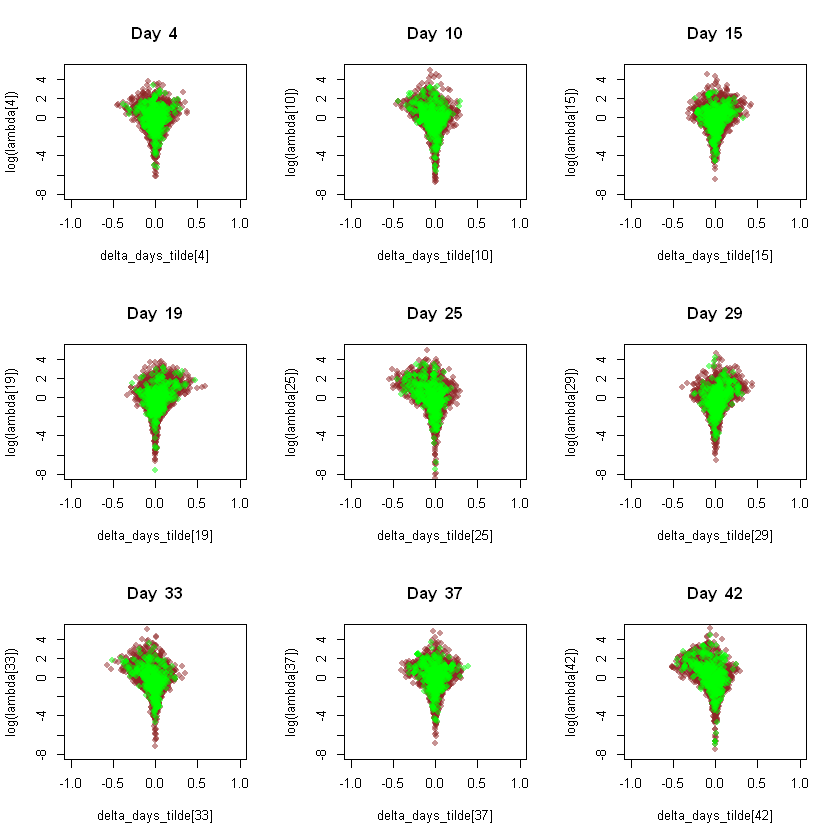

In [157]:
par(mfrow=c(3, 3))

for (k in which(data$w == 0.5)[4*(1:9)]) {
  name_x <- paste("delta_days_tilde[", k, "]", sep='')
  name_y <- paste("lambda[", k, "]", sep='')

  plot(nondiv_params[name_x][,1], log(nondiv_params[name_y][,1]),
       col=c_dark_trans, pch=16, main=paste("Day ", k),
       xlab=name_x, xlim=c(-1, 1),
       ylab=paste("log(", name_y, ")", sep=""), ylim=c(-8, 5))
  points(div_params[name_x][,1], log(div_params[name_y][,1]),
         col=c_green_trans, pch=16)
}

Here we'll just heuristically reduce the centering configuration to $0.2$.  In
general trying to find a good partial parameterization for the individual
parameters reduces to trial and error.


In [158]:
data$w[data$w == 0.5] <- 0.15

The parameters that were fully-centered exhibit more heterogeneous behaviors.
Most of the individual parameters exhibit a strong funnel geometry indicating
that they need to be more non-centered; the individual likelihood functions
corresponding to these parameters concentrate between the inner core and the
outer extent.  Some parameters, however, are informed by individual likelihood
functions that concentrate at much larger values decidedly in the outer extent.
Consequently the fully-centered parameterization shows no signs of problematic
geometry for these parameters.


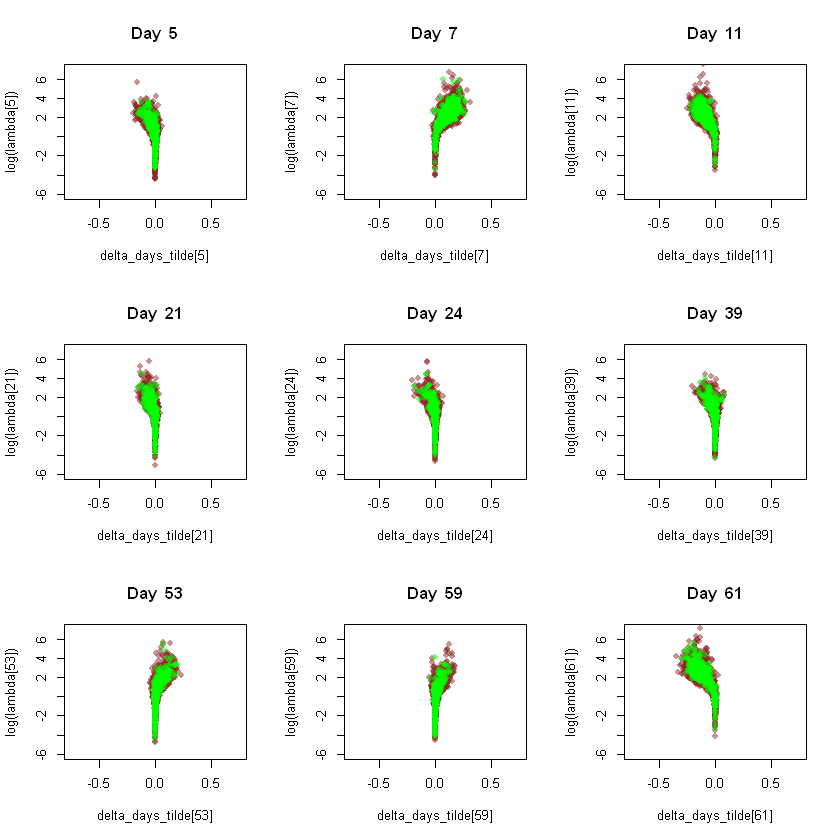

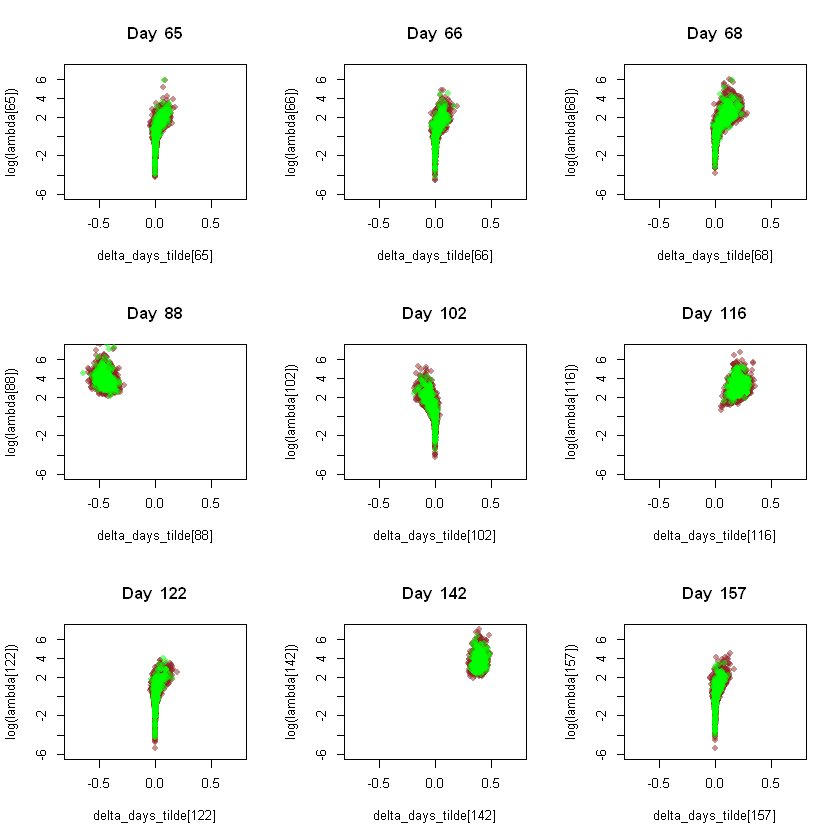

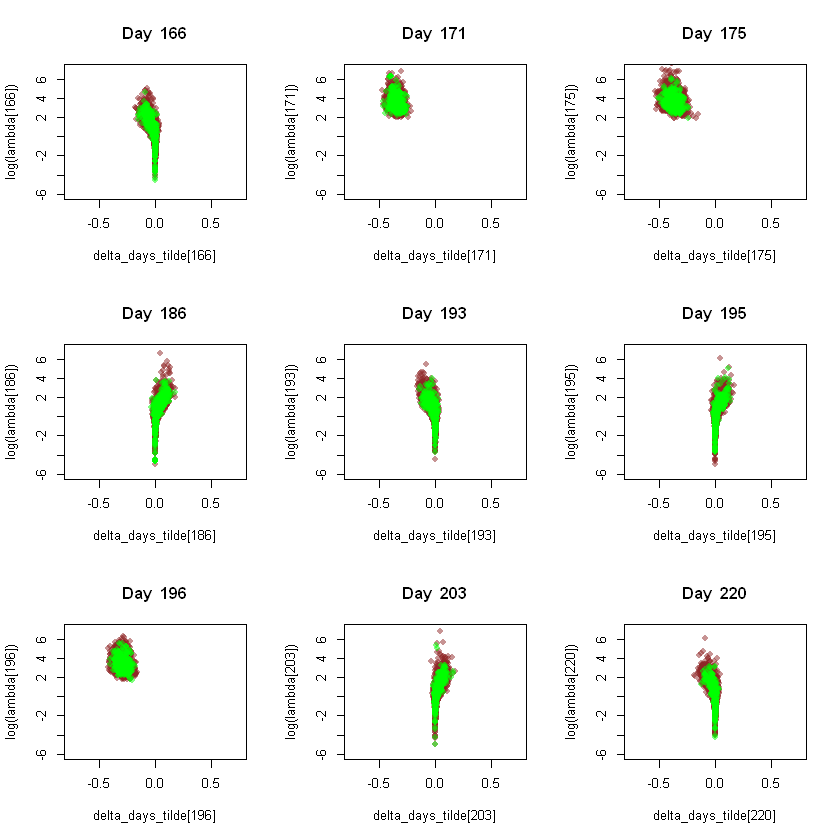

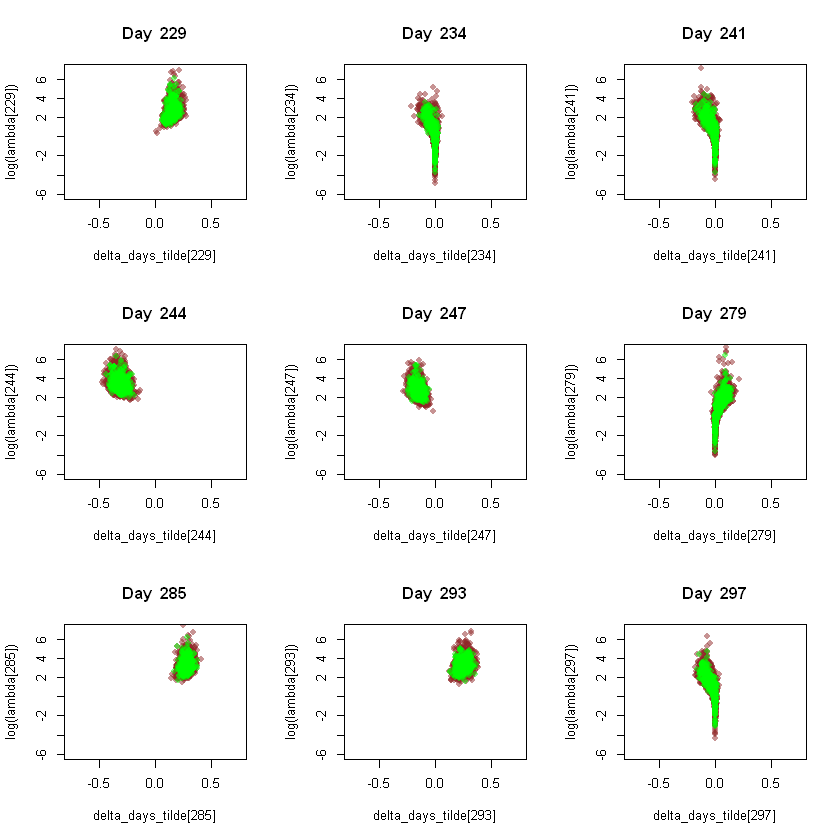

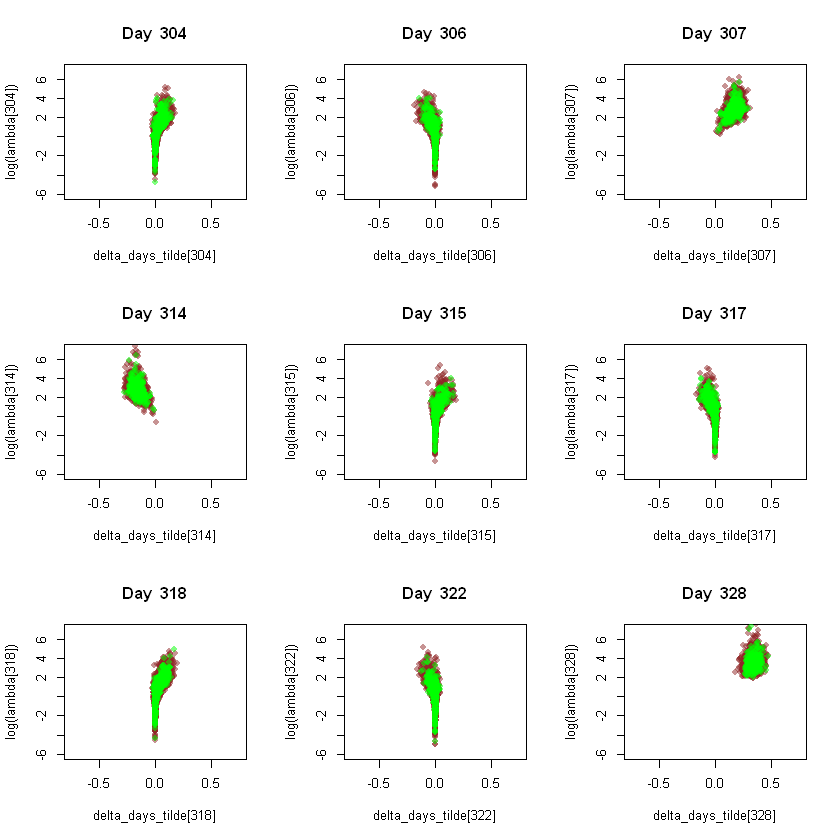

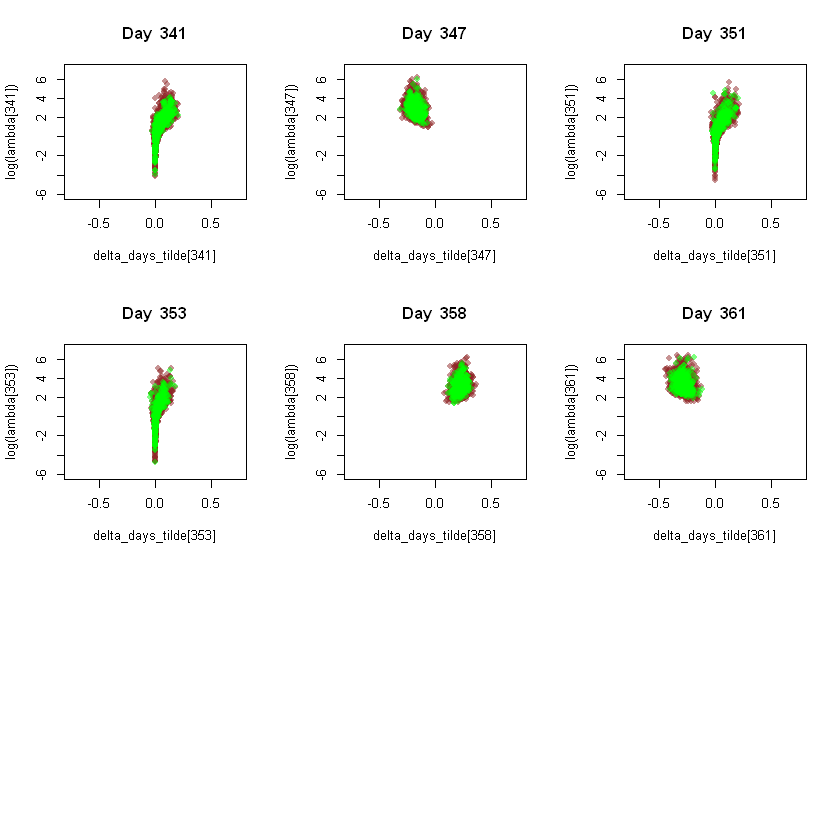

In [159]:
par(mfrow=c(3, 3))

for (k in which(data$w == 1)) {
  name_x <- paste("delta_days_tilde[", k, "]", sep='')
  name_y <- paste("lambda[", k, "]", sep='')

  plot(nondiv_params[name_x][,1], log(nondiv_params[name_y][,1]),
       col=c_dark_trans, pch=16, main=paste("Day ", k),
       xlab=name_x, xlim=c(-0.75, 0.75),
       ylab=paste("log(", name_y, ")", sep=""), ylim=c(-6, 7))
  points(div_params[name_x][,1], log(div_params[name_y][,1]),
         col=c_green_trans, pch=16)
}

We'll keep the latter parameters fully-centered while pretty strongly
non-centering the rest.  Again exactly how much to partially-center these
parameters is a delicate tuning problem that can't really be avoided.


In [160]:
data$w[data$cp_idx] <- 0.2
data$w[c(88, 116, 142, 171, 175, 196, 229, 244, 247, 285, 293, 328, 358, 361)] <- 1

How does this parameterization perform?



In [161]:
start.time <- Sys.time()

horseshoe_fit <- stan(file='stan_programs/fit_sales_horseshoe.stan',
                      data=data, seed=4938483, refresh=1000)

end.time <- Sys.time()
computing.time <- end.time - start.time
computing.time

Warning message:
"There were 513 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them."
Warning message:
"Examine the pairs() plot to diagnose sampling problems
"
Warning message:
"The largest R-hat is 1.12, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat"
Warning message:
"Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess"
Warning message:
"Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#tail-ess"


Time difference of 2.189215 mins

The diagnostics clearly indicate problems, although they don't seem to be quite
as catastrophic as before.


In [162]:
util$check_all_diagnostics(horseshoe_fit)

[1] "n_eff / iter looks reasonable for all parameters"
[1] "Rhat for parameter delta_days_tilde[141] is 1.11911105672137!"
[1] "Rhat for parameter delta_days_tilde[142] is 1.12090937419966!"
[1] "Rhat for parameter delta_days_tilde[177] is 1.10065684895141!"
[1] "Rhat for parameter delta_days_tilde[213] is 1.14436921254862!"
[1] "Rhat for parameter delta_days_tilde[222] is 1.13686884717955!"
[1] "Rhat for parameter delta_days_tilde[224] is 1.1088756361717!"
[1] "Rhat for parameter delta_days_tilde[227] is 1.11370254834213!"
[1] "Rhat for parameter delta_days_tilde[248] is 1.10111311317273!"
[1] "Rhat for parameter delta_days_tilde[256] is 1.11652992315913!"
[1] "Rhat for parameter delta_days_tilde[304] is 1.12979322299436!"
[1] "Rhat for parameter delta_days_tilde[316] is 1.10743319068403!"
[1] "Rhat for parameter delta_days_tilde[318] is 1.12134441958902!"
[1] "Rhat for parameter delta_days_tilde[341] is 1.12750488202441!"
[1] "Rhat for parameter delta_days_tilde[346] is 1.10541278889

Let's dive in to see if we can confirm the source of these problems.



In [163]:
partition <- util$partition_div(horseshoe_fit)
div_params <- partition[[1]]
nondiv_params <- partition[[2]]

The parameterization of the smaller parameters seems to be as good as it can
get, balancing the funnels on top and bottom into a somewhat symmetric diamond.


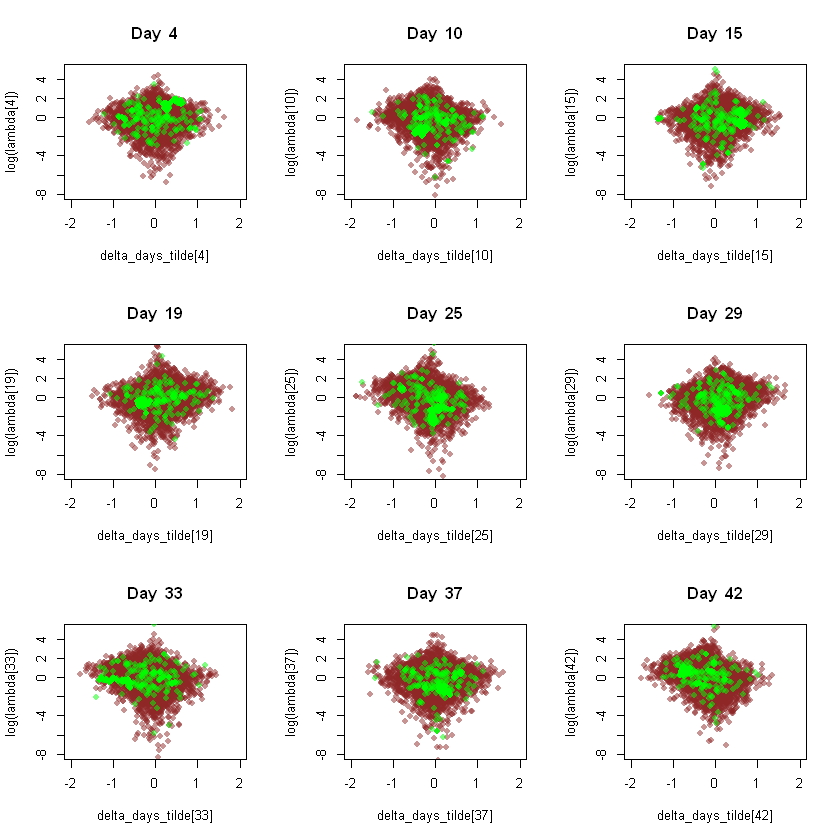

In [164]:
par(mfrow=c(3, 3))

for (k in which(data$w == 0.15)[4*(1:9)]) {
  name_x <- paste("delta_days_tilde[", k, "]", sep='')
  name_y <- paste("lambda[", k, "]", sep='')

  plot(nondiv_params[name_x][,1], log(nondiv_params[name_y][,1]),
       col=c_dark_trans, pch=16, main=paste("Day ", k),
       xlab=name_x, xlim=c(-2, 2),
       ylab=paste("log(", name_y, ")", sep=""), ylim=c(-8, 5))
  points(div_params[name_x][,1], log(div_params[name_y][,1]),
         col=c_green_trans, pch=16)
}

We see a similar situation with the rest of the partially-centered parameters
which are starting to show funnel geometries extending both towards smaller and
larger values of each $\lambda_{k}$.


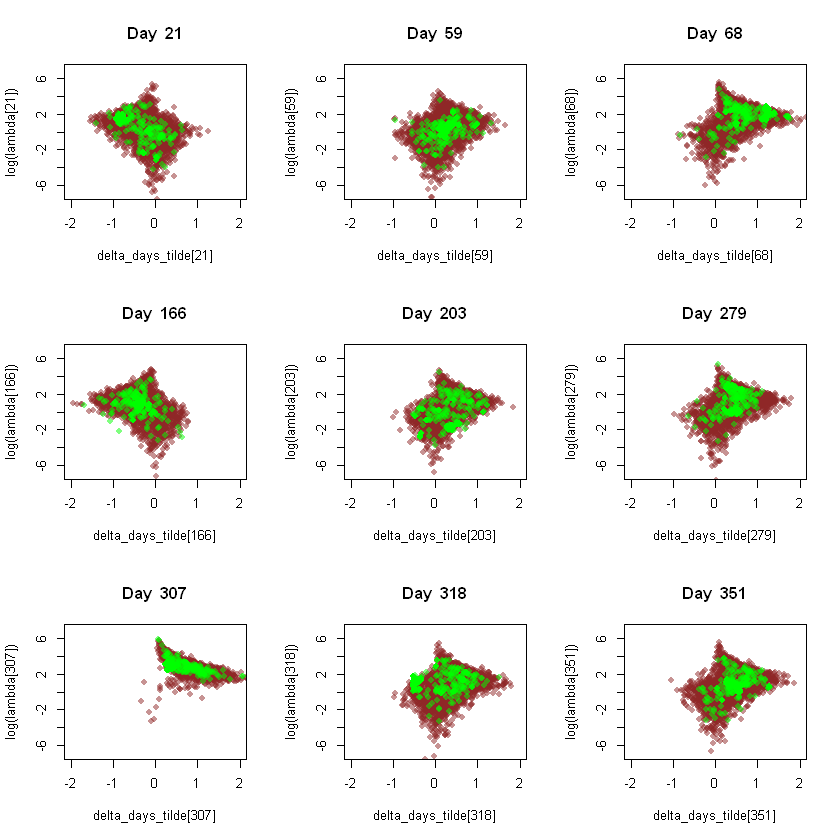

In [165]:
par(mfrow=c(3, 3))

for (k in which(data$w == 0.2)[4*(1:9)]) {
  name_x <- paste("delta_days_tilde[", k, "]", sep='')
  name_y <- paste("lambda[", k, "]", sep='')

  plot(nondiv_params[name_x][,1], log(nondiv_params[name_y][,1]),
       col=c_dark_trans, pch=16, main=paste("Day ", k),
       xlab=name_x, xlim=c(-2, 2),
       ylab=paste("log(", name_y, ")", sep=""), ylim=c(-7, 7))
  points(div_params[name_x][,1], log(div_params[name_y][,1]),
         col=c_green_trans, pch=16)
}

While we could keep trying to iteratively tune the parameterization of the
horseshoe parameters to improve the posterior geometry we've already spent too
much time here.  Let's just push Stan to its limits and try to burn computation
to compensate for the problematic geometry.


In [166]:
start.time <- Sys.time()

horseshoe_fit <- stan(file='stan_programs/fit_sales_horseshoe.stan',
                      data=data, seed=4938483, refresh=1000,
                      control=list(adapt_delta=0.999))

end.time <- Sys.time()
computing.time <- end.time - start.time
computing.time

Warning message:
"There were 20 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them."
Warning message:
"Examine the pairs() plot to diagnose sampling problems
"


Time difference of 5.678963 mins

Like a mighty stallion the horseshoe population model cannot be tamed.



In [167]:
util$check_all_diagnostics(horseshoe_fit)

[1] "n_eff / iter looks reasonable for all parameters"
[1] "Rhat looks reasonable for all parameters"
[1] "20 of 4000 iterations ended with a divergence (0.5%)"
[1] "  Try running with larger adapt_delta to remove the divergences"
[1] "0 of 4000 iterations saturated the maximum tree depth of 10 (0%)"
[1] "E-FMI indicated no pathological behavior"


Exhausted, let's see how this mildly biased posterior behaves.  The true values
of the seasonal parameters are recovered well, while the population scale
settles on values similar to those recovered by the Cauchy population model.


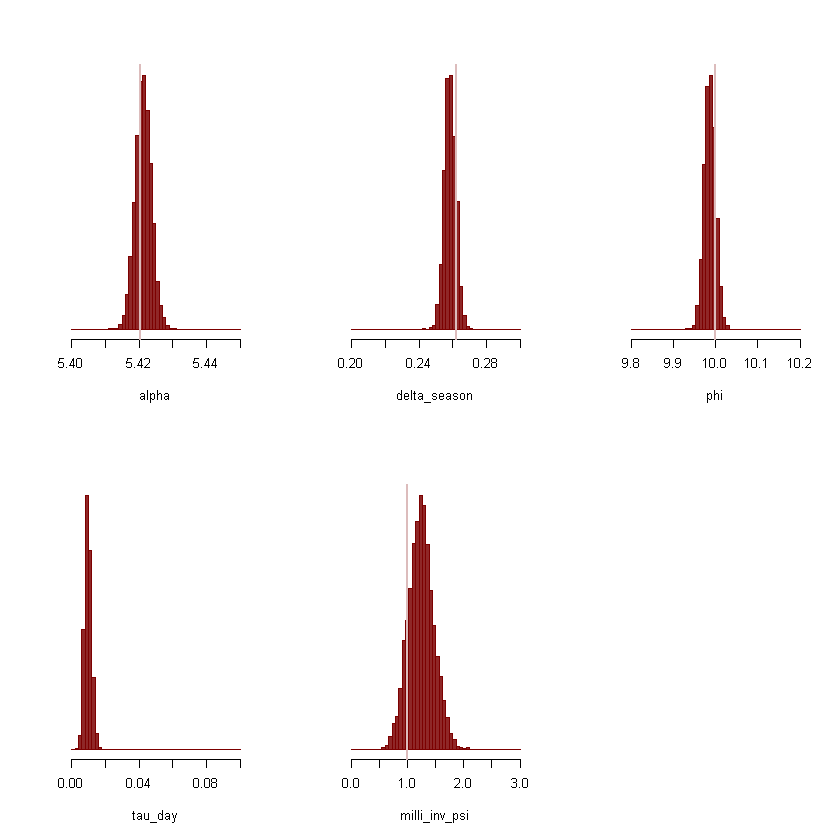

In [168]:
samples = extract(horseshoe_fit)

par(mfrow=c(2, 3))

hist(samples$alpha, breaks=seq(5.40, 5.45, 0.05 / 50),
     main="", xlab="alpha", yaxt='n', ylab="",
     col=c_dark, border=c_dark_highlight)
abline(v=truth$alpha, col=c_light, lty=1, lw=2)

hist(samples$delta_season, seq(0.2, 0.3, 0.1 / 50),
     main="", xlab="delta_season", yaxt='n', ylab="",
     col=c_dark, border=c_dark_highlight)
abline(v=truth$delta_season, col=c_light, lty=1, lw=2)

hist(samples$phi, seq(9.8, 10.2, 0.4 / 50),
     main="", xlab="phi", yaxt='n', ylab="",
     col=c_dark, border=c_dark_highlight)
abline(v=truth$phi, col=c_light, lty=1, lw=2)

hist(samples$tau_day, seq(0, 0.1, 0.1 / 50),
     main="", xlab="tau_day", yaxt='n', ylab="",
     col=c_dark, border=c_dark_highlight)

hist(samples$milli_inv_psi, seq(0, 3, 3 / 50),
     main="", xlab="milli_inv_psi", yaxt='n', ylab="",
     col=c_dark, border=c_dark_highlight)
abline(v=1000 * truth$inv_psi, col=c_light, lty=1, lw=2)

Inferences of the daily sales variation parameters also seem to recover the true
values fairly well.


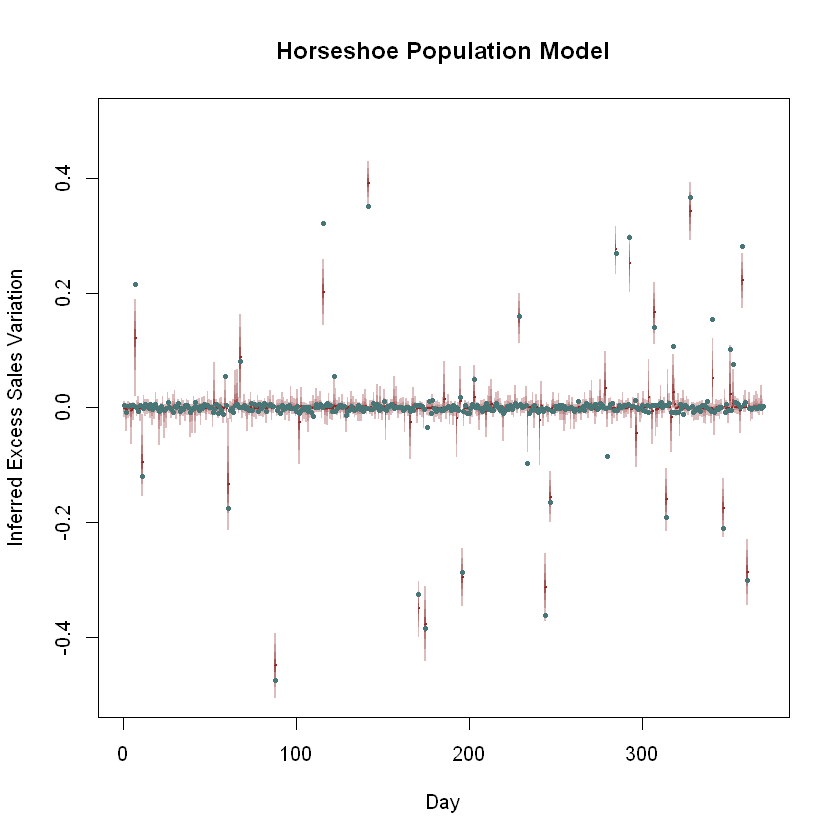

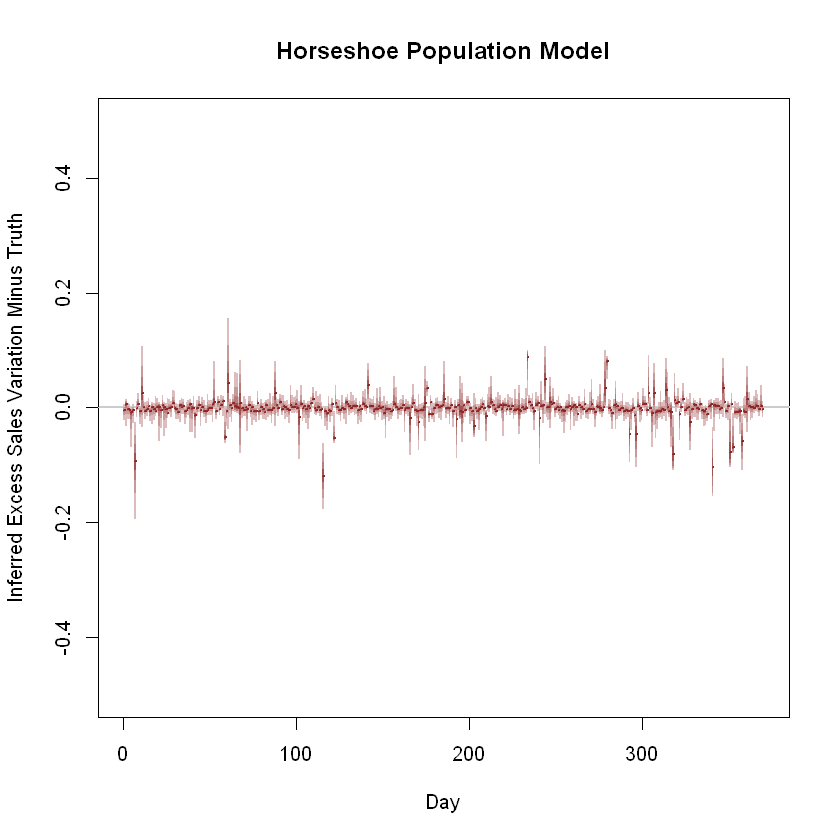

In [169]:
par(mfrow=c(1, 1))

util$plot_excess_variation(samples, data, truth, "Horseshoe Population Model")

util$plot_excess_variation_residual(samples, data, truth, "Horseshoe Population Model")

This is backed up by the empirical continuous rank probability score which is
every so slightly better for this horseshoe fit.


In [170]:
infer_crps_comp["Horseshoe"] = util$sum_empirical_crps(samples$delta_days, truth$delta_days)
print(infer_crps_comp)

                  Normal  Laplace   Cauchy Horseshoe
Inferential ECRPS 6.7729 4.548471 2.354729  2.282164


The inferences for the expected sales also looks similar to those from the
Cauchy population model.


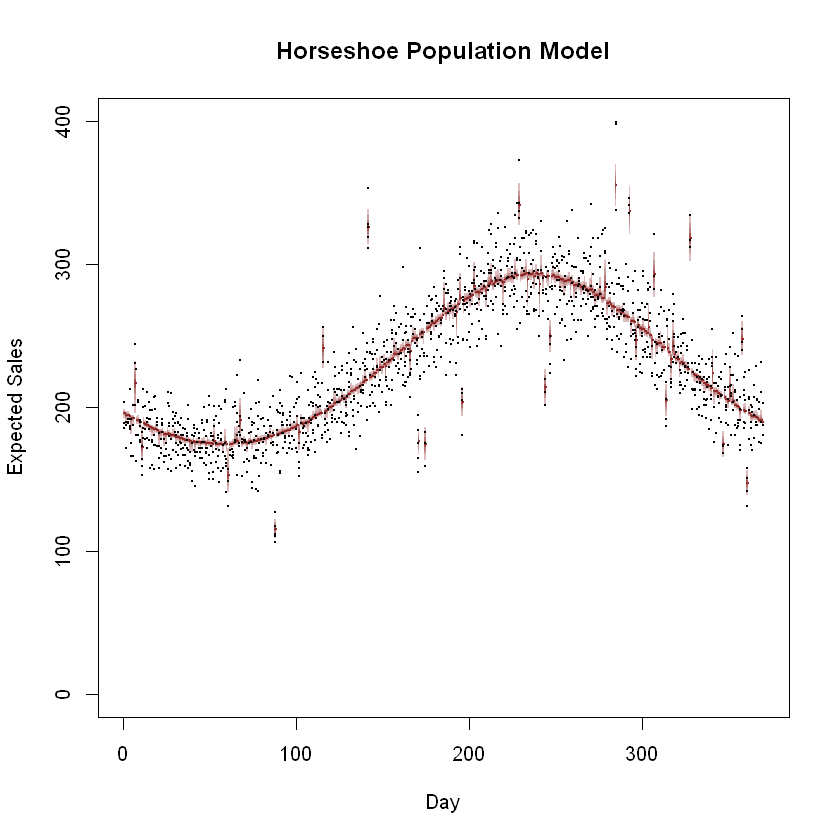

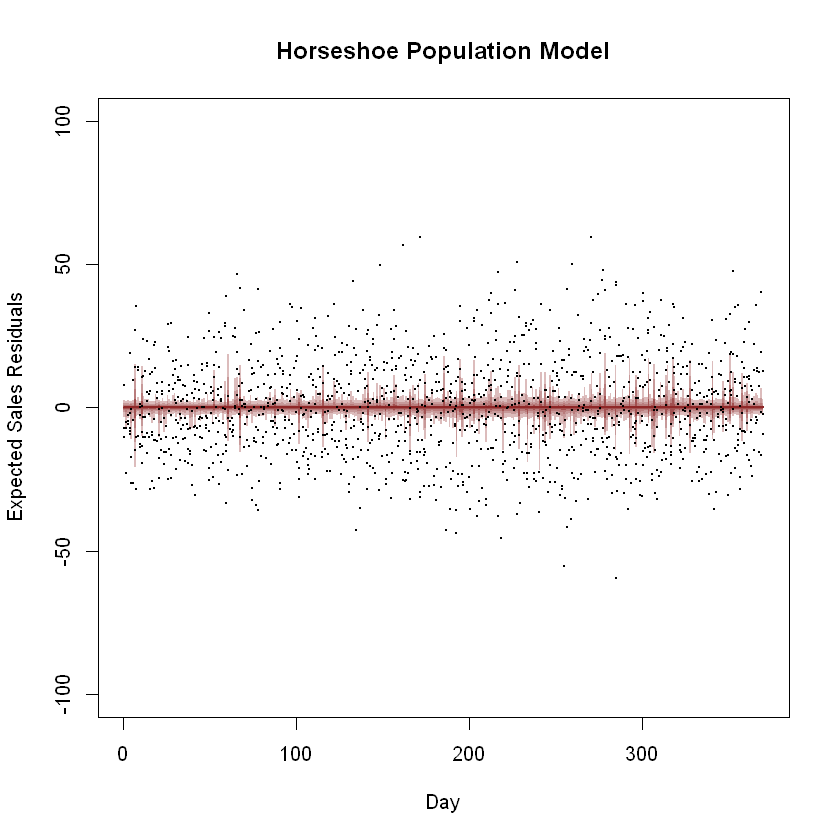

In [171]:
util$plot_expected_sales(samples, data, "Horseshoe Population Model")

util$plot_expected_sales_residual(samples, data, "Horseshoe Population Model")

As do the posterior retrodictive and posterior predictive comparisons.  Again
keep in mind that the posterior predictive distribution on the right features
_very_ heavy tails that are not particularly evident in this visualization.


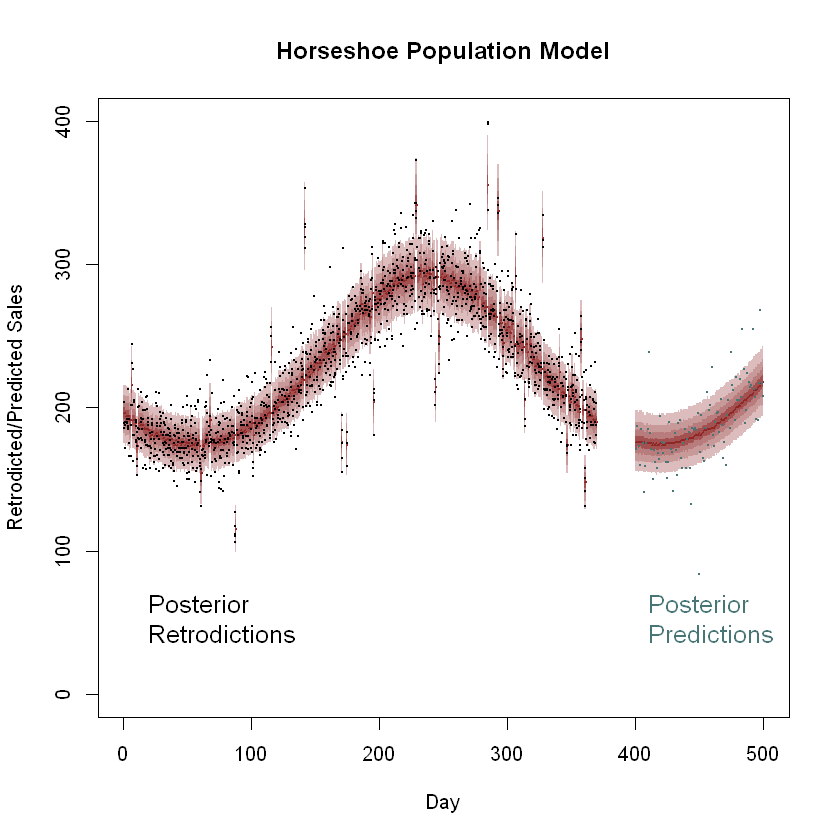

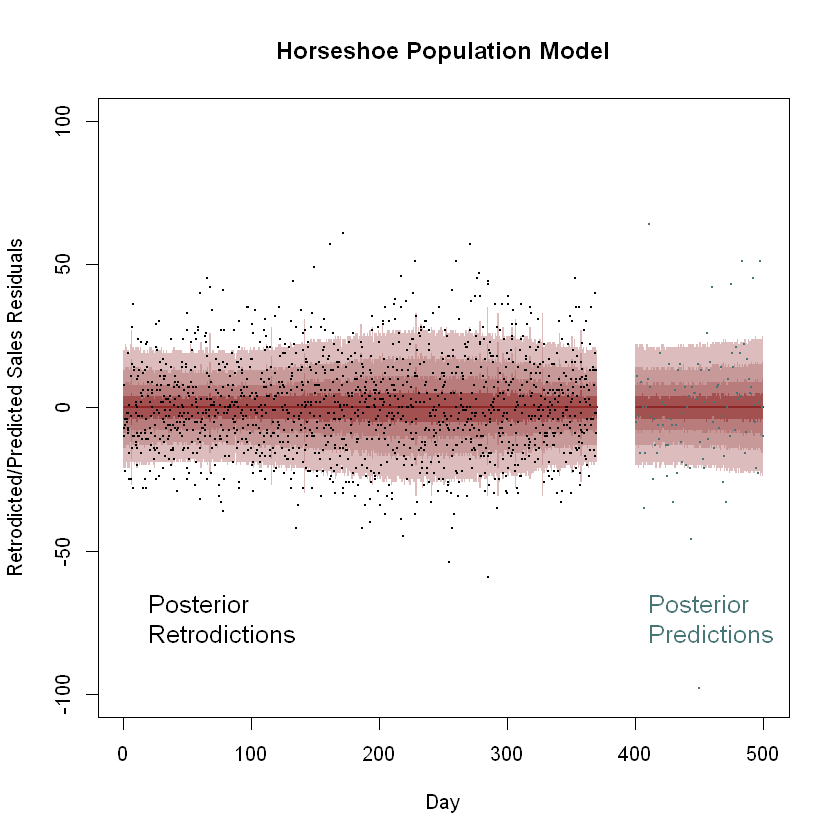

In [172]:
util$plot_dictions(samples, data, "Horseshoe Population Model")

util$plot_dictions_residual(samples, data, "Horseshoe Population Model")

Those tails, however, do affect the empirical continuous rank probability score
which is even worse for the horseshoe population model than the Cauchy
population model!  Based on our discussion in the previous section this makes
sense -- the heavier the tail of the population model the more the diffuse our
predictions will be for every future day and the more they will be penalized by
the empirical continuous rank probability score when there isn't a strong daily
variation in the sales.


In [173]:
pred_crps_comp["Horseshoe"] = util$sum_empirical_crps(samples$y_post_pre, data$y_pred)
print(pred_crps_comp)

                   Normal  Laplace   Cauchy Horseshoe
Predictive ECRPS 1109.773 1098.318 5351.806  5916.502


Note also that the truncation of the posterior predictive samples in the
`generated quantities` block needed to avoid overflowing the negative binomial
pseudo random number generator is artificially regularizing these heavy tailed
posterior predictive distributions and the predictive performance is actually
worse than estimated here!

## Normal Mixture Population Model

Finally let's consider a mixture of two normal population models, one to model
the inner core of irrelevant deviations and one to model the outer extent of
relevant deviations.

Our prior model on the inner population scale matches the prior model of the
single population scale that we've been using for all of the previous
population models, while the prior model for the outer scale matches that of
the overall seasonal variation.  In other words we don't expect large daily
variations to be bigger than the yearly variation.  The prior model for the
mixture probability $\gamma$ is also relatively strongly informative to enforce
our assumption of sparsity in how often daily sales see substantial variations.


In [174]:
writeLines(readLines("stan_programs/fit_sales_normal_mixture.stan"))

data {
  int<lower=0> N_obs; // Number of sales observations
  int y_obs[N_obs];  // Daily units sold
  
  int<lower=0> N_obs_days;                           // Number of days observed
  int<lower=1, upper=N_obs_days> obs_day_idx[N_obs]; // Day of each observation
  
  int<lower=0> N_pred_days;                        // Number of future days to predict
  int<lower=N_obs_days> pred_day_idx[N_pred_days]; // Day of each prediction

  vector<lower=0, upper=1>[N_obs_days] w; // Partial centering parameters
}

parameters {
  //vector[K_cp] delta_days_cp;   // Daily excess
  //vector[K_ncp] delta_days_ncp; // Daily excess
  vector[N_obs_days] delta_days_tilde; // Latent parameter for daily excess
  
  real<lower=0> inner_tau_day;              // Inner weekly log variation scale
  real<lower=inner_tau_day> outer_tau_day;  // Outer weekly log variation scale
  real<lower=0, upper=1> gamma; // Inner core probability
  
  real alpha;                   // Baseline sales per day
  real<lower=0> del

Let's use the centering pattern that we used for the Laplace and Cauchy
population models above to motivate an initial partial centering.


In [175]:
data$w <- rep(0.2, data$N_obs_days)
data$w[data$cp_idx] <- 1

In [176]:
start.time <- Sys.time()

normal_mixture_fit <- stan(file='stan_programs/fit_sales_normal_mixture.stan',
                           data=data, seed=4938483, refresh=1000)

end.time <- Sys.time()
computing.time <- end.time - start.time
computing.time

Warning message:
"There were 1 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low"
Warning message:
"Examine the pairs() plot to diagnose sampling problems
"
Warning message:
"The largest R-hat is 1.08, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat"
Warning message:
"Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess"
Warning message:
"Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#tail-ess"


Time difference of 3.786938 mins

The $\hat{R}$ warnings suggest some inconsistent exploration across the four
Markov chains.


In [177]:
util$check_all_diagnostics(normal_mixture_fit)

[1] "n_eff / iter looks reasonable for all parameters"
[1] "Rhat for parameter delta_days_tilde[45] is 1.17526694902974!"
[1] "Rhat for parameter delta_days_tilde[132] is 1.14482251390343!"
[1] "Rhat for parameter delta_days_tilde[243] is 1.2428552828577!"
[1] "Rhat for parameter delta_days_tilde[258] is 1.21758268971929!"
[1] "Rhat for parameter delta_days_tilde[261] is 1.32297155035948!"
[1] "Rhat for parameter delta_days[45] is 1.10517152900886!"
[1] "Rhat for parameter delta_days[243] is 1.16335608616399!"
[1] "Rhat for parameter delta_days[258] is 1.11610317789159!"
[1] "Rhat for parameter delta_days[261] is 1.26464455574587!"
[1] "Rhat for parameter log_mu[243] is 1.15549854460662!"
[1] "Rhat for parameter log_mu[258] is 1.11499228119464!"
[1] "Rhat for parameter log_mu[261] is 1.25759357626527!"
[1] "  Rhat above 1.1 indicates that the chains very likely have not mixed"
[1] "0 of 4000 iterations ended with a divergence (0%)"
[1] "0 of 4000 iterations saturated the maximum tree d

Let's take a look at a few of the misbehaving parameters.



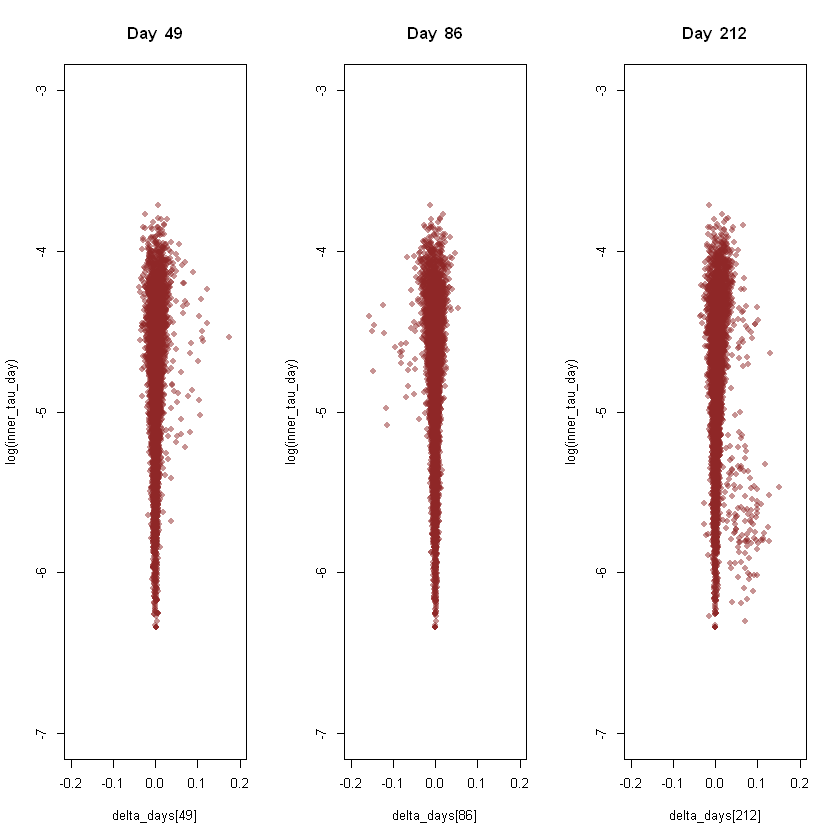

In [178]:
partition <- util$partition_div(normal_mixture_fit)
div_params <- partition[[1]]
nondiv_params <- partition[[2]]

par(mfrow=c(1, 3))

for (k in c(49, 86, 212)) {
  name_x <- paste("delta_days[", k, "]", sep='')
  name_y <- "inner_tau_day"
  
  plot(nondiv_params[name_x][,1], log(nondiv_params[name_y][,1]),
       col=c_dark_trans, pch=16, main=paste("Day ", k),
       xlab=name_x, xlim=c(-0.2, 0.2), 
       ylab=paste("log(", name_y, ")", sep=""), ylim=c(-7, -3))
  points(div_params[name_x][,1], log(div_params[name_y][,1]),
         col=c_green_trans, pch=16)
}

The recovered posterior distribution for each of these parameters covers both an
inner core and a side plateau, consistent with likelihood functions that extend
past the inner core a bit.  To confirm let's look at the corresponding trace plots.


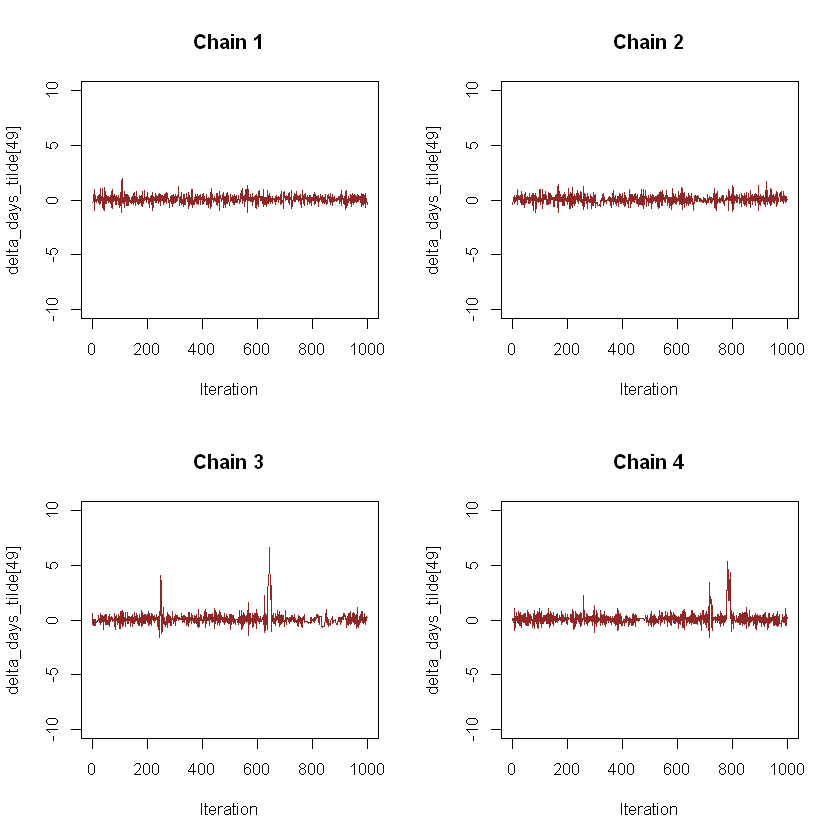

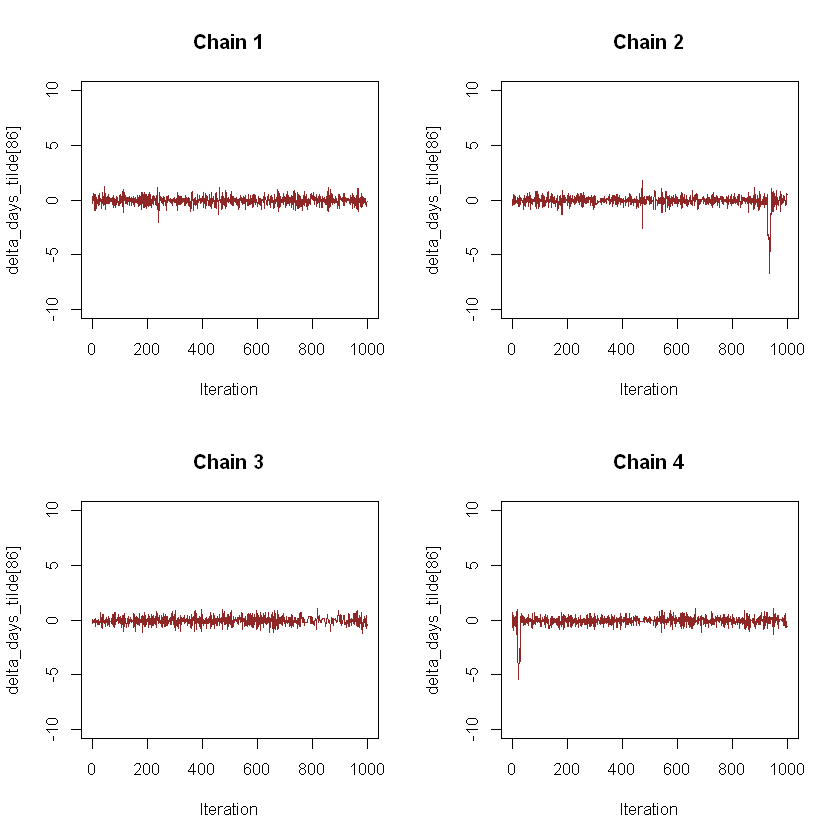

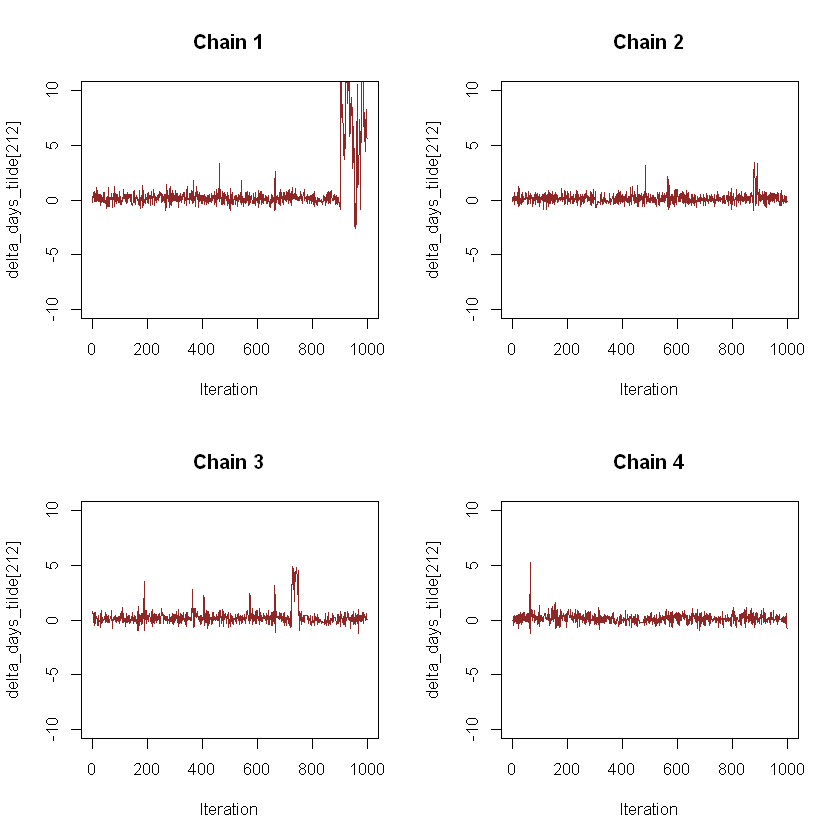

In [179]:
unpermuted_samples <- extract(normal_mixture_fit, permute=FALSE)

par(mfrow=c(2, 2))

for (k in c(49, 86, 212))
  for (c in 1:4)
    plot(1:1000, unpermuted_samples[, c, k], type="l", lwd=1, col=c_dark,
         main=paste("Chain ", c, sep=""),
         xlab="Iteration",  xlim=c(1, 1000),
         ylab=paste("delta_days_tilde[", k, "]", sep=""), ylim=c(-10, 10))

Stan is able to transition between the peak and this plateau in these marginal 
posterior distributions, but these transitions are somewhat slow.  We could run 
longer Markov chains to collect more transitions, and more precise inferences of
the relative probabilities assigned to the peak and the plateau, but let's see 
how useful these limited inferences.

Pleasantly the marginal posterior distributions recover the true values,
including the scales of both the inner core and outer extent.


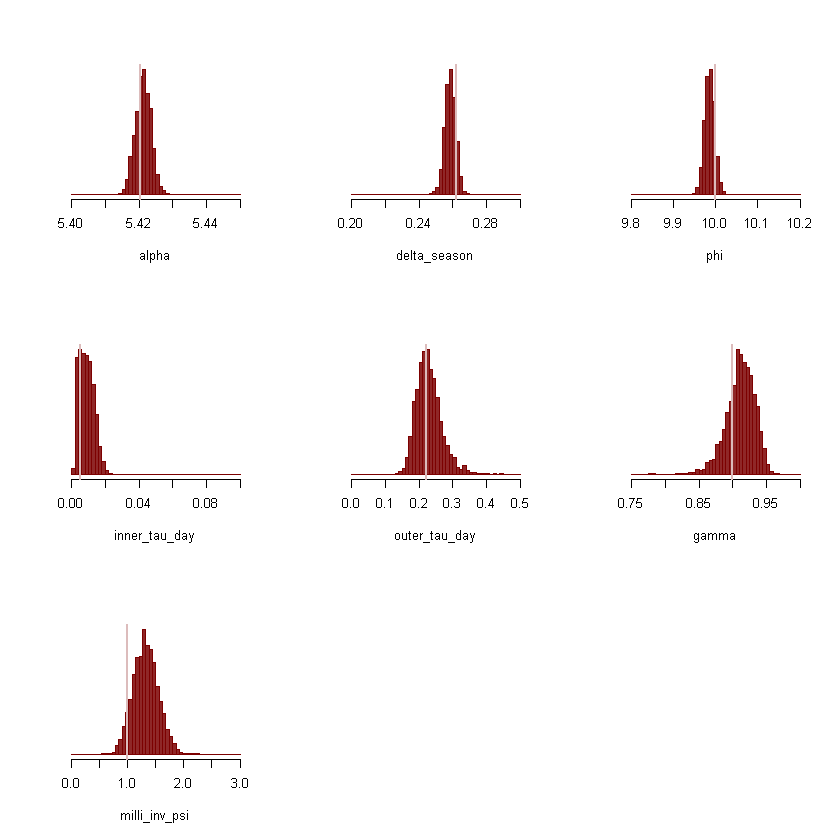

In [180]:
samples = extract(normal_mixture_fit)

par(mfrow=c(3, 3))

hist(samples$alpha, breaks=seq(5.40, 5.45, 0.05 / 50),
     main="", xlab="alpha", yaxt='n', ylab="",
     col=c_dark, border=c_dark_highlight)
abline(v=truth$alpha, col=c_light, lty=1, lw=2)

hist(samples$delta_season, seq(0.2, 0.3, 0.1 / 50),
     main="", xlab="delta_season", yaxt='n', ylab="",
     col=c_dark, border=c_dark_highlight)
abline(v=truth$delta_season, col=c_light, lty=1, lw=2)

hist(samples$phi, seq(9.8, 10.2, 0.4 / 50),
     main="", xlab="phi", yaxt='n', ylab="",
     col=c_dark, border=c_dark_highlight)
abline(v=truth$phi, col=c_light, lty=1, lw=2)

hist(samples$inner_tau_day, seq(0, 0.1, 0.1 / 50),
     main="", xlab="inner_tau_day", yaxt='n', ylab="",
     col=c_dark, border=c_dark_highlight)
abline(v=truth$inner_tau_day, col=c_light, lty=1, lw=2)

hist(samples$outer_tau_day, seq(0, 0.5, 0.5 / 50),
     main="", xlab="outer_tau_day", yaxt='n', ylab="",
     col=c_dark, border=c_dark_highlight)
abline(v=truth$outer_tau_day, col=c_light, lty=1, lw=2)

hist(samples$gamma, seq(0.75, 1.0, 0.25 / 50),
     main="", xlab="gamma", yaxt='n', ylab="",
     col=c_dark, border=c_dark_highlight)
abline(v=truth$gamma, col=c_light, lty=1, lw=2)

hist(samples$milli_inv_psi, seq(0, 3, 3 / 50),
     main="", xlab="milli_inv_psi", yaxt='n', ylab="",
     col=c_dark, border=c_dark_highlight)
abline(v=1000 * truth$inv_psi, col=c_light, lty=1, lw=2)

By explicitly modeling both an inner core and outer extent the smaller
parameters are more strongly regularized than in any of the previous models
while the larger parameters are left to explore the outer extent in peace.


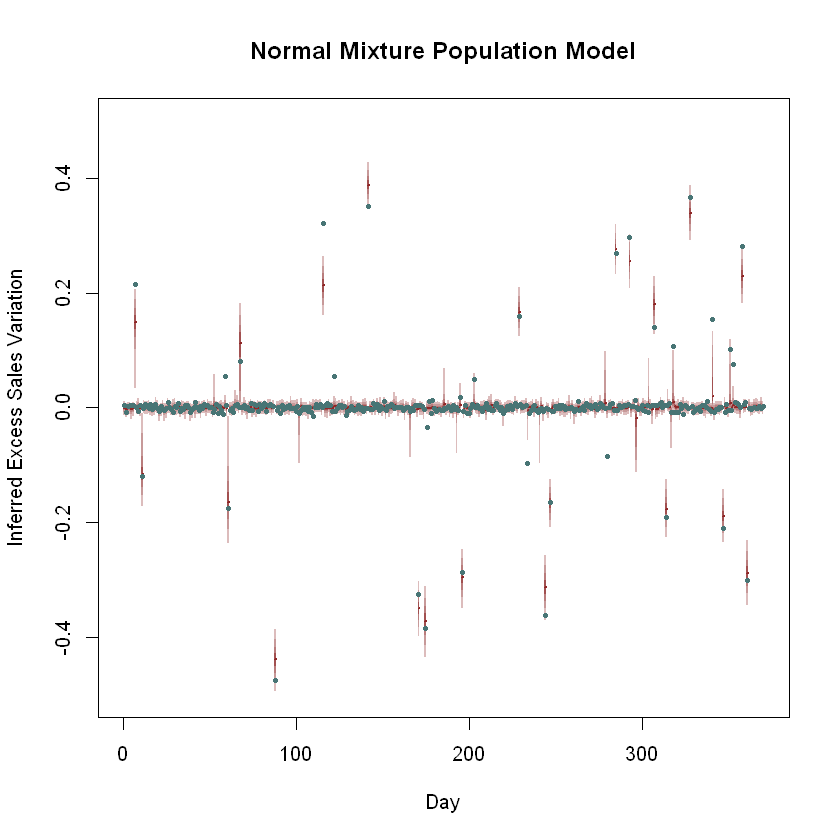

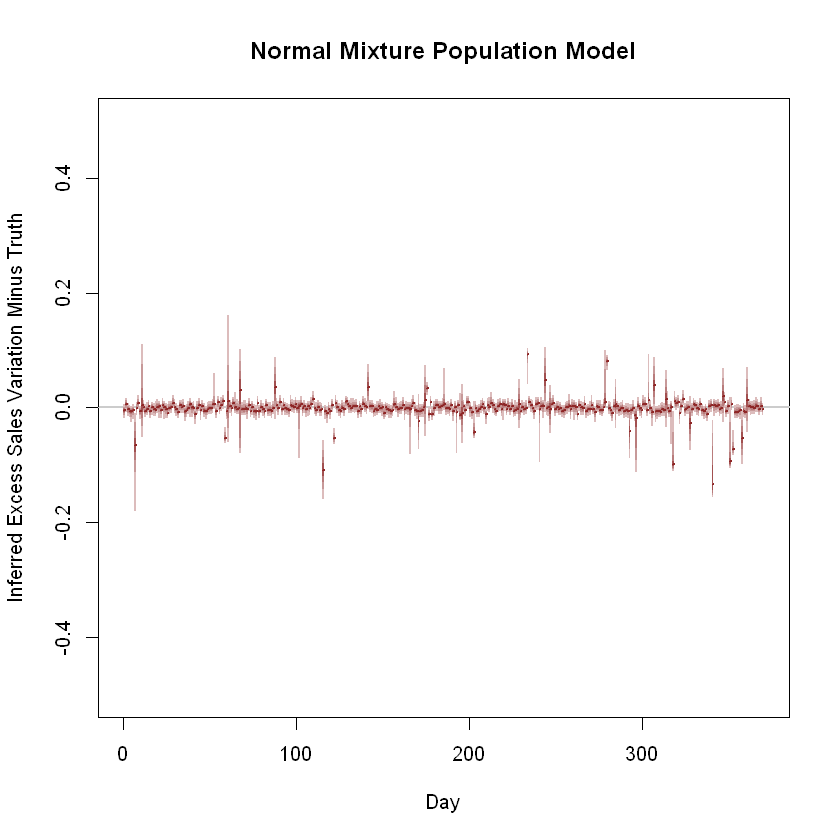

In [181]:
par(mfrow=c(1, 1))

util$plot_excess_variation(samples, data, truth, "Normal Mixture Population Model")

util$plot_excess_variation_residual(samples, data, truth, "Normal Mixture Population Model")

This results in the smallest empirical continuous rank probability score for
the inferential recovery yet.


In [182]:
infer_crps_comp["Normal Mixture"] = util$sum_empirical_crps(samples$delta_days, truth$delta_days)
print(infer_crps_comp)

                  Normal  Laplace   Cauchy Horseshoe Normal Mixture
Inferential ECRPS 6.7729 4.548471 2.354729  2.282164        2.09767


The expected sales time series looks similarly clean.



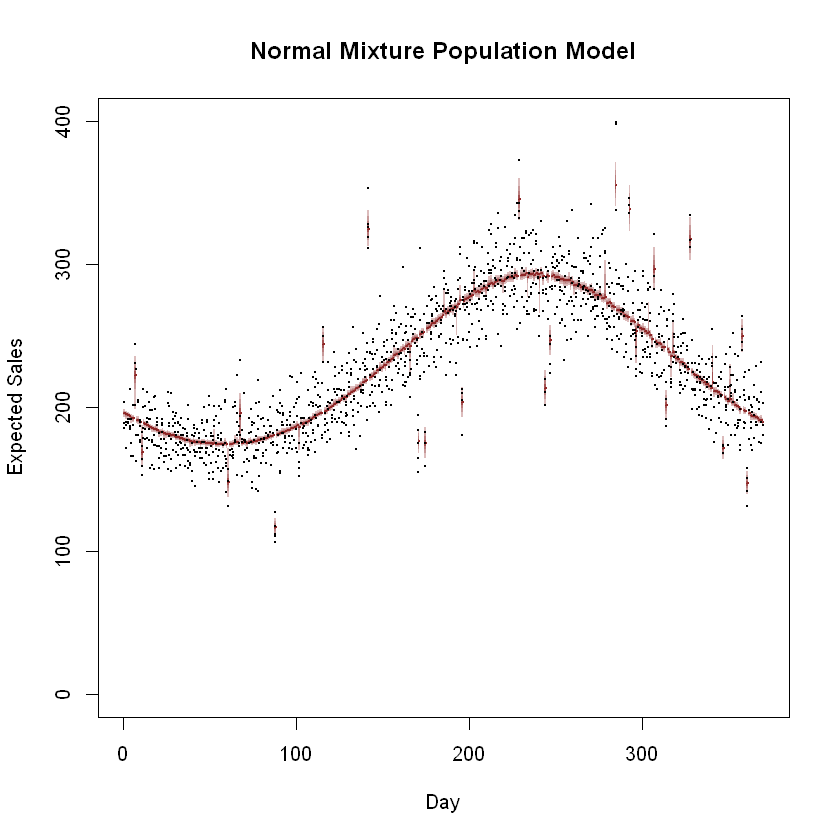

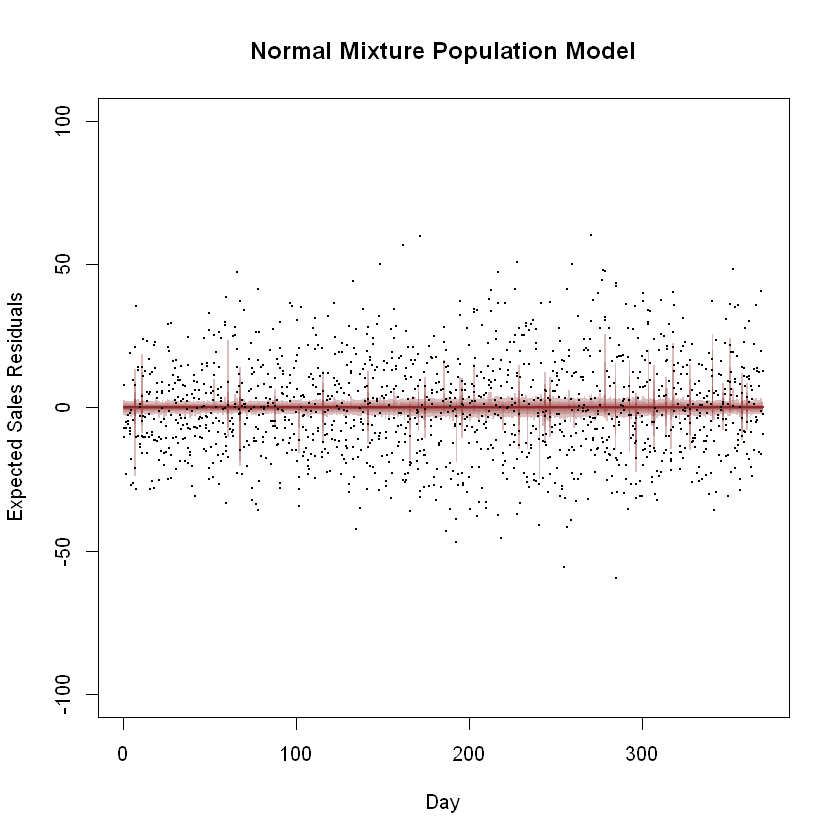

In [183]:
util$plot_expected_sales(samples, data, "Normal Mixture Population Model")

util$plot_expected_sales_residual(samples, data, "Normal Mixture Population Model")

Perhaps most exciting outcome is the forecasting performance of our posterior
predictions.


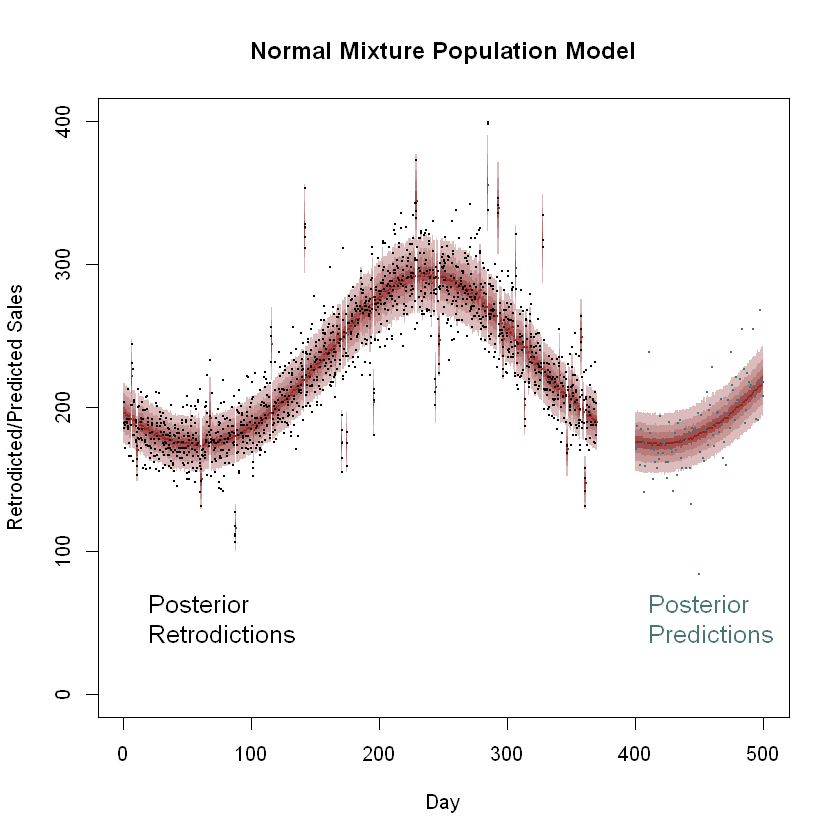

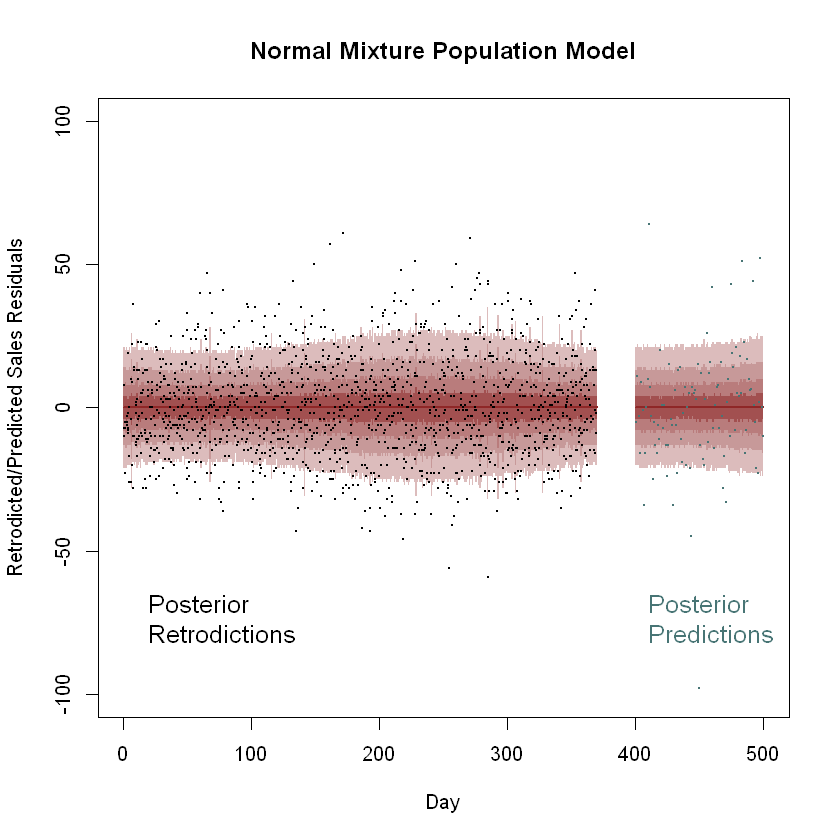

In [184]:
util$plot_dictions(samples, data, "Normal Mixture Population Model")

util$plot_dictions_residual(samples, data, "Normal Mixture Population Model")

Because the wider normal population model regularizes just how far the outer
extent, well, extends the posterior predictive forecast is regularized to
reasonable values.  This results in far better predictive performance compared
to the heavier tailed Cauchy and horseshoe population models.


In [185]:
pred_crps_comp["Normal Mixture"] = util$sum_empirical_crps(samples$y_post_pre, data$y_pred)
print(pred_crps_comp)

                   Normal  Laplace   Cauchy Horseshoe Normal Mixture
Predictive ECRPS 1109.773 1098.318 5351.806  5916.502       1096.723


## Comparison

To collect all of our insights together let's take a look at both the
inferential and predictive performance at the same time.

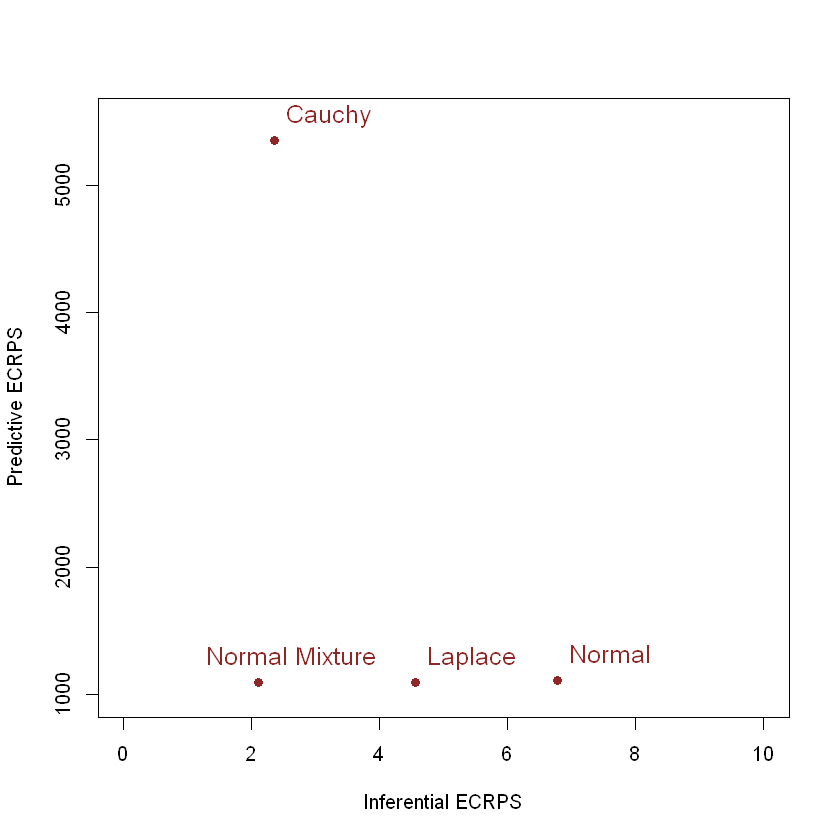

In [186]:
par(mfrow=c(1, 1))

plot(as.numeric(infer_crps_comp[1,]), as.numeric(pred_crps_comp[1,]),
     col=c_dark, pch=16, cex=1.0,
     xlim=c(0, 10), xlab="Inferential ECRPS",
     ylim=c(1000, 5500), ylab="Predictive ECRPS")

for (m in 1:4) {
  text(infer_crps_comp[1,m], pred_crps_comp[1,m] + 200,
       cex=1.25, label=names(infer_crps_comp)[m],
       pos=4, col=c_dark)
}

text(infer_crps_comp[1,5] - 1, pred_crps_comp[1,5] + 200,
     cex=1.25, label=names(infer_crps_comp)[5],
     pos=4, col=c_dark)

The population models with lighter tails -- the single normal and Laplace --
exhibit weaker inferential performance but stronger predictive performance.
This is consistent with what we've learned so far; the lighter tails limits how
well the posterior distribution can separate the relevant and irrelevant
parameters but it also regularizes just how far the posterior predictive
distribution can extend when we don't know whether a future day will see a
strong variation or not.

On the other hand the population models with heavier tails - the Cauchy and the
horseshoe -- exhibit stronger inferential performance but weaker predictive
performance!  The heavy tails that allow for the posterior distribution to
better isolate the irrelevant parameters from the relevant parameters also
dramatically widen the posterior predictive distributions.  This results in less
risky but much less actionable predictions.

Finally the mixture of two normal populations models achieves the best of both
approaches.  With both narrow and wide component populations this model is
flexible enough to accommodate both irrelevant and relevant parameters as the
same time without sacrificing the ability to regularize extreme values.

# Conclusion

The assumption of sparsity is often a powerful manifestation of our domain
expertise.  In order to fully take advantage of that assumption, however, we
need to properly incorporate it into our prior modeling.  Although there are
many heuristic models that claim to incorporate some form of sparsity, those
models are not always appropriate in any given application.  As always the most
best strategy is not to pick any prebuilt model but rather to elicit what the
particular assumption of sparsity means in each modeling application and build a
compatible population model.

Mixture models are an especially convenient tool for building bespoke population
models, but they must be implemented _carefully_.  There is still much research
to be done on the effective parameterization of these models.

One nearly universal consequence of sparsity-inducing prior models is the sharp
variation in how much the prior model influences the posterior distribution
relative to a realized likelihood function.  Strong regularization towards an
inner core implies that the prior model dominates while weak regularization
across the outer extent implies that the likelihood function dominates.  When
utilizing hierarchical prior models this variation has an immediate impact on
the geometry of the posterior distribution and consequently the most effective
parameterizations of the individual parameters.  By recognizing this impact we
can be better prepared to implement these models in practice.

# Appendix {-}

I've isolated all of the fun mathematics in this appendix for those curious
about some of the technical details mentioned in the main text.

## A. Continuous Mixture Derivations {-#sec:integral_party}

Here we will consider two continuous scale mixtures that convolve a normal
probability density function,

$$
\begin{align*}
\pi(\theta \mid \mu, \omega)
&= \text{normal}( \theta \mid \mu, \sqrt{\omega})
\\[0.4cm]
&=
\frac{1}{\sqrt{2 \pi \omega}}
\exp \left( - \frac{1}{2} \frac{ \left( \theta - \mu \right)^{2} }{\omega} \right).
\end{align*}
$$

with some probability distribution function over possible variances,

$$
\pi(\theta \mid \mu) = \int_{0}^{\infty} \mathrm{d} \omega \, \pi(\theta \mid \mu, \omega) \, \pi(\omega).
$$

For simplicity we will assume that the location parameter of the initial normal
probability density function is zero,

$$
\begin{align*}
\pi(\theta \mid \omega)
&= \text{normal}( \theta \mid 0, \sqrt{\omega})
\\[0.4cm]
&=
\frac{1}{\sqrt{2 \pi \omega}} \exp \left( - \frac{1}{2} \frac{ \theta^{2} }{ \omega } \right).
\end{align*}
$$

### A.1 Gamma Scales {-}

Consider a probability distribution over variances specified by a gamma
probability density function,

$$
\begin{align*}
\pi(\omega \mid \alpha, \beta)
&=
\text{gamma}(\omega \mid \alpha, \beta)
\\[0.4cm]
&=
\frac{ \beta^{\alpha} }{ \Gamma(\alpha) } \omega^{\alpha - 1} e^{- \beta \, \omega}.
\end{align*}
$$

The corresponding continuous scale mixture is then given by

$$
\begin{align*}
\pi(\theta \mid \alpha, \beta)
&=
\int_{0}^{\infty} \mathrm{d} \omega \,
\text{normal}(\theta \mid 0, \omega) \, \text{gamma} (\omega \mid \alpha, \beta)
\\[0.4cm]
&=
\int_{0}^{\infty} \mathrm{d} \omega \,
\frac{1}{\sqrt{2 \pi \omega}}
\exp \left( - \frac{1}{2} \frac{ \theta^{2} }{ \omega } \right) \,
\frac{ \beta^{\alpha} }{ \Gamma(\alpha) } \omega^{\alpha - 1} e^{- \beta \, \omega}
\\[0.4cm]
&=
\frac{1}{\sqrt{2 \pi}}
\frac{ \beta^{\alpha} }{ \Gamma(\alpha) }
\int_{0}^{\infty} \mathrm{d} \omega \,
\frac{\omega^{\alpha - 1}}{\sqrt{\omega}}
\exp \left( - \frac{ \theta^{2} }{ 2 \omega } - \beta \, \omega \right)
\\[0.4cm]
&=
\frac{1}{\sqrt{2 \pi}}
\frac{ \beta^{\alpha} }{ \Gamma(\alpha) }
\int_{0}^{\infty} \mathrm{d} \omega \,
\omega^{\alpha - \frac{3}{2}}
\exp \left( - \frac{ \theta^{2} }{ 2 \omega } - \beta \, \omega \right).
\end{align*}
$$

Now we can make the substitution $u = \beta \, \omega$,

$$
\begin{align*}
\pi(\theta \mid \alpha, \beta)
&=
\frac{1}{\sqrt{2 \pi}}
\frac{ \beta^{\alpha} }{ \Gamma(\alpha) }
\int_{0}^{\infty} \mathrm{d} \omega \,
\omega^{\alpha - \frac{3}{2}}
\exp \left( - \frac{ \theta^{2} }{ 2 \omega } - \beta \, \omega \right)
\\[0.4cm]
&=
\frac{1}{\sqrt{2 \pi}}
\frac{ \beta^{\alpha} }{ \Gamma(\alpha) }
\int_{0}^{\infty} \mathrm{d} u \, \frac{1}{\beta} \,
\left( \frac{u}{\beta} \right)^{\alpha - \frac{3}{2}}
\exp \left( - \frac{ \beta \, \theta^{2} }{ 2 u } - u \right)
\\[0.4cm]
&=
\frac{1}{\sqrt{2 \pi}}
\frac{ \beta^{\alpha} }{ \Gamma(\alpha) }
\left( \frac{1}{\beta} \right)^{\alpha - \frac{1}{2}}
\int_{0}^{\infty} \mathrm{d} u \,
u^{\alpha - \frac{3}{2}}
\exp \left( - \frac{ \beta \, \theta^{2} }{ 2 u } - u \right)
\\[0.4cm]
&=
\sqrt{ \frac{\beta}{2 \pi} }
\frac{1}{ \Gamma(\alpha) }
\int_{0}^{\infty} \mathrm{d} u \,
u^{\alpha - \frac{3}{2}}
\exp \left( - \frac{ \beta \, \theta^{2} }{ 2 u } - u \right)
\\[0.4cm]
&=
\sqrt{ \frac{\beta}{2 \pi} }
\frac{1}{ \Gamma(\alpha) }
\int_{0}^{\infty} \mathrm{d} u \,
\frac{1}{u^{1 + \left(\frac{1}{2} - \alpha \right)}}
\exp \left( - \frac{ \beta \, \theta^{2} }{ 2 u } - u \right)
\\[0.4cm]
&=
\sqrt{ \frac{\beta}{2 \pi} }
\frac{1}{ \Gamma(\alpha) }
\int_{0}^{\infty} \mathrm{d} u \,
\frac{1}{u^{1 + \left(\frac{1}{2} - \alpha \right)}}
\exp \left( - \frac{\left( \sqrt{2 \beta} | \theta | \right)^{2}}{4 u} - u \right).
\end{align*}
$$

The remaining integral reduces to a Bessel function [@Tweedie:1957],

$$
\int_{0}^{\infty} \mathrm{d} u \,
\frac{1}{u^{1 + \gamma}}
\exp \left( - \frac{ z^{2} }{ 4 u } - u \right)
=
2 \left( \frac{2}{z} \right)^{\nu} K_{\pm \nu}(z),
$$

which gives

$$
\begin{align*}
\pi(\theta \mid \alpha, \beta)
&=
\sqrt{ \frac{\beta}{2 \pi} }
\frac{1}{ \Gamma(\alpha) }
\int_{0}^{\infty} \mathrm{d} u \,
\frac{1}{u^{1 + \left(\frac{1}{2} - \alpha \right)}}
\exp \left( - \frac{\left( \sqrt{2 \beta} | \theta | \right)^{2}}{4 u} - u \right).
\\[0.4cm]
&=
\sqrt{ \frac{\beta}{2 \pi} }
\frac{1}{ \Gamma(\alpha) }
2 \left( \frac{2}{\sqrt{2 \beta} | \theta |} \right)^{\frac{1}{2} - \alpha}
K_{\pm ( \frac{1}{2} - \alpha )}(\sqrt{2 \beta} | \theta |)
\\[0.4cm]
&=
\sqrt{ \frac{2 \beta}{\pi} }
\frac{1}{ \Gamma(\alpha) }
\left( \frac{2}{\sqrt{2 \beta} | \theta |} \right)^{\frac{1}{2} - \alpha}
K_{\pm (\frac{1}{2} - \alpha)}(\sqrt{2 \beta} | \theta |).
\end{align*}
$$

Unfortunately the Bessel function has a convenient closed form only when
$ \nu = \pm \frac{1}{2}$ which we can achieve only when $\alpha = 1$.  In this
case

$$
K_{(\frac{1}{2} - \alpha)}( \sqrt{2 \beta} | \theta |)
=
K_{-\frac{1}{2} }(\sqrt{2 \beta} | \theta |)
=
e^{ - \sqrt{2 \beta} | \theta | } \sqrt{ \frac{\pi}{ 2 \sqrt{2 \beta} | \theta | } }
$$

and

$$
\begin{align*}
\pi(\theta \mid \alpha = 1, \beta)
&=
\sqrt{ \frac{2 \beta}{\pi} }
\frac{1}{ \Gamma(1) }
\left( \frac{2}{\sqrt{2 \beta} | \theta |} \right)^{-\frac{1}{2}}
e^{ - \sqrt{2 \beta} | \theta | } \sqrt{ \frac{\pi}{ 2 \sqrt{2 \beta} | \theta | } }
\\[0.4cm]
&=
\frac{1}{ \Gamma(1) }
\sqrt{ \frac{2 \beta}{\pi} }
\sqrt{ \frac{\sqrt{2 \beta} | \theta |}{2} }
\sqrt{ \frac{\pi}{ 2 \sqrt{2 \beta} | \theta | } }
e^{ - \sqrt{2 \beta} | \theta | }
\\[0.4cm]
&=
\sqrt{ \frac{2 \beta}{\pi}
\cdot \frac{\sqrt{2 \beta} | \theta |}{2}
\cdot \frac{\pi}{ 2 \sqrt{2 \beta} | \theta | } }
e^{ - \sqrt{2 \beta} | \theta | }
\\[0.4cm]
&=
\sqrt{ \frac{\beta}{2} } e^{ - \sqrt{2 \beta} | \theta | }.
\end{align*}
$$

If we take $\sqrt{2\beta} = 1 / \tau$ then

$$
\begin{align*}
\pi(\theta \mid \tau)
&=
\pi \left( \theta \mid \alpha = 1, \beta = \frac{1}{2 \tau^{2}} \right)
\\[0.4cm]
&=
\frac{1}{2 \tau} \exp \left( - \frac{ | \theta | }{ \tau } \right)\
\\[0.4cm]
&=
\text{Laplace}(\theta \mid \tau).
\end{align*}
$$

In other words the convolution of a normal density function with an exponential
density function results in a Laplace density function,

$$
\begin{align*}
\text{Laplace}(\theta \mid \tau)
&=
\int_{0}^{\infty} \mathrm{d} \omega \,
\text{normal} \bigg(\theta \mid 0, \sqrt{\omega} \bigg) \,
\text{gamma} \bigg( \omega \mid 1, \frac{1}{2 \tau^{2}} \bigg)
\\[0.4cm]
&=
\int_{0}^{\infty} \mathrm{d} \omega \,
\text{normal} \bigg(\theta \mid 0, \sqrt{\omega} \bigg) \,
\text{exponential} \bigg( \omega \mid \frac{1}{2 \tau^{2}} \bigg).
\end{align*}
$$

### A.2 Inverse Gamma Scales {-}

Now consider a probability distribution over variances specified by an inverse
gamma probability density function,

$$
\begin{align*}
\pi(\omega \mid \alpha, \beta)
&=
\text{inv-gamma}(\omega \mid \alpha, \beta)
\\[0.4cm]
&=
\frac{ \beta^{\alpha} }{ \Gamma(\alpha) } \omega^{-\alpha - 1} e^{- \frac{\beta}{\omega}}.
\end{align*}
$$

The corresponding continuous scale mixture is given by

$$
\begin{align*}
\pi(\theta \mid \alpha, \beta)
&=
\int_{0}^{\infty} \mathrm{d} \omega \,
\text{normal}(\theta \mid 0, \omega) \, \text{inv-gamma} (\omega \mid \alpha, \beta)
\\[0.4cm]
&=
\int_{0}^{\infty} \mathrm{d} \omega \,
\frac{1}{\sqrt{2 \pi \omega}} \exp \left( - \frac{1}{2} \frac{ \theta^{2} }{ \omega } \right) \,
\frac{ \beta^{\alpha} }{ \Gamma(\alpha) } \omega^{-\alpha - 1} e^{- \frac{\beta}{\omega}}
\\[0.4cm]
&=
\frac{1}{\sqrt{2 \pi }}
\frac{ \beta^{\alpha} }{ \Gamma(\alpha) }
\int_{0}^{\infty} \mathrm{d} \omega \,
\omega^{-\frac{1}{2}} \omega^{-\alpha - 1}
\exp \left( - \frac{1}{2} \frac{ \theta^{2} }{ \omega } - \frac{\beta}{\omega} \right)
\\[0.4cm]
&=
\frac{1}{\sqrt{2 \pi }}
\frac{ \beta^{\alpha} }{ \Gamma(\alpha) }
\int_{0}^{\infty} \mathrm{d} \omega \,
\omega^{-\alpha - \frac{3}{2}}
\exp \left( - \frac{ \frac{1}{2} \theta^{2} + \beta }{ \omega } \right).
\end{align*}
$$

At this point we can make the substitution

$$
    u = \frac{ \frac{1}{2} \theta^{2} + \beta }{ \omega }
$$

which gives

$$
\begin{align*}
\pi(\theta \mid \alpha, \beta)
&=
\frac{1}{\sqrt{2 \pi }}
\frac{ \beta^{\alpha} }{ \Gamma(\alpha) }
\int_{\infty}^{0} \mathrm{d} u \, \left( - \frac{ \frac{1}{2} \theta^{2} + \beta }{ u^{2} } \right)
\left( \frac{ \frac{1}{2} \theta^{2} + \beta }{ u } \right)^{-\alpha - \frac{3}{2}}
e^{-u}
\\[0.4cm]
&=
\frac{1}{\sqrt{2 \pi}}
\frac{ \beta^{\alpha} }{ \Gamma(\alpha) }
\left( \frac{1}{2} \theta^{2} + \beta \right)^{- (\alpha + \frac{1}{2}) }
\int_{0}^{\infty} \mathrm{d} u \, \left( \frac{1}{u} \right)^{-\alpha + \frac{1}{2}}
e^{-u}
\\[0.4cm]
&=
\frac{1}{\sqrt{2 \pi}}
\frac{ \beta^{\alpha} }{ \Gamma(\alpha) }
\left( \frac{1}{2} \theta^{2} + \beta \right)^{- (\alpha + \frac{1}{2}) }
\int_{0}^{\infty} \mathrm{d} u \, u^{(\alpha + \frac{1}{2}) - 1}
e^{-u}.
\end{align*}
$$

Conveniently the remaining integral reduces to a gamma function,

$$
\int_{0}^{\infty} \mathrm{d} u \, u^{z - 1} e^{-u} = \Gamma(z),
$$

in which case we have

$$
\begin{align*}
\pi(\theta \mid \alpha, \beta)
&=
\frac{1}{\sqrt{2 \pi}}
\frac{ \beta^{\alpha} }{ \Gamma(\alpha) }
\left( \frac{1}{2} \theta^{2} + \beta \right)^{- (\alpha + \frac{1}{2}) }
\int_{0}^{\infty} \mathrm{d} u \, u^{(\alpha + \frac{1}{2}) - 1}
e^{-u}
\\[0.4cm]
&=
\frac{1}{\sqrt{2 \pi}}
\frac{ \beta^{\alpha} }{ \Gamma(\alpha) }
\left( \frac{1}{2} \theta^{2} + \beta \right)^{- (\alpha + \frac{1}{2}) }
\Gamma(\alpha + \frac{1}{2})
\\[0.4cm]
&=
\frac{1}{\sqrt{2 \pi}}
\frac{\Gamma(\alpha + \frac{1}{2}) }{ \Gamma(\alpha) }
\beta^{\alpha}
\left( \frac{1}{2} \theta^{2} + \beta \right)^{- (\alpha + \frac{1}{2}) }
\\[0.4cm]
&=
\frac{1}{\sqrt{2 \pi}}
\frac{\Gamma(\alpha + \frac{1}{2}) }{ \Gamma(\alpha) }
\beta^{\alpha}
\beta^{-\alpha - \frac{1}{2}}
\left( \frac{\theta^{2}}{2 \beta} + 1 \right)^{- (\alpha + \frac{1}{2}) }
\\[0.4cm]
&=
\frac{1}{\sqrt{2 \pi}}
\frac{\Gamma(\alpha + \frac{1}{2}) }{ \Gamma(\alpha) }
\beta^{- \frac{1}{2}}
\left( \frac{\theta^{2}}{2 \beta} + 1 \right)^{- (\alpha + \frac{1}{2}) }
\\[0.4cm]
&=
\frac{1}{\sqrt{2 \pi \, \beta}}
\frac{\Gamma(\alpha + \frac{1}{2}) }{ \Gamma(\alpha) }
\left( 1 + \frac{\theta^{2}}{2 \beta} \right)^{- (\alpha + \frac{1}{2}) }.
\end{align*}
$$

To put this into a more familiar form let's take $\alpha= \frac{\nu}{2}$ and
$\beta = \frac{\nu}{2} \, \tau$,

$$
\begin{align*}
\pi(\theta \mid \nu, \tau)
&=
\pi(\theta \mid \alpha = \frac{\nu}{2}, \beta = \frac{\nu}{2} \, \tau)
\\[0.4cm]
&=
\frac{1}{\sqrt{2 \pi \, \frac{\nu}{2} \, \tau}}
\frac{\Gamma(\frac{\nu}{2} + \frac{1}{2}) }{ \Gamma(\frac{\nu}{2}) }
\left( 1 + \frac{\theta^{2}}{2 \frac{\nu}{2} \, \tau} \right)^{- (\frac{\nu}{2} + \frac{1}{2}) }
\\[0.4cm]
&=
\frac{1}{\sqrt{\pi \, \nu \, \tau}}
\frac{\Gamma(\frac{\nu + 1}{2}) }{ \Gamma(\frac{\nu}{2}) }
\left( 1 + \frac{\theta^{2}}{ \nu \, \tau} \right)^{- \frac{\nu + 1}{2} }
\\[0.4cm]
&=
\frac{1}{\sqrt{\pi \, \nu \, \tau}}
\frac{\Gamma(\frac{\nu + 1}{2}) }{ \Gamma(\frac{\nu}{2}) }
\left( 1 + \frac{1}{\nu} \left( \frac{ \theta}{\tau} \right)^{2} \right)^{- \frac{\nu + 1}{2} }
\\[0.4cm]
&=
\text{Student's-t}(\theta \mid \nu, 0, \tau).
\end{align*}
$$

In other words the convolution of a normal density function with an inverse
gamma density function results in a Student's t density function,

$$
\begin{align*}
\text{Student's-t}(\theta \mid \nu, 0, \tau)
&=
\int_{0}^{\infty} \mathrm{d} \omega \,
\text{normal} \bigg(\theta \mid 0, \sqrt{\omega} \bigg) \,
\text{inv-gamma} \bigg( \omega \mid \frac{\nu}{2}, \frac{\nu}{2} \, \tau \bigg).
\end{align*}
$$

## B. Empirical Continuous Probability Rank Score {-#sec:ecrps}

The _continuous rank probability score_ [@GneitingEtAl:2007] is a proper
scoring rule that quantifies the similarity between two probability
distributions defined on a real line.  If $ \Pi(x)$ is the cumulative
distribution function of of the first distribution and $\tilde{\Pi}(x)$ is the
cumulative distribution function of the other then the continuous rank
probability score is defined as

$$
\text{CRPS}(\Pi, \tilde{\Pi})
= \int \mathrm{d} x \, \left( \Pi(x) - \tilde{\Pi}(x) \right)^{2}.
$$

The more similar the two distributions the closer the continuous rank
probability score will be to zero; in particular this quantification depends on
both how well the centralities and the breadths of two distributions match.

When the second distribution is given by a Dirac distribution that concentrates
on the single point $ \tilde{x}$ the second cumulative distribution function
becomes a Heaviside step function,

$$
\tilde{\Pi}(x) = H(x < \tilde{x})
=
\left\{
\begin{array}{rr}
0, & x < \tilde{x} \\
1, & \tilde{x} \le x
\end{array}
\right. .
$$

In this case the continuous rank probability score reduces to

$$
\begin{align*}
\text{CRPS}
&= \int_{X} \mathrm{d} x \, \left( \Pi(x) - H(x < \tilde{x}) \right)^{2}
\\[0.4cm]
&=
\int_{-x_{\min}}^{\tilde{x}} \, \mathrm{d} x \left( \Pi(x) \right)^{2}
+
\int_{\tilde{x}}^{x_{\max}} \, \mathrm{d} x \left( 1 - \Pi(x) \right)^{2}.
\end{align*}
$$

The more strongly the first probability distribution concentrates around
$\tilde{x}$ the smaller the continuous rank probability score.

If the first probability distribution function is represented by only samples
then we can estimate the corresponding cumulative distribution function with the
empirical cumulative distribution function, $\hat{\Pi}(x)$.  I will refer to the
corresponding continuous rank probability score between the empirical cumulative
distribution function and the Dirac cumulative distribution function as the
_empirical continuous rank probability score_.

<div><center><table class="image">
<caption align="top"><h2>Continuous Rank Probability Score</h2></caption>
<tr><td><img src="figures/crps/crps.png" width="800"></td></tr>
</table></center></div>

If the samples are ordered such that

$$
x_{1} \le x_{2} \le \ldots
x_{\tilde{n}} < \tilde{x} \le x_{\tilde{n} + 1} \le \ldots
\le x_{N - 1} \le x_{N}
$$

then the empirical continuous rank probability score reduces to

$$
\begin{align*}
\text{ECRPS}
&= \sum_{n = 1}^{\tilde{n}} \left( \frac{n}{N} \right)^{2} ( x_{n + 1} - x_{n} )
+ \left( \frac{\tilde{n}}{N} \right)^{2} (\tilde{x} - x_{\tilde{n}})
\\[0.4cm]
&\quad + \left(1 - \frac{\tilde{n}}{N} \right)^{2} (x_{\tilde{n} + 1} - \tilde{x})
+ \sum_{n = \tilde{n} + 1}^{N - 1} \left(1 - \frac{n}{N} \right)^{2} ( x_{n + 1} - x_{n} ).
\end{align*}
$$

When $\tilde{x}$ is smaller or larger than all of the samples then we have to
be a bit more careful.  For example if $\tilde{x}$ is smaller than all of the
samples then

$$
\text{ECRPS} =
\sum_{n = 1}^{N - 1} \left(1 - \frac{n}{N} \right)^{2} ( x_{n + 1} - x_{n} ),
$$

and if $\tilde{x}$ is larger than all of the samples then

$$
\text{ECRPS} =
\sum_{n = 1}^{N - 1} \left( \frac{n}{N} \right)^{2} ( x_{n + 1} - x_{n} ).
$$

Be warned that this is not the only way in which samples can be used to estimate
a continuous rank probability distribution.  For example some software packages
will attempt to fit the empirical cumulative distribution function to a smooth
function before numerically integrating.  The use of the empirical cumulative
distribution function as a piece-wise function here is meant only to be a
convenient, easily calculated estimate that provides some way to quantify how
strongly a set of sample concentrates around some target value.

# Acknowledgements {-}

I thank Will Shoemaker for helpful comments.

A very special thanks to everyone supporting me on Patreon: Aapeli Nevala, 
Abhinav Katoch, Adam Bartonicek, Adam Fleischhacker, Adan, Alan O'Donnell, 
Alessandro Varacca, Alex ANDORRA, Alexander Bartik, Alexander Noll, 
Alfredo Garbuno Iñigo, Allison M. Campbell, Anders Valind, Andrea Serafino, 
Andrew Rouillard, Annie Chen, Antoine Soubret, Ara Winter, Arya, asif zubair, 
Austin Carter, Austin Rochford, Austin Rochford, Avraham Adler, Bao Tin Hoang, 
Ben Matthews, Ben Swallow, Benjamin Phillabaum, Benoit Essiambre, 
Bertrand Wilden, Bo Schwartz Madsen, Brian Hartley, Bryan Yu, 
Brynjolfur Gauti Jónsson, Cameron Smith, Canaan Breiss, Cat Shark, 
Chad Scherrer, Charles Naylor, Chase Dwelle, Chris Jones, Chris Zawora, 
Christopher Mehrvarzi, Chuck Carlson, Cole Monnahan, Colin Carroll, 
Colin McAuliffe, D, Damien Mannion, dan mackinlay, dan muck, Dan W Joyce, 
Daniel Edward Marthaler, Daniel Hocking, Daniel Rowe, Darshan Pandit, 
David Burdelski, David Christle, David Humeau, David Pascall, DeLorean Gipson, 
Derek G Miller, dilsher singh dhillon, Donna Perry, Doug Rivers, Dylan Murphy, 
Ed Berry, Ed Cashin, Eduardo, Elizaveta Semenova, Eric Novik, Erik Banek, 
Ero Carrera, Ethan Goan, Eugene, Evan Cater, Fabio Zottele, Federico Carrone, 
Felipe González, Fergus Chadwick, Filipe Dias, Finn Lindgren, Florian Wellmann, 
Francesco Corona, Geoff Rollins, George Ho, Georgia S, Granville Matheson, 
Hamed Bastan-Hagh, Haonan Zhu, Hugo Botha, Hyunji Moon, Ian, Ignacio Vera, 
Ilaria Prosdocimi, Isaac S, J, J Michael Burgess, Jair Andrade Ortiz, 
James Doss-Gollin, James McInerney, James Wade, JamesU, Janek Berger, 
Jason Martin, Jeff Dotson, Jeff Helzner, Jeffrey Arnold, Jeffrey Burnett, 
Jeffrey Erlich, Jessica Graves, Joel Kronander, John Flournoy, John Zito, Jon, 
Jonathan St-onge, Jonathon Vallejo, Jordi Warmenhoven, Jose Pereira, 
Josh Weinstock, Joshua Duncan, Joshua Griffith, Joshua Mayer, Josué Mendoza, 
Justin Bois, Karim Naguib, Karim Osman, Kejia Shi, Kevin Thompson, Kádár András, 
Lane Harrison, lizzie, Luiz Carvalho, Luiz Pessoa, Marc Dotson, 
Marc Trunjer Kusk Nielsen, Marek Kwiatkowski, Mark Donoghoe, Markus P., 
Martin Modrák, Matthew Hawthorne, Matthew Kay, Matthew Quick, Matthew T Stern, 
Maurits van der Meer, Maxim Kesin, Melissa Wong, Merlin Noel Heidemanns, 
Michael Cao, Michael Colaresi, Michael DeWitt, Michael Dillon, Michael Lerner, 
Michael Redman, Michael Tracy, Mick Cooney, Mike Lawrence, MisterMentat, 
Márton Vaitkus, Name, Nathaniel Burbank, Nerf-Shepherd, Nicholas Cowie, 
Nicholas Erskine, Nicholas Ursa, Nick S, Nicolas Frisby, Noah Guzman, 
Ole Rogeberg, Oliver Crook, Olivier Ma, Omri Har Shemesh, Pablo León Villagrá, 
Patrick Boehnke, Pau Pereira Batlle, Paul Oreto, Peter Smits, 
Pieter van den Berg, Pintaius Pedilici, ptr, Ramiro Barrantes Reynolds, 
Ravin Kumar, Raúl Peralta Lozada, Reece Willoughby, Reed Harder, 
Riccardo Fusaroli, Robert Frost, Robert Goldman, Robert kohn, Robert Mitchell V, 
Robin Taylor, Rong Lu, Roofwalker, Ryan Grossman, Ryan McMinds, Scott Block, 
Scott Brown, Sean Talts, Serena, Seth Axen, Shira, sid phani, Simon Dirmeier, 
Simon Duane, Simon Lilburn, Srivatsa Srinath, Stephanie Fitzgerald, Stephen 
Lienhard, Stephen Oates, Steve Bertolani, Stijn, Stone Chen, Sus, Susan Holmes, 
Suyog Chandramouli, Sören Berg, Tao Ye, tardisinc, Teddy Groves, Teresa Ortiz, 
Thomas Littrell, Thomas Vladeck, Théo Galy-Fajou, Tiago Cabaço, Tim Howes, 
Tim Radtke, Tobychev, Tom Knowles, Tom McEwen, Tommy Naugle, Tony Wuersch, 
Tyrel Stokes, Utku Turk, Virginia Fisher, vittorio trotta, Vladimir Markov, 
Will Dearden, Will Farr, Will Kurt, Will Tudor-Evans, yolhaj, yureq, Z, Zach A, 
ZAKH, and Zwelithini Tunyiswa.

# References {-}

<div id="refs"></div>

# License {-}

The code in this case study is copyrighted by Michael Betancourt and licensed
under the new BSD (3-clause) license:

https://opensource.org/licenses/BSD-3-Clause

The text and figures in this case study are copyrighted by Michael Betancourt
and licensed under the CC BY-NC 4.0 license:

https://creativecommons.org/licenses/by-nc/4.0/

# Original Computing Environment {-}

In [187]:
writeLines(readLines(file.path(Sys.getenv("HOME"), ".R/Makevars")))

CXX=C:/R/rtools42/x86_64-w64-mingw32.static.posix/bin/g++.exe
CXX14FLAGS=-O3 -mtune=native -mmmx -msse -msse2 -msse3 -mssse3 -msse4.1 -msse4.2 
CXX11FLAGS=-O3 -mtune=native -mmmx -msse -msse2 -msse3 -mssse3 -msse4.1 -msse4.2



In [188]:
sessionInfo()

R version 4.2.0 (2022-04-22 ucrt)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 22000)

Matrix products: default

locale:
[1] LC_COLLATE=English_United Kingdom.utf8 
[2] LC_CTYPE=English_United Kingdom.utf8   
[3] LC_MONETARY=English_United Kingdom.utf8
[4] LC_NUMERIC=C                           
[5] LC_TIME=English_United Kingdom.utf8    

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] rstan_2.26.11       StanHeaders_2.26.11

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-7       tidyselect_1.1.2   repr_1.1.4         purrr_0.3.4       
 [5] V8_4.1.0           colorspace_2.0-3   vctrs_0.4.1        generics_0.1.2    
 [9] htmltools_0.5.2    stats4_4.2.0       loo_2.5.1          base64enc_0.1-3   
[13] utf8_1.2.2         rlang_1.0.2        pkgbuild_1.3.1     pillar_1.7.0      
[17] withr_2.5.0        glue_1.6.2         DBI_1.1.2          uuid_1.1-0        
[21] ma